In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import tqdm
import copy
from tinyyolov2NoBN import TinyYoloV2NoBN
from pruned_tinyyolov2NoBN import PrunedTinyYoloV2NoBN 
from typing import Dict, List

from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes
from utils.loss import YoloLoss

from utils.dataloader import VOCDataLoaderPerson

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [10]:
loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
loader_test = VOCDataLoaderPerson(train=False, batch_size=1, shuffle=True)

In [11]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    for name, param in state_dict.items():
        # Only prune conv layers, excluding conv1 and conv9
        if 'conv' in name and 'weight' in name and 'conv1' not in name and 'conv9' not in name:
            weight = state_dict[name]
            out_channels = weight.shape[0]
            num_channels_to_prune = int(out_channels*prune_ratio)
            if num_channels_to_prune < 1:
                continue
            l1 = torch.sum(torch.abs(weight), (1, 2, 3))
            zero_out_channels = torch.argsort(l1)
            
            for i in range(num_channels_to_prune):
                weight[zero_out_channels[i], :, :, :] = 0
            
            state_dict[name] = weight
            
            bias_key = name.replace('weight', 'bias')
            bias = state_dict[bias_key]
            for i in range(num_channels_to_prune):
                bias[zero_out_channels[i]] = 0
            
            state_dict[bias_key] = bias
            
    return state_dict

In [12]:
def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    mask = None
    
    for layer in range(1, 10):
        l = "conv" + str(layer) + "."
        w = l + "weight"
        b = l + "bias"
        
        weights = state_dict[w]
        biases = state_dict[b]
        if mask is not None:
            weights = weights[:,mask,:,:]
            
        mask = torch.nonzero(weights.sum(dim=[1,2,3]), as_tuple=True)[0].tolist()
        
        weights = weights[mask,:,:,:]
        biases = biases[mask]
        
        state_dict[w] = weights
        state_dict[b] = biases
    
    #weights = state_dict["fc.weight"]
    
    #fcmask = []
    #for channel in mask:
    #    for i in range(4):
    #        fcmask.append(channel * 4 + i)
    
    #state_dict["fc.weight"] = weights[:,fcmask]
    
    return state_dict

In [13]:
net = PrunedTinyYoloV2NoBN(num_classes=1)
state_dict = torch.load("models/voc_fused_100_epochs_lr0001_decay0005.pt", map_location=device)
net.load_state_dict(state_dict, strict=False)
net.to(device)

frozedLayers = []
lr = 0.001
weight_decay = 0.005

criterion = YoloLoss(anchors=net.anchors)


for key, param in net.named_parameters():
    if any(x in key for x in frozedLayers):
        param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=lr, weight_decay=weight_decay)

-----Pruning iteration 1/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.04it/s]

average precision [0.42104838224241214]


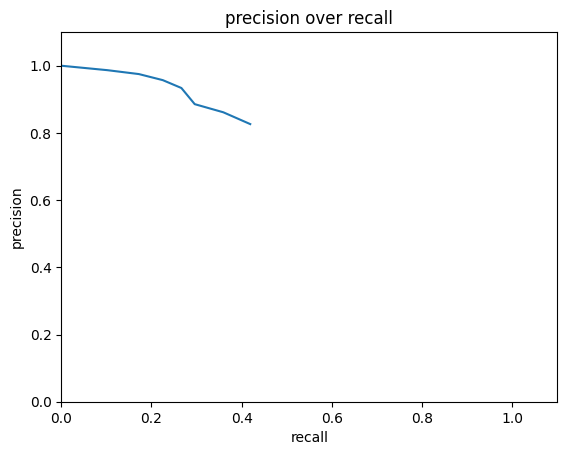

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.62it/s]

average precision [0.42104838224241214, 0.4220728966997624]


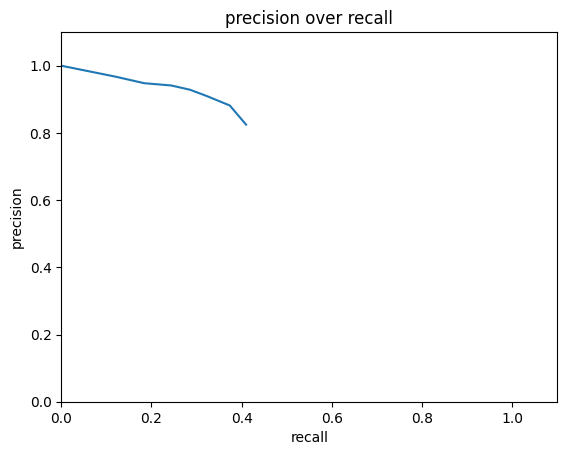

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.21it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815]


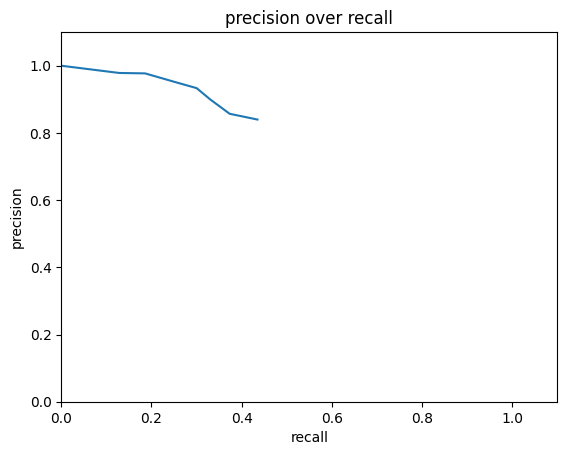

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.45it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854]


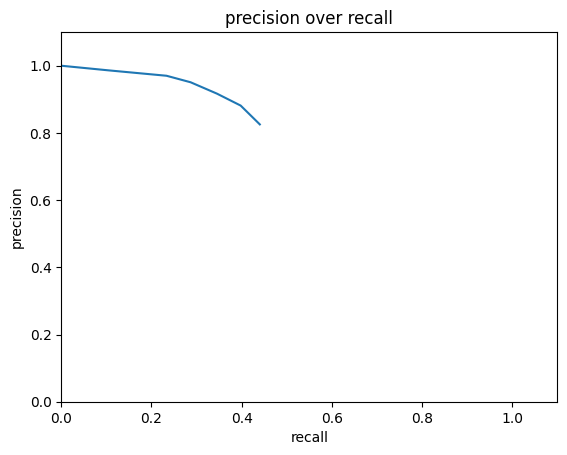

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:10<00:00, 18.65it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321]


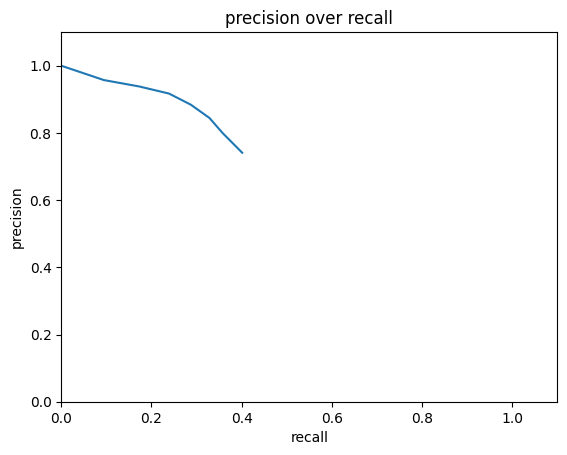

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 22.12it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847]


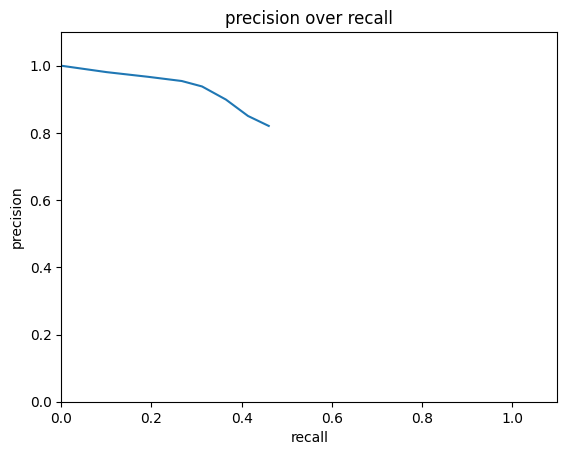

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.67s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 22.22it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038]


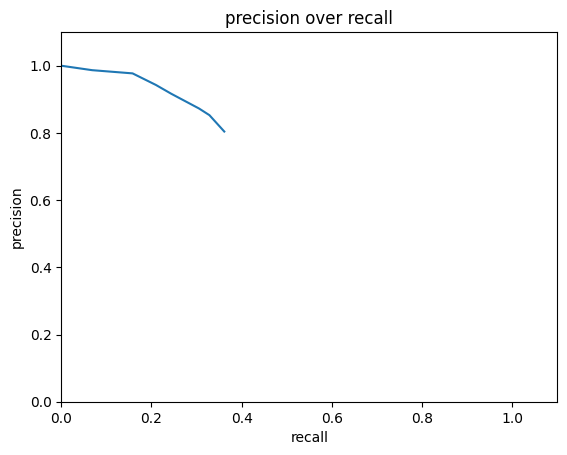

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.71it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146]


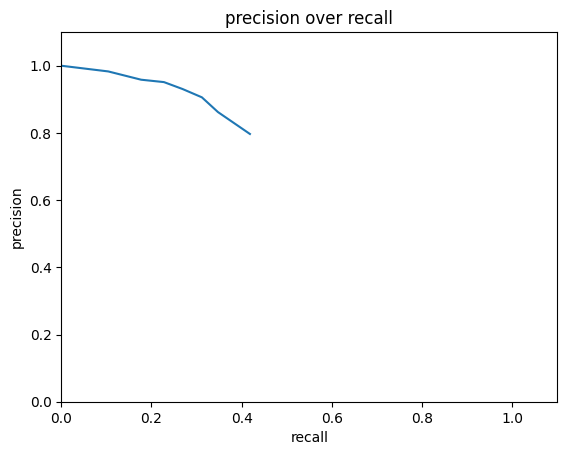

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 20.93it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555]


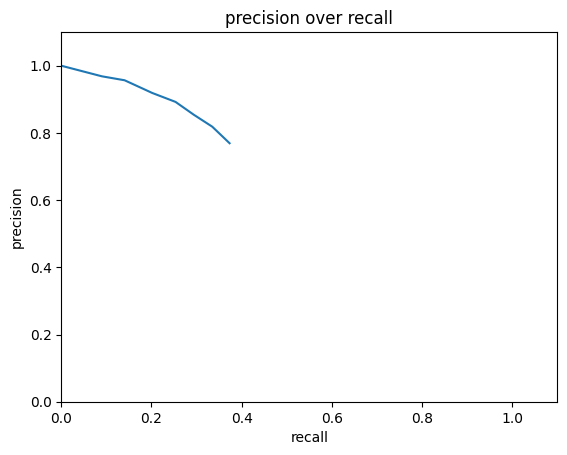

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.67s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.68it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103]


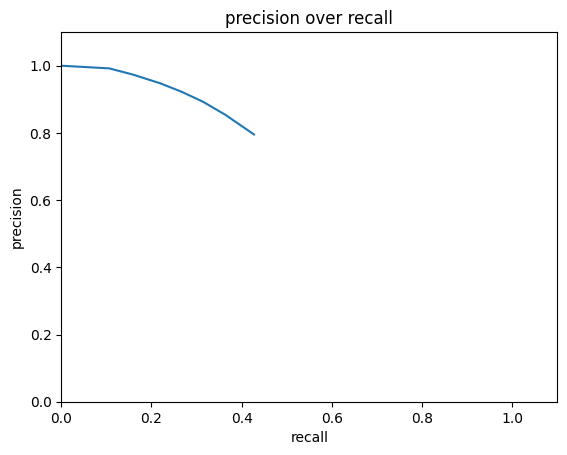

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763]


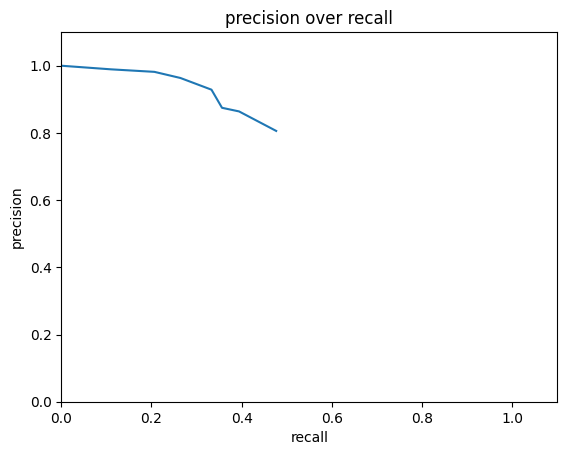

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.71it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313]


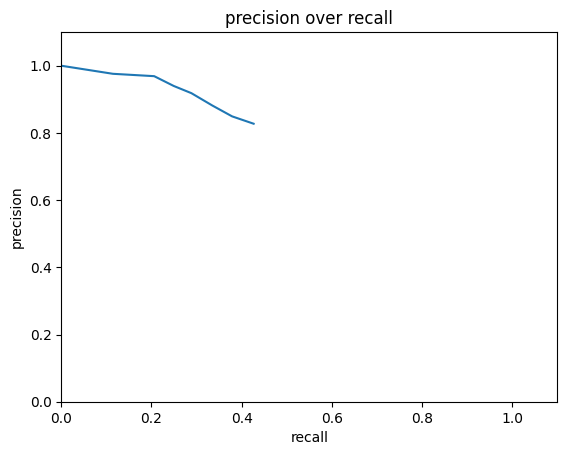

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.72it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703]


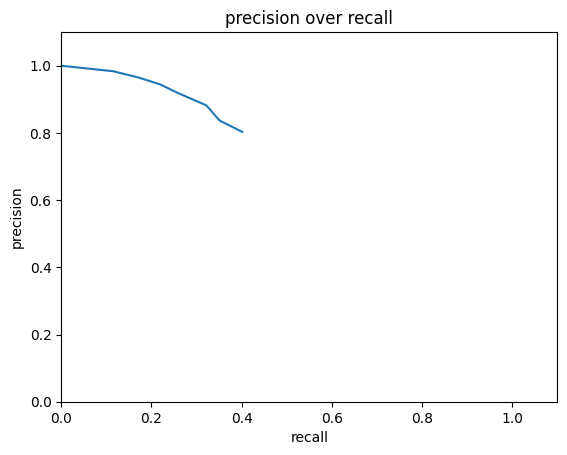

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 22.17it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604]


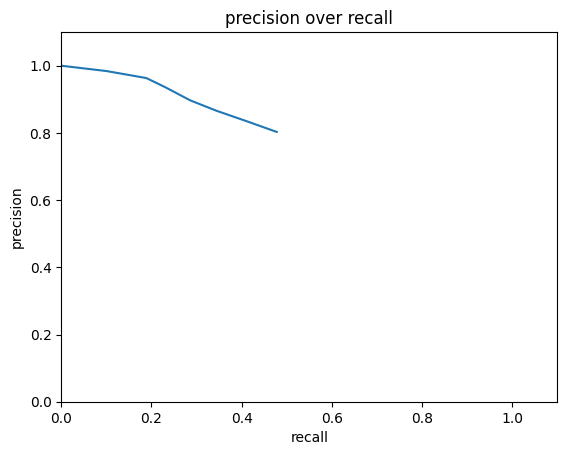

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.65s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.28it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865]


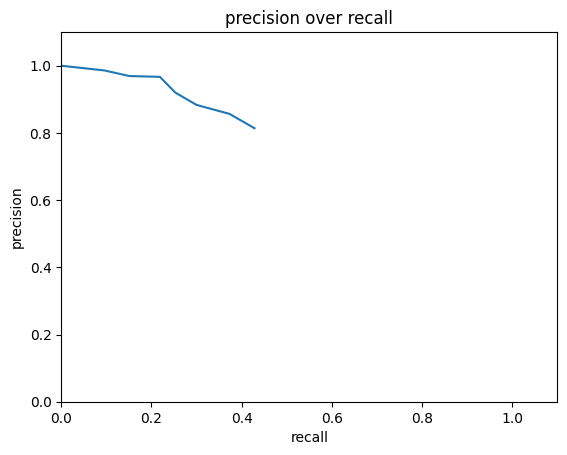

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.07it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923]


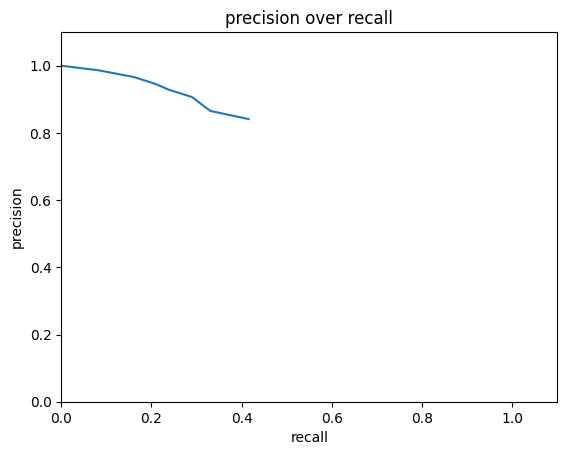

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.44it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993]


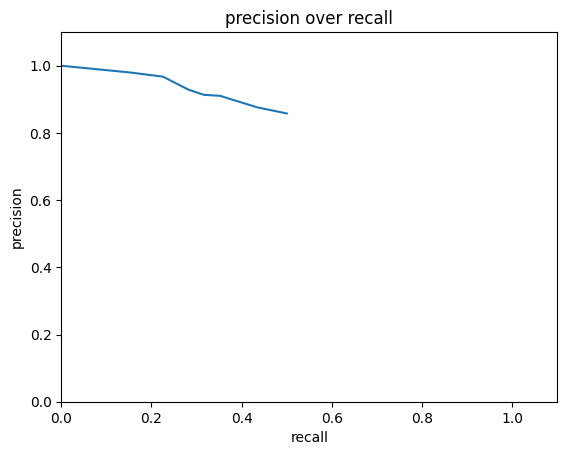

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.67s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.81it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424]


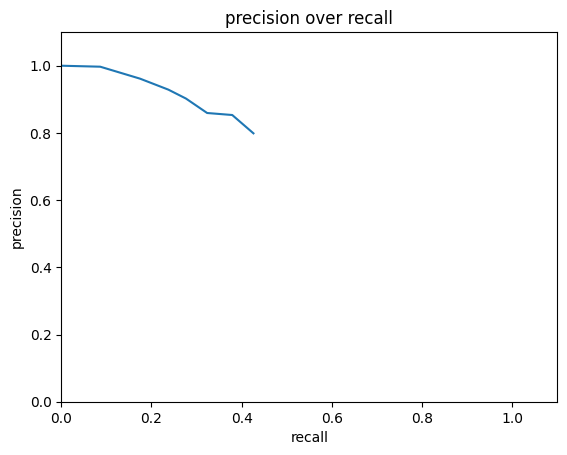

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.62s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.78it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217]


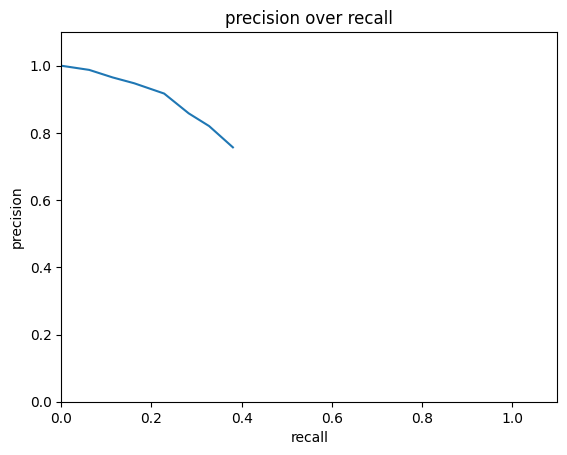

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.61s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.05it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677]


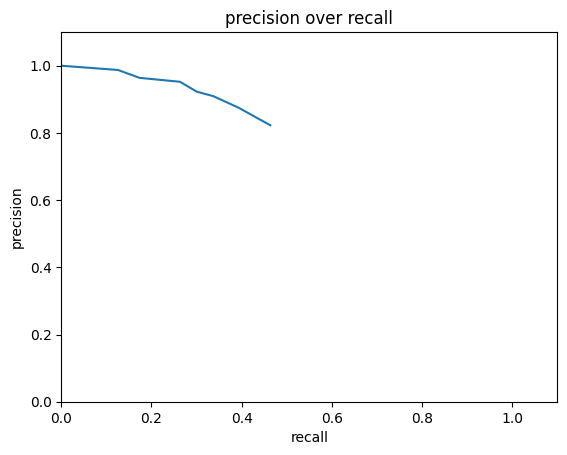

-----Pruning iteration 2/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.75it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221]


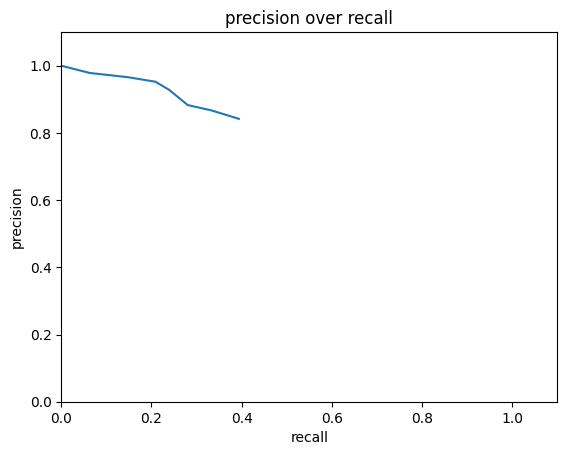

Training started.


100%|██████████| 17/17 [00:34<00:00,  2.00s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.01it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563]


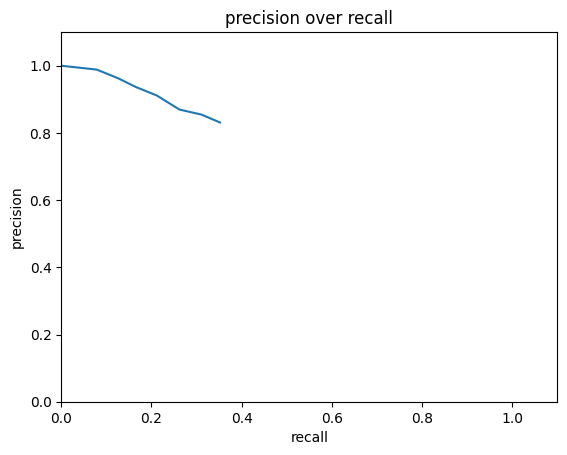

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.69it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967]


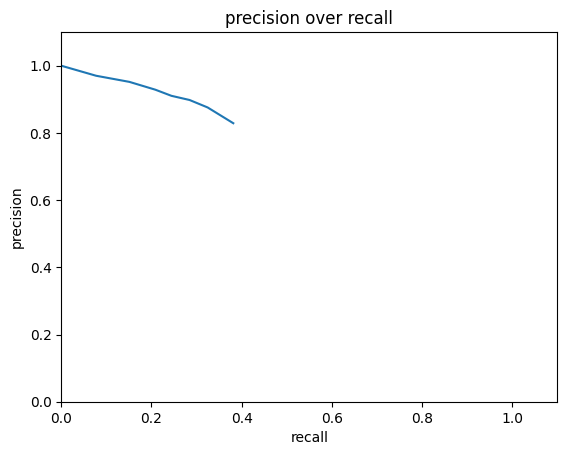

Training started.


100%|██████████| 17/17 [00:52<00:00,  3.11s/it]


Validation started.


100%|██████████| 200/200 [00:15<00:00, 12.53it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477]


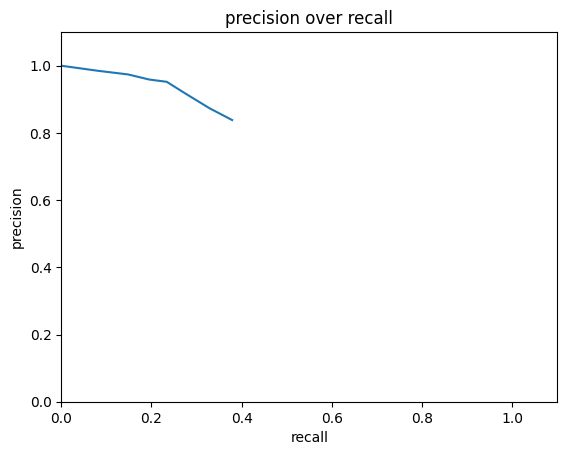

Training started.


100%|██████████| 17/17 [00:59<00:00,  3.50s/it]


Validation started.


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964]


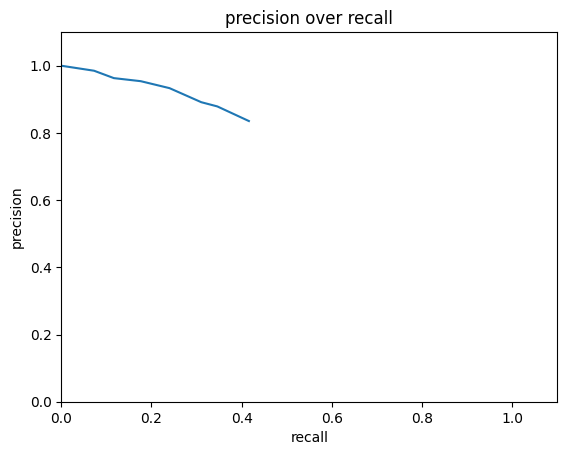

Training started.


100%|██████████| 17/17 [00:50<00:00,  2.99s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.45it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807]


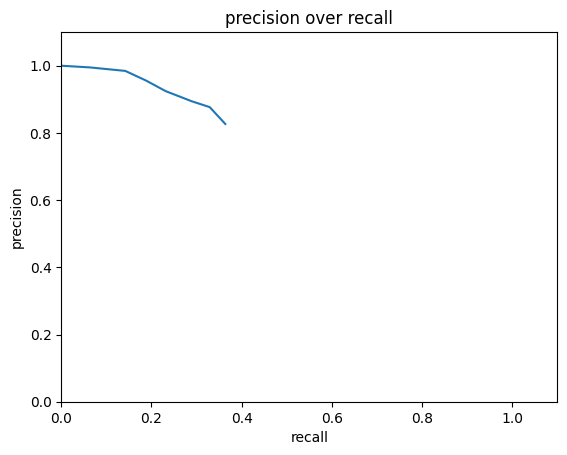

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.08it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246]


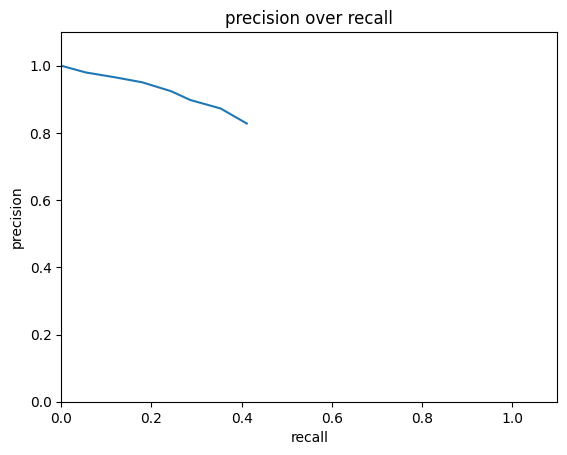

Training started.


100%|██████████| 17/17 [00:32<00:00,  1.94s/it]


Validation started.


100%|██████████| 200/200 [00:16<00:00, 11.84it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477]


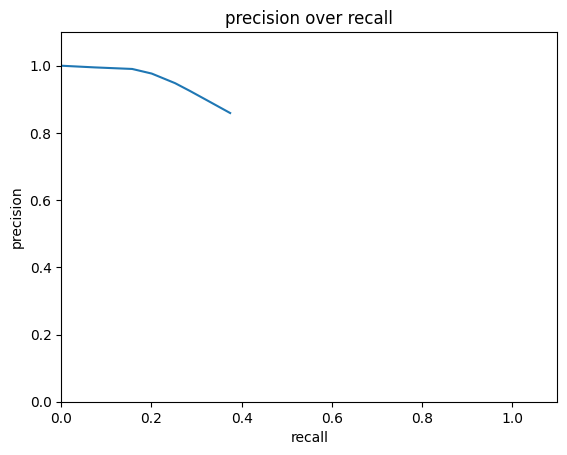

Training started.


100%|██████████| 17/17 [00:57<00:00,  3.38s/it]


Validation started.


100%|██████████| 200/200 [00:11<00:00, 17.81it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995]


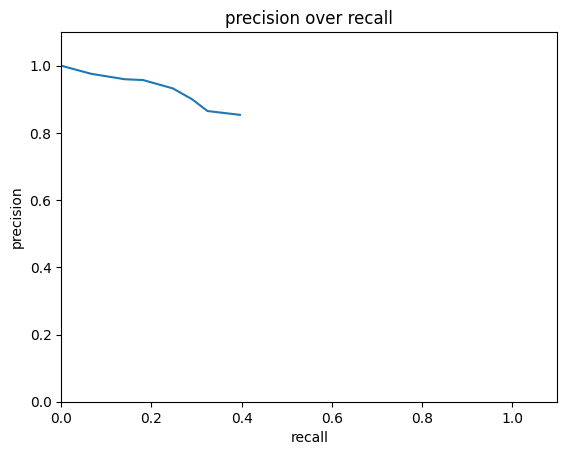

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.86it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651]


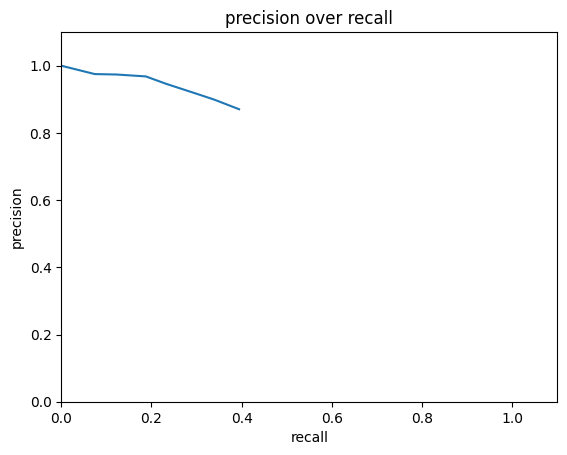

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 22.19it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249]


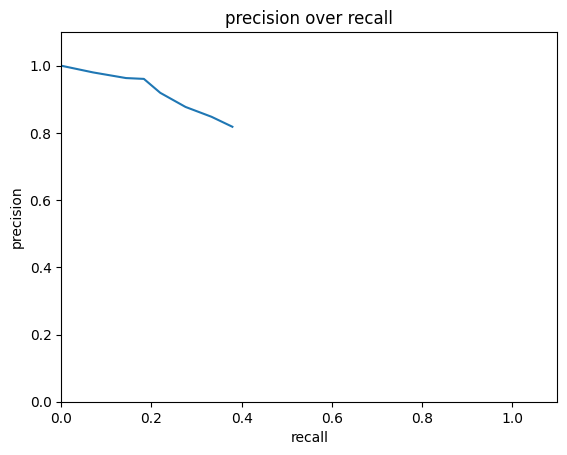

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642]


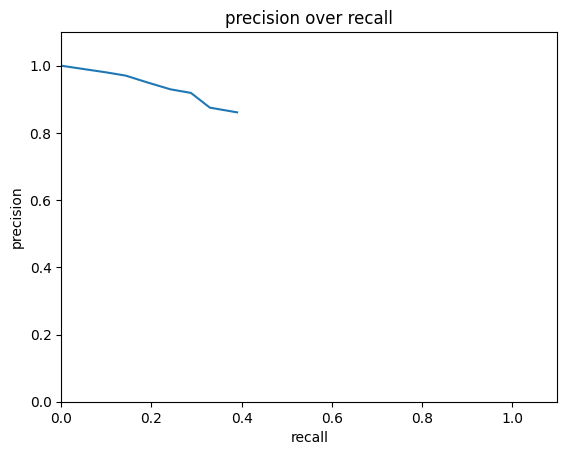

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.81it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415]


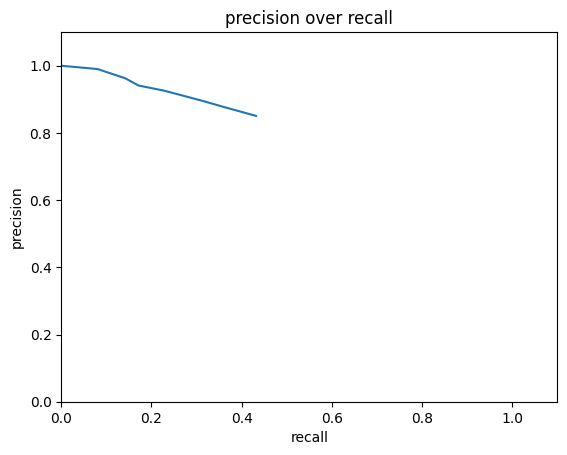

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.80it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769]


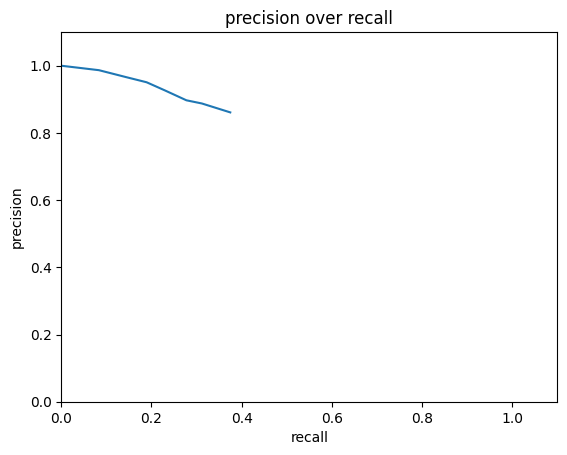

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.60it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455]


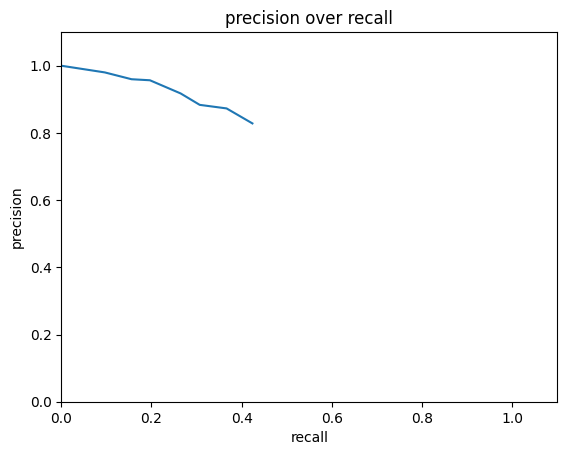

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.23it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818]


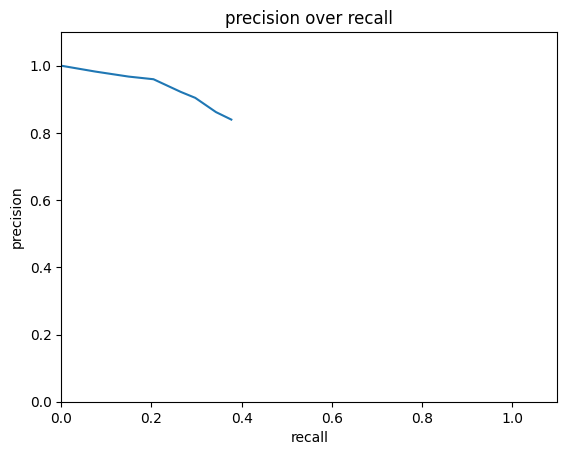

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.70it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315]


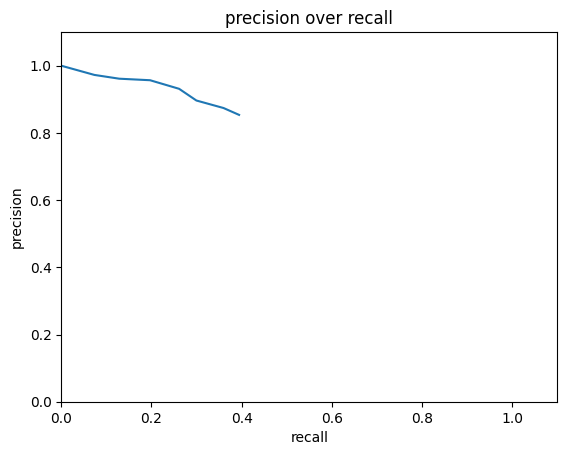

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.94it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506]


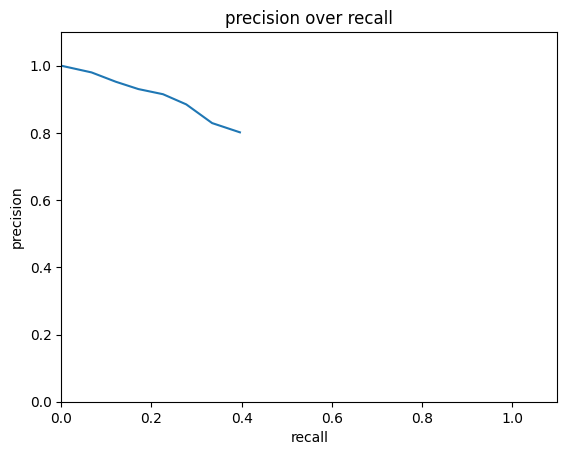

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 20.38it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094]


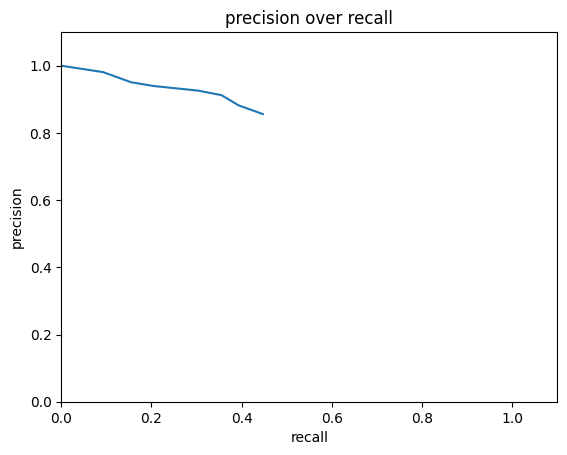

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.33it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054]


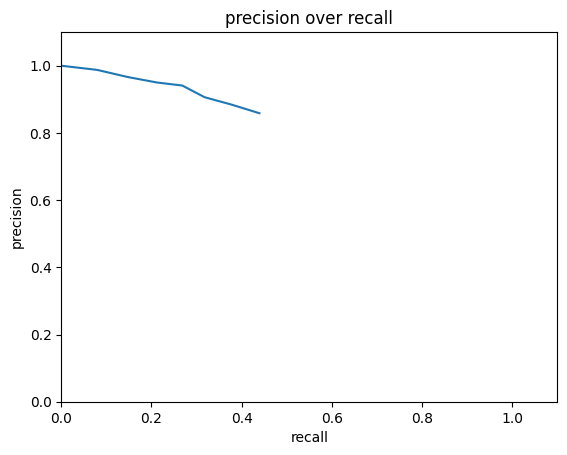

-----Pruning iteration 3/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.62it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694]


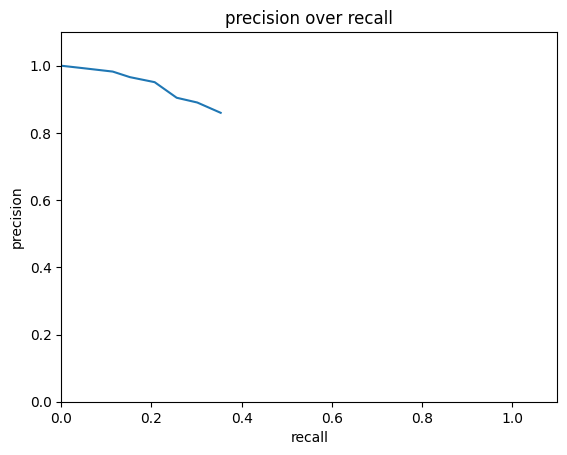

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.30it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067]


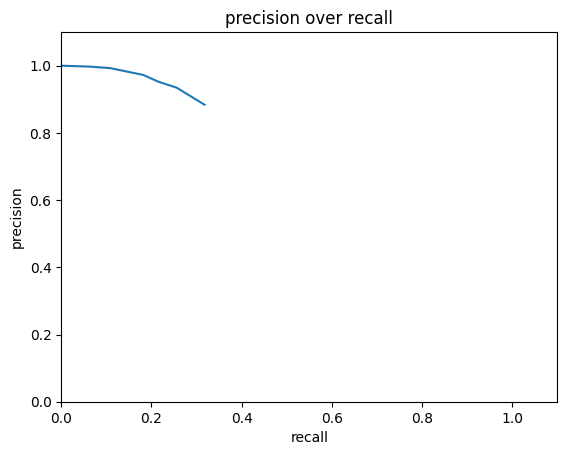

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.27it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156]


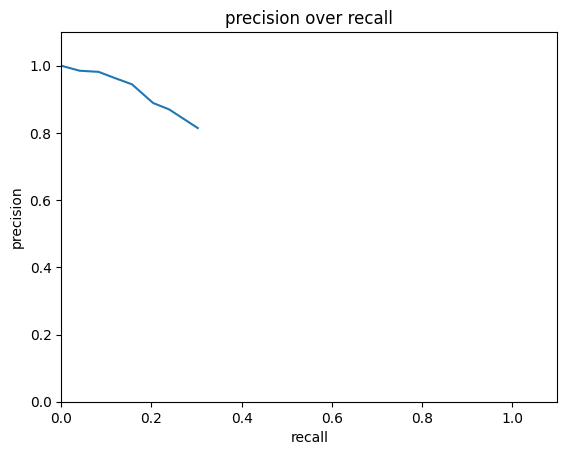

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.22it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237]


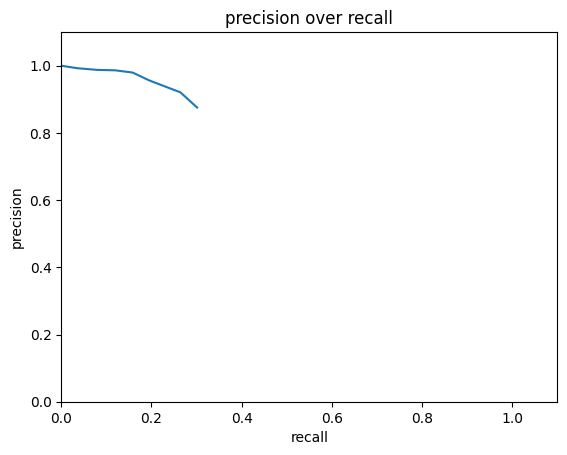

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.29it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224]


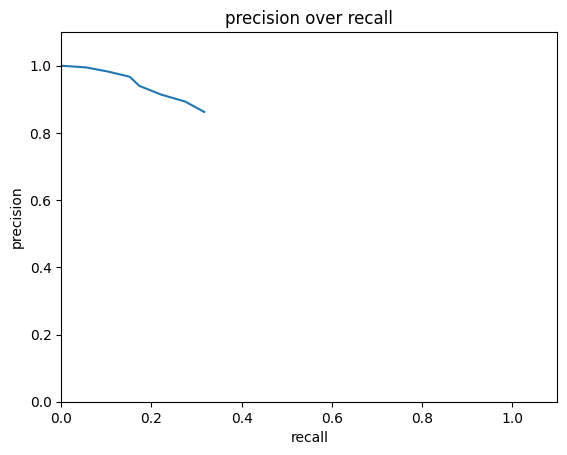

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.29it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657]


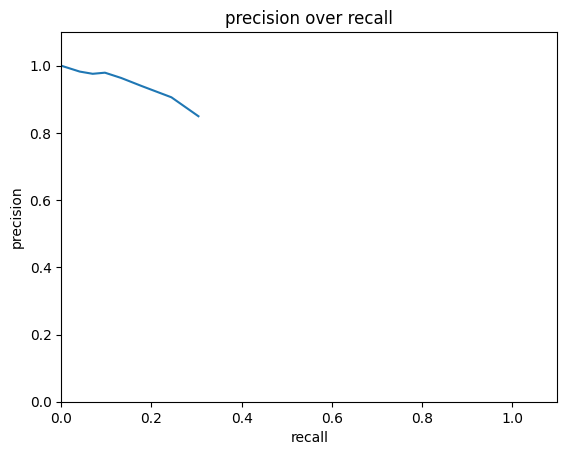

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 28.72it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603]


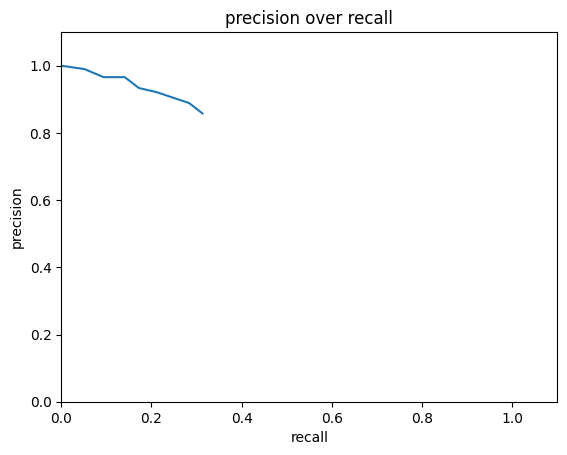

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.77it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293]

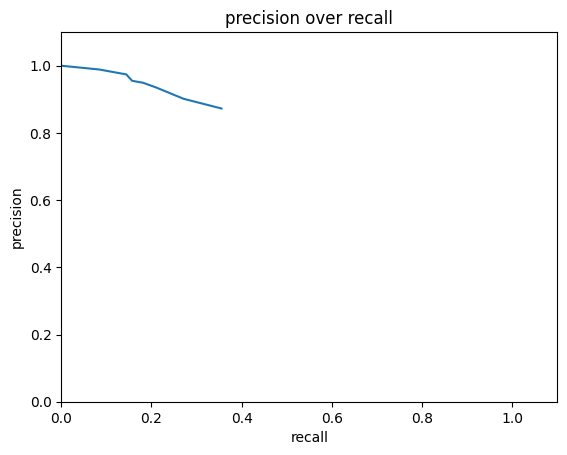

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.01it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

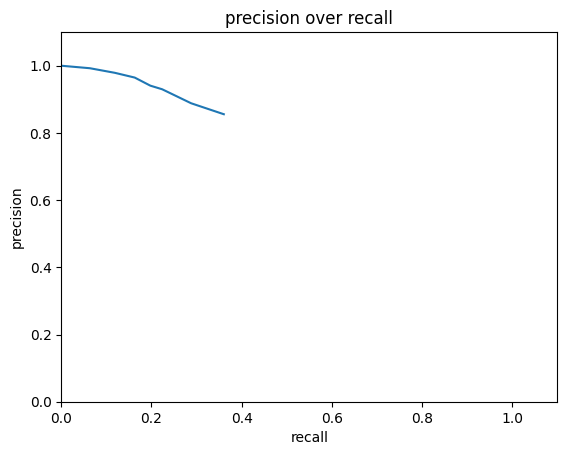

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.39it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

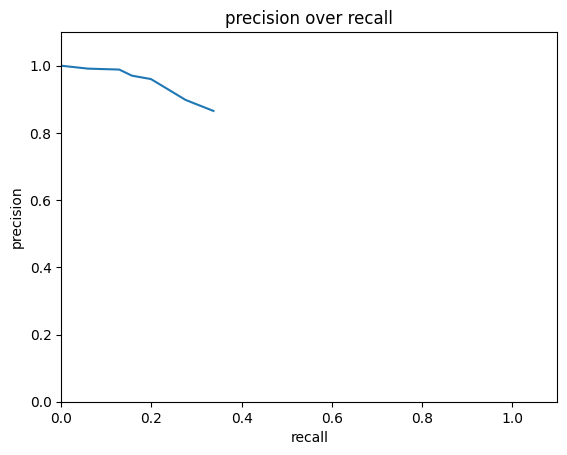

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.32it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

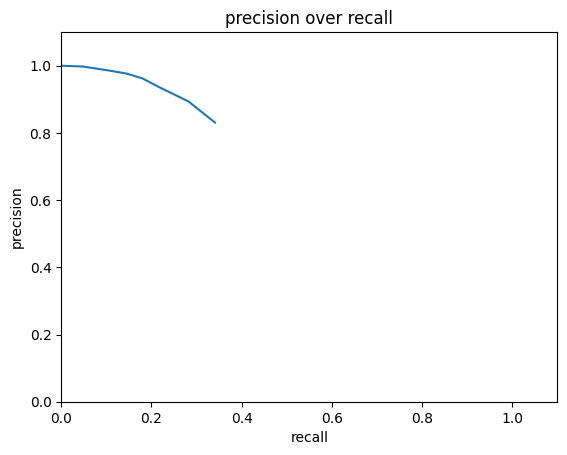

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.72it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

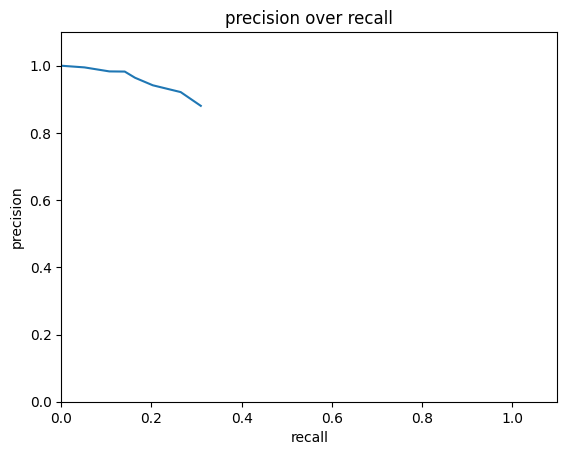

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.11it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

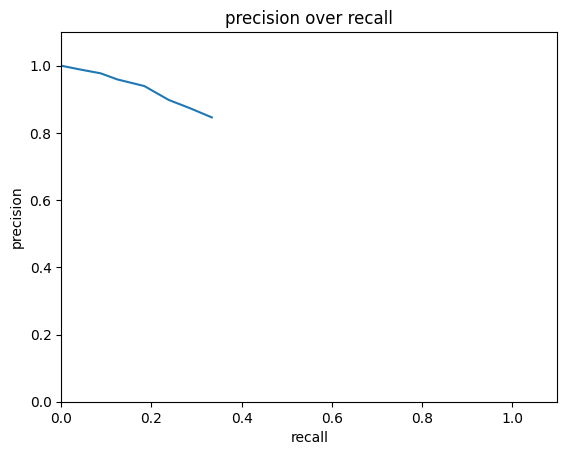

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.96it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

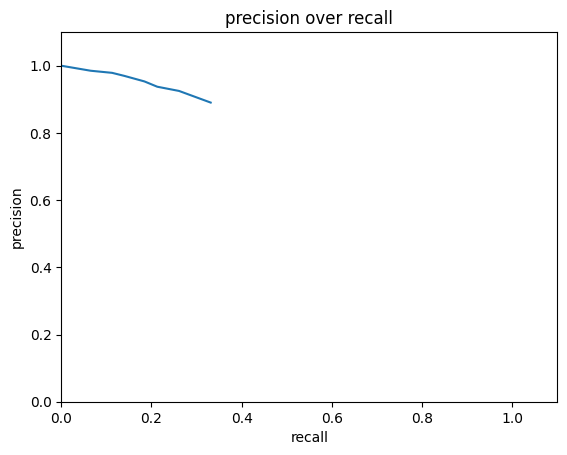

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.43it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

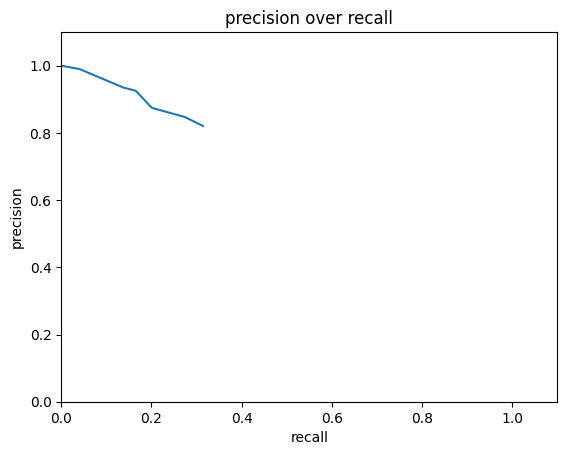

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 33.20it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

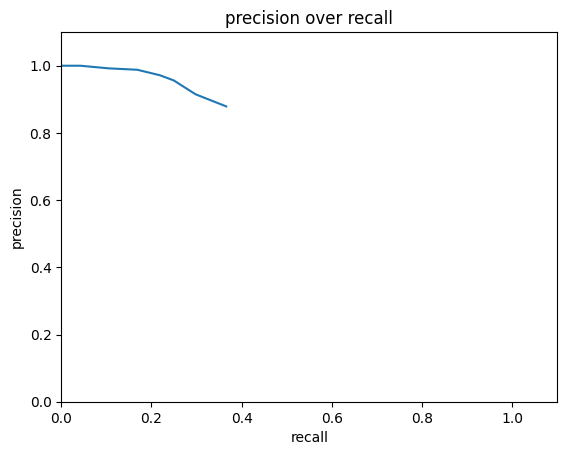

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.43it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

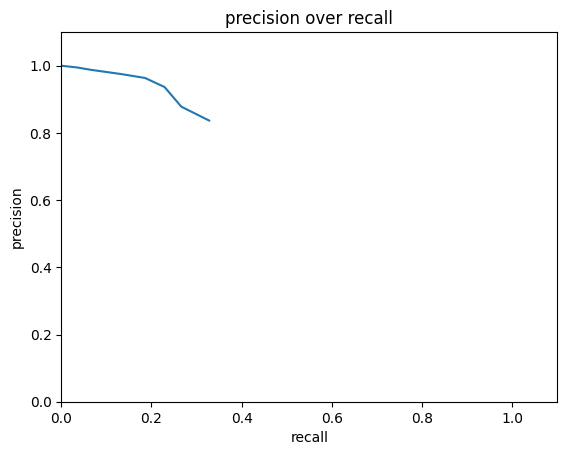

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.20it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

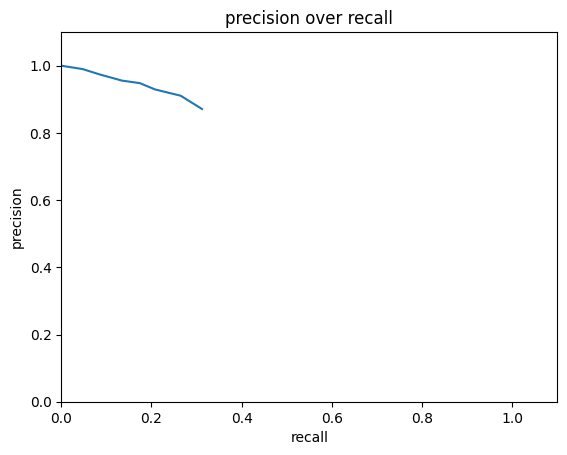

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 33.85it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

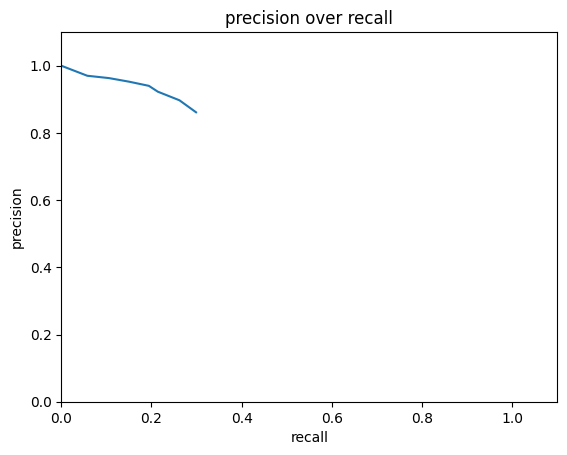

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.11it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

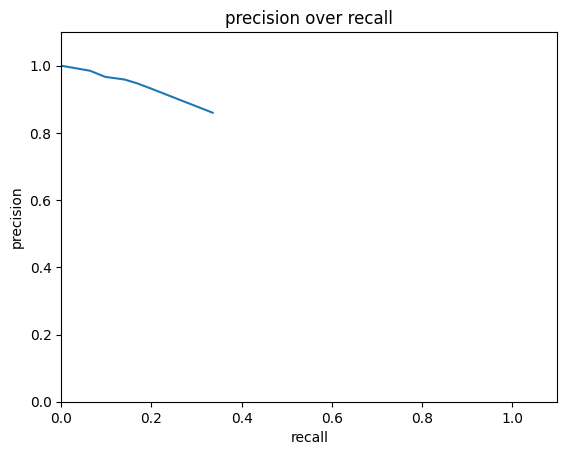

-----Pruning iteration 4/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.38it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

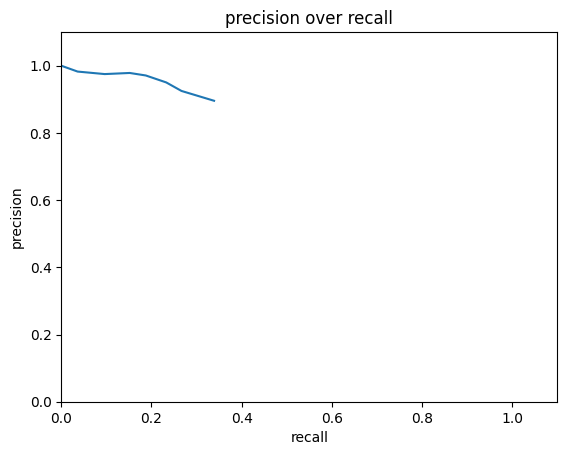

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.23it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

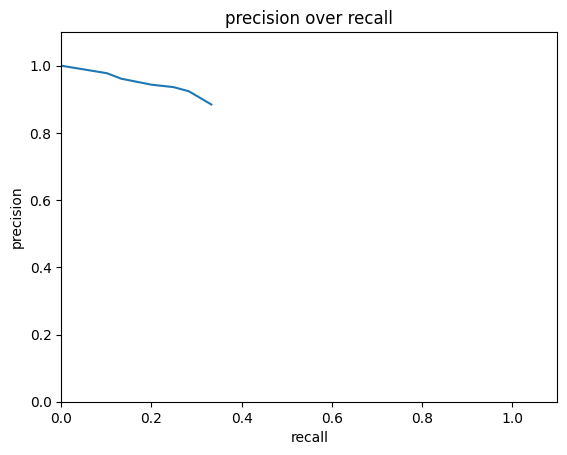

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.02it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

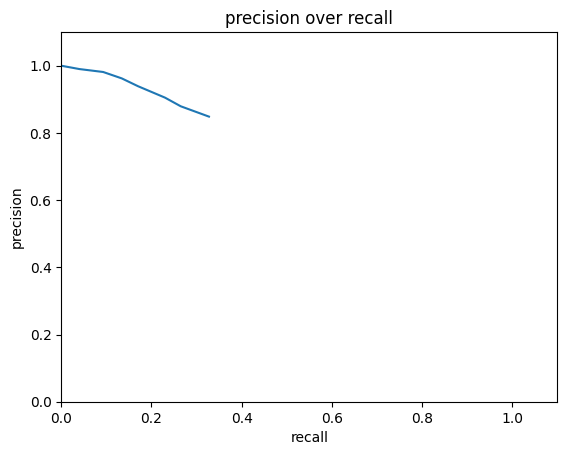

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.62s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 35.24it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

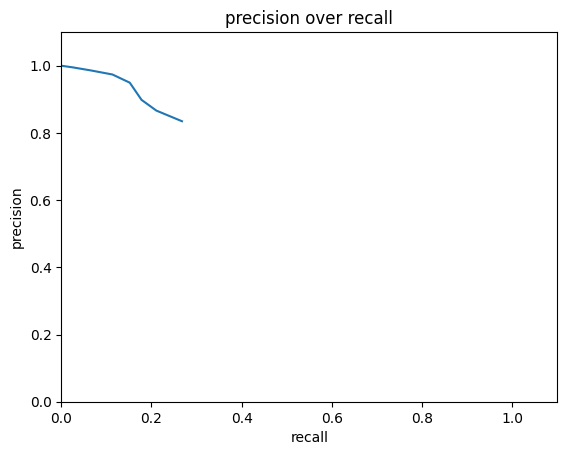

Training started.


100%|██████████| 17/17 [00:26<00:00,  1.58s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.85it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

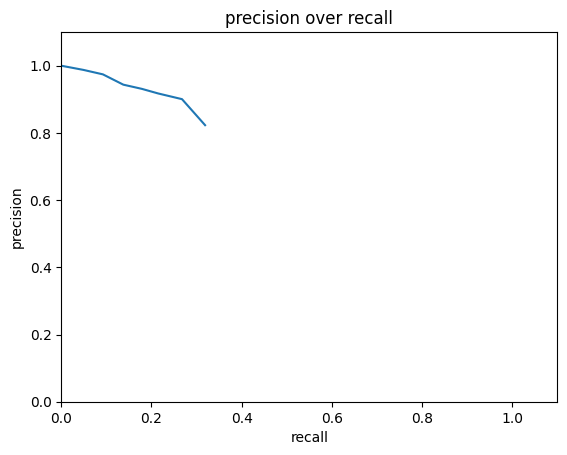

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.63s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.14it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

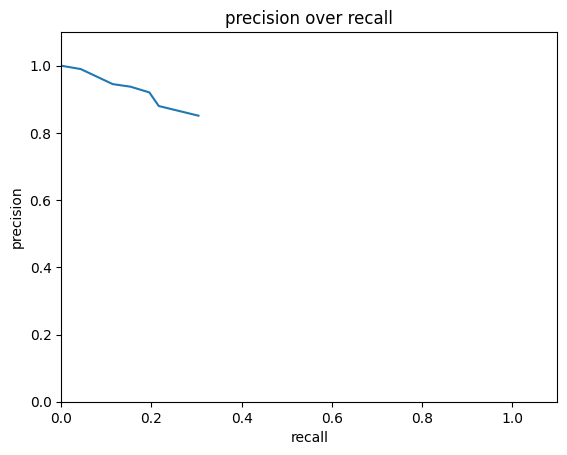

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.12it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

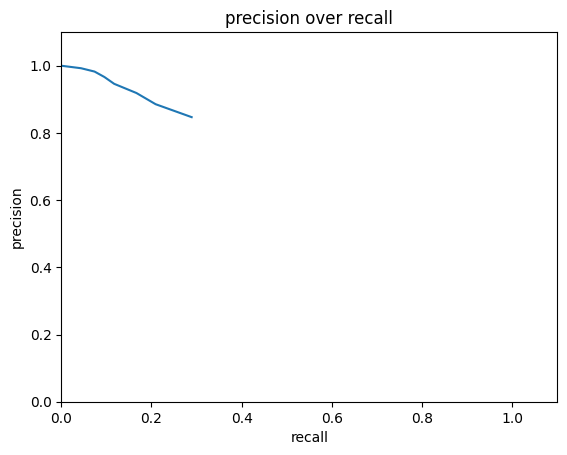

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.85s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.31it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

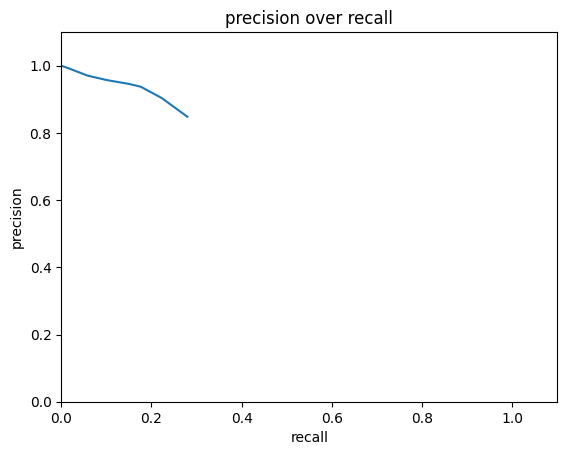

Training started.


100%|██████████| 17/17 [00:34<00:00,  2.03s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.78it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

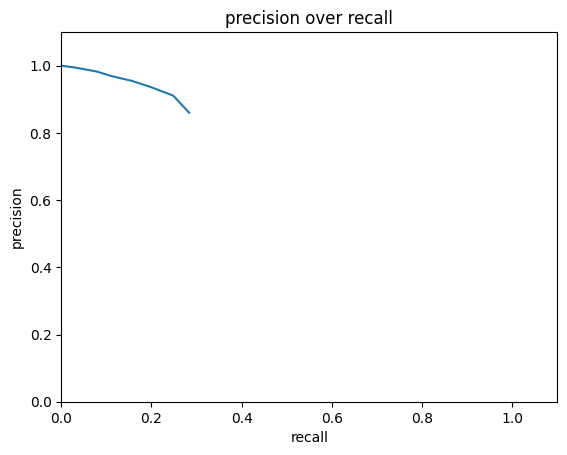

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.22s/it]


Validation started.


100%|██████████| 200/200 [00:10<00:00, 18.55it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

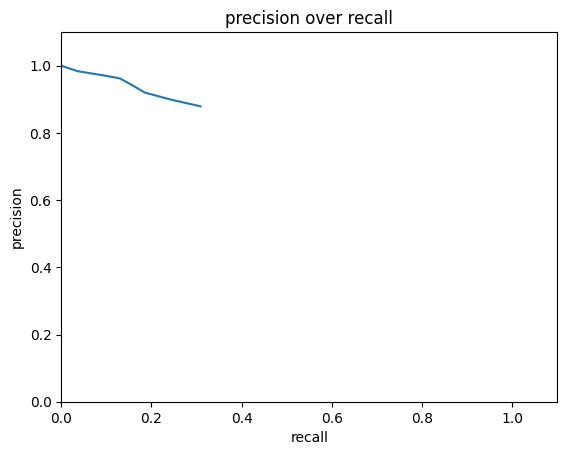

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.60s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.28it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

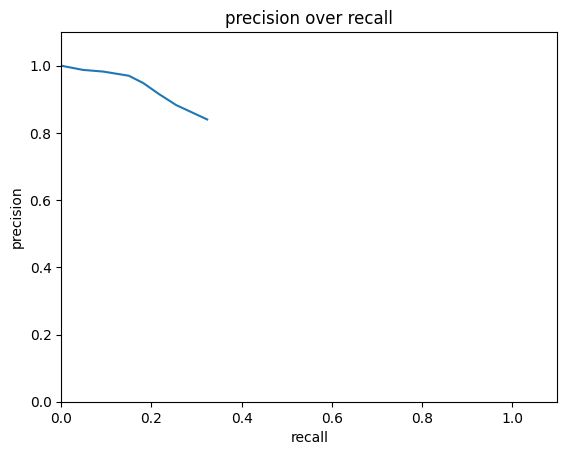

Training started.


100%|██████████| 17/17 [00:34<00:00,  2.01s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.31it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

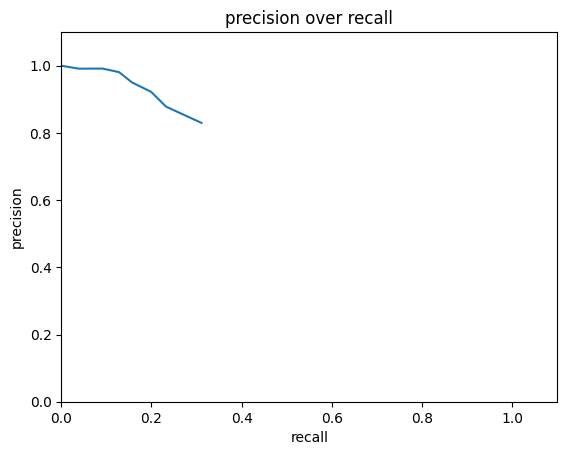

Training started.


100%|██████████| 17/17 [00:39<00:00,  2.33s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.58it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

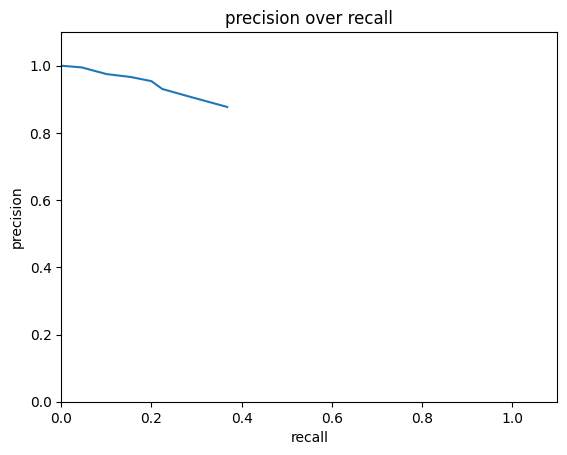

Training started.


100%|██████████| 17/17 [00:36<00:00,  2.17s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.89it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

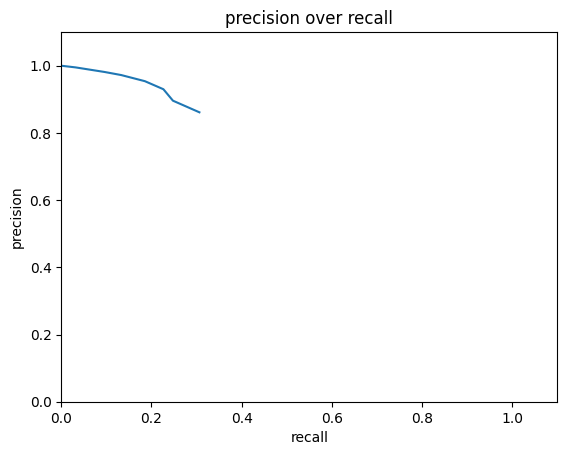

Training started.


100%|██████████| 17/17 [00:33<00:00,  1.97s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.34it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

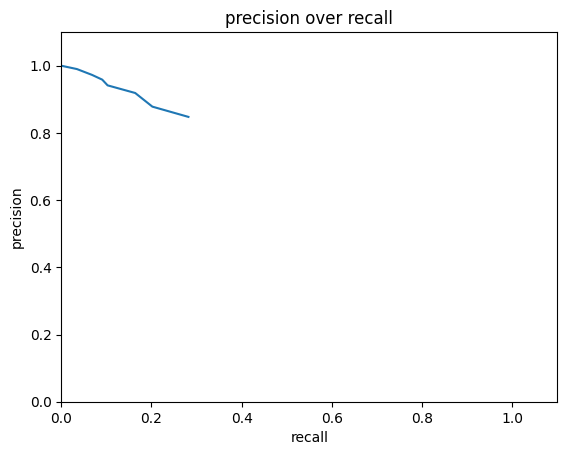

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.85s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.40it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

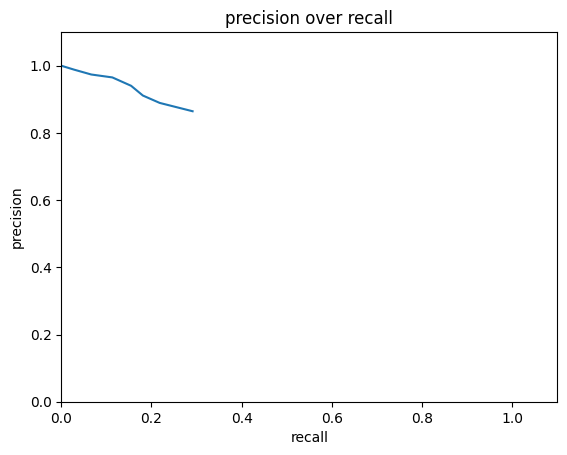

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 28.88it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

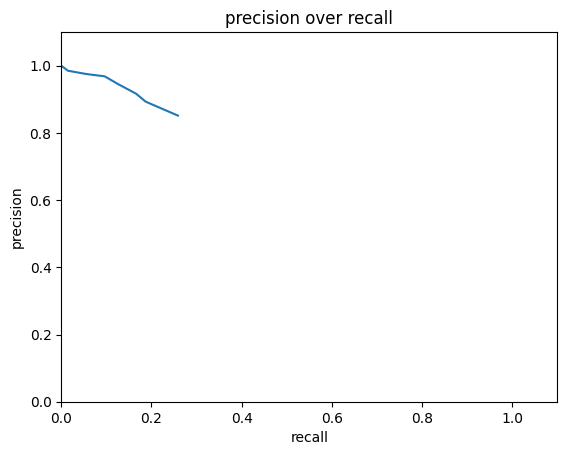

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.15it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

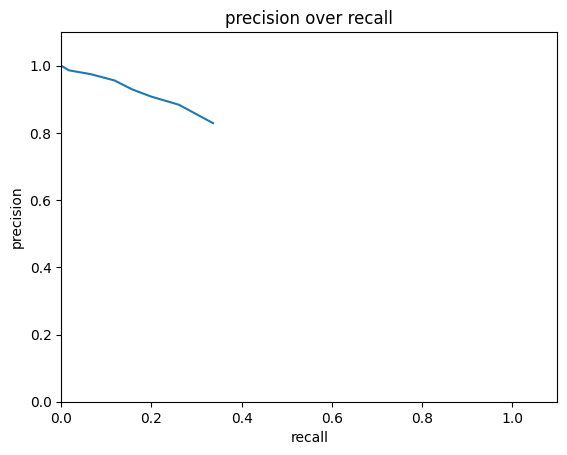

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.94it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

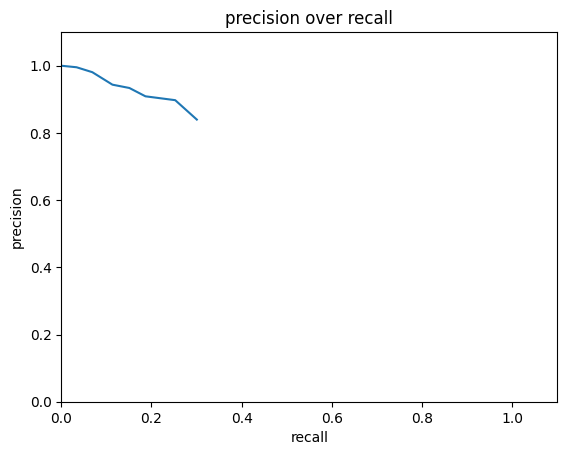

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.72it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

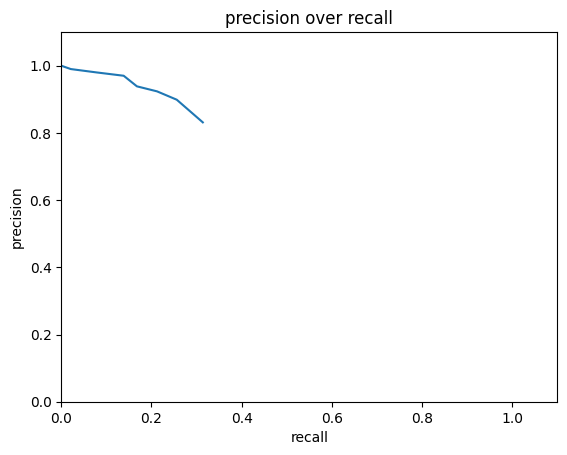

-----Pruning iteration 5/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.29it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

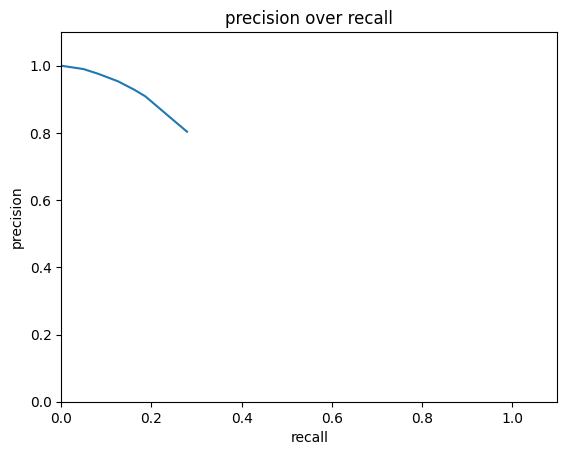

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 33.31it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

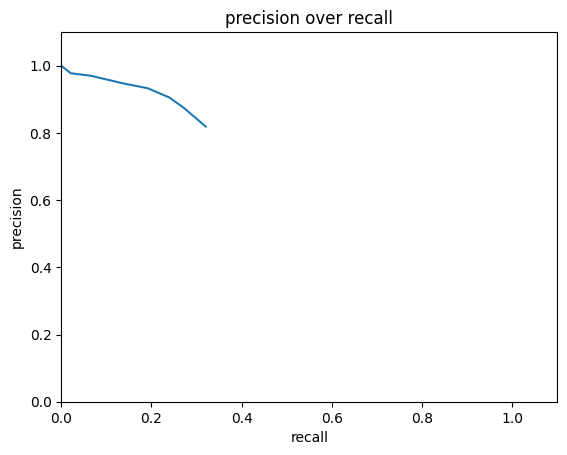

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.24it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

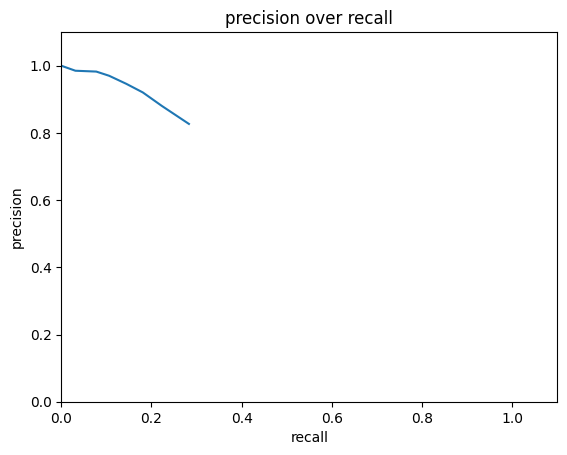

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.52it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

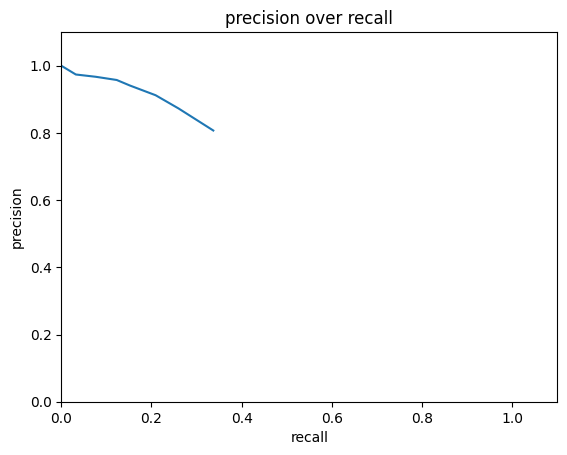

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.06it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

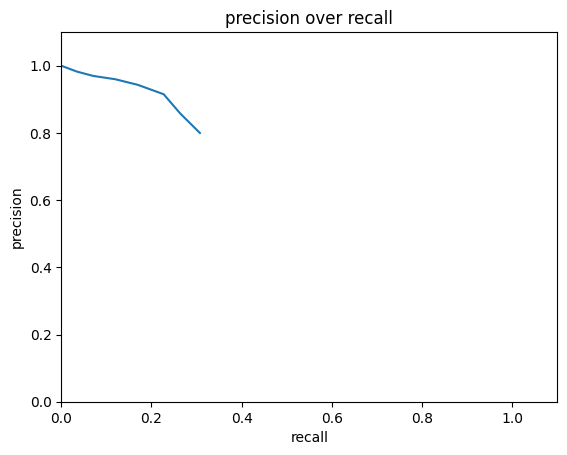

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.41it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

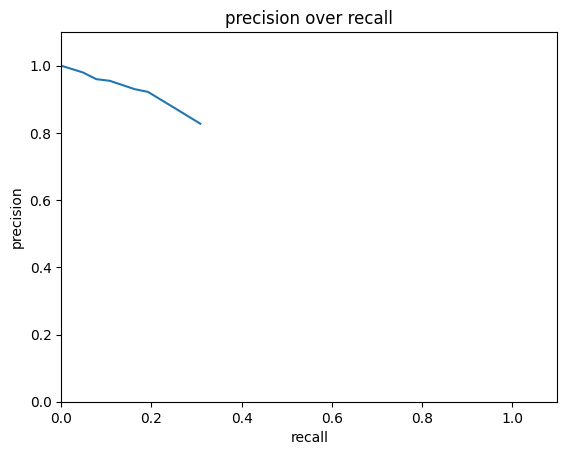

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.99it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

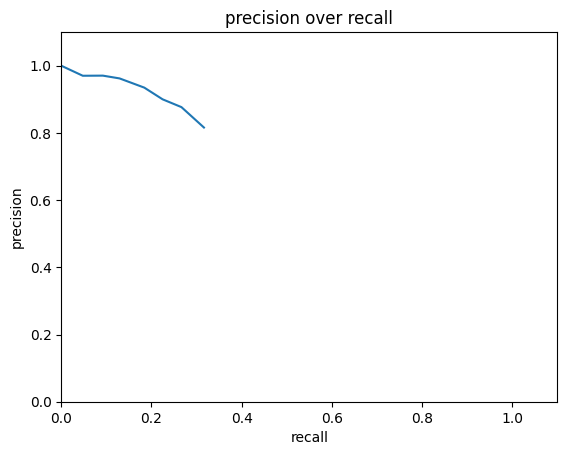

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 37.52it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

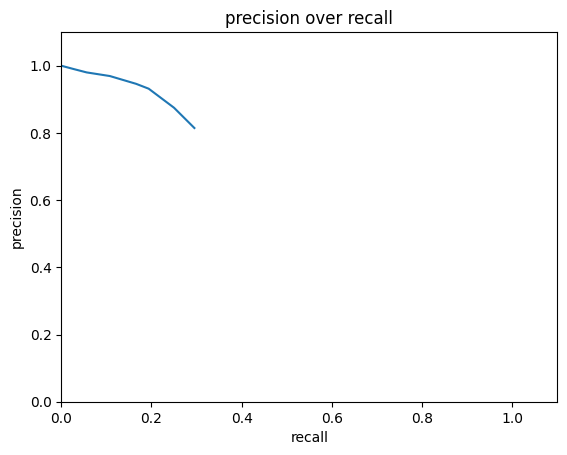

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.97it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

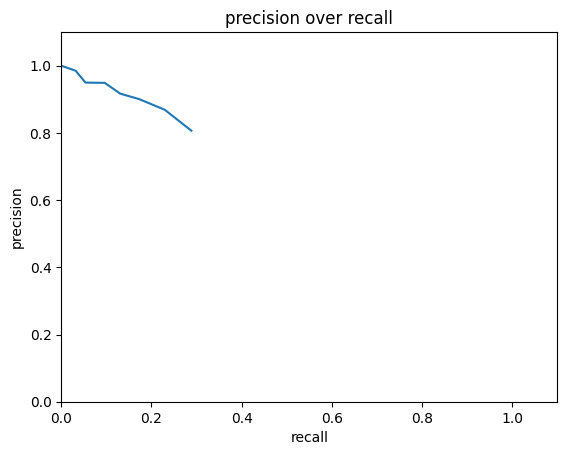

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.74it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

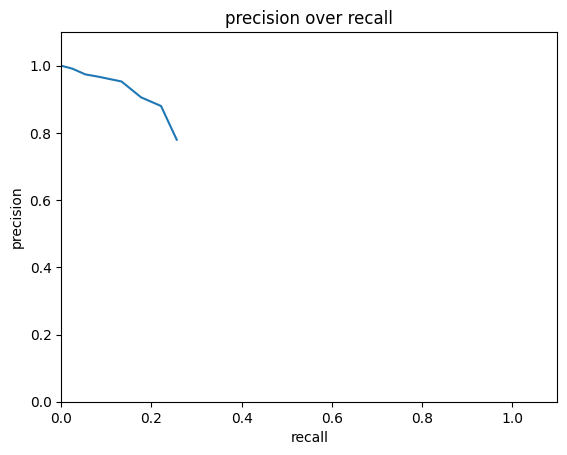

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.92it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

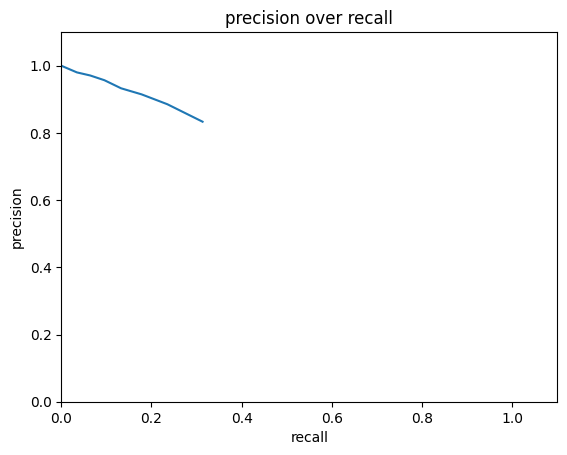

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.18it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

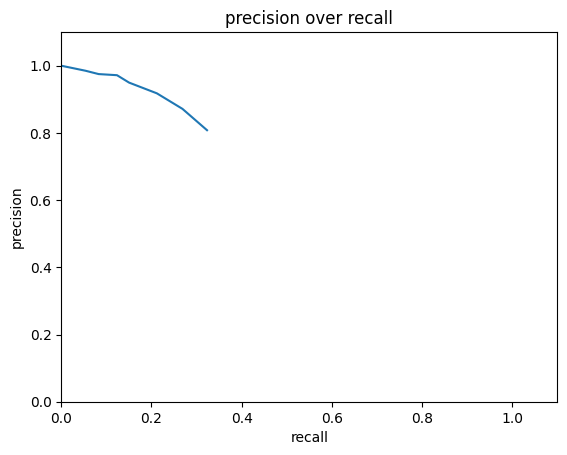

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.46it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

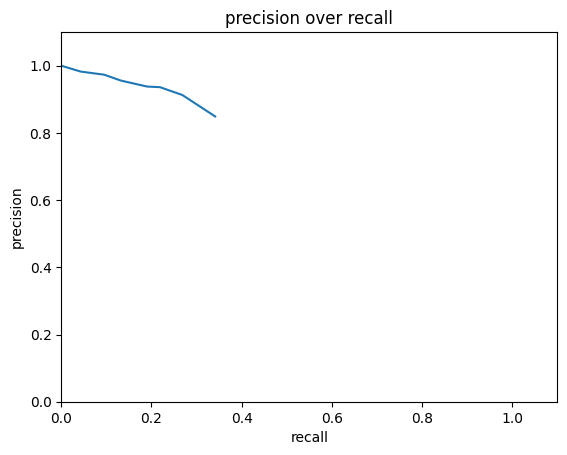

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.12it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

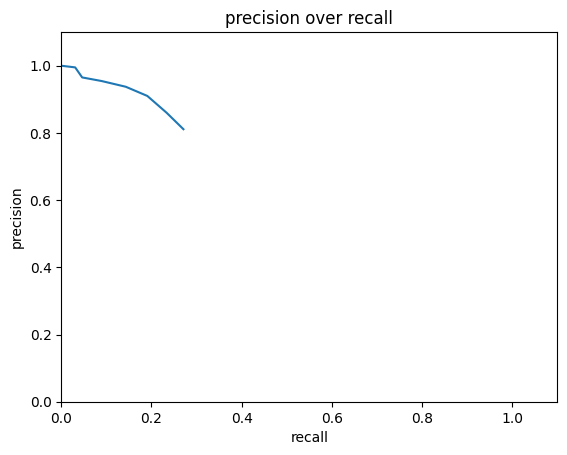

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.02it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

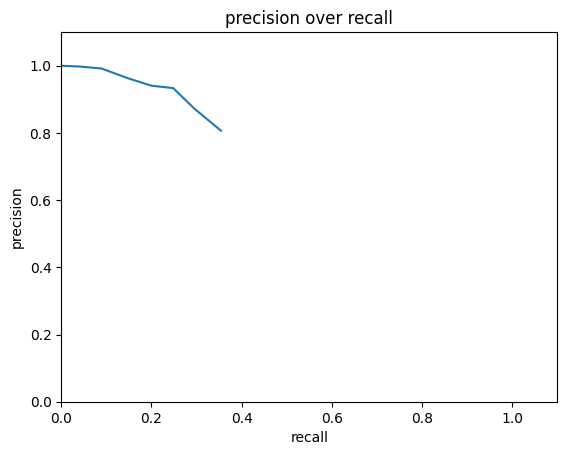

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.96it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

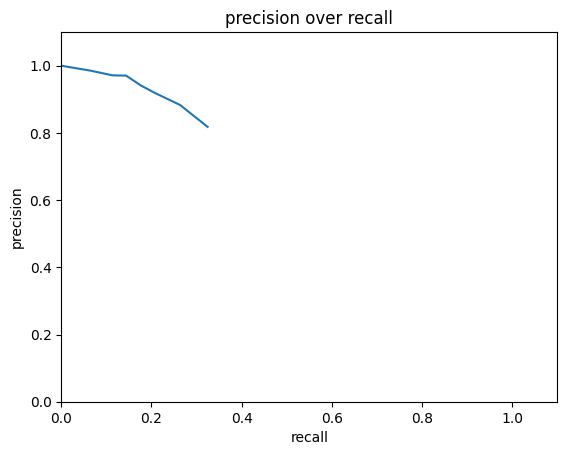

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.21it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

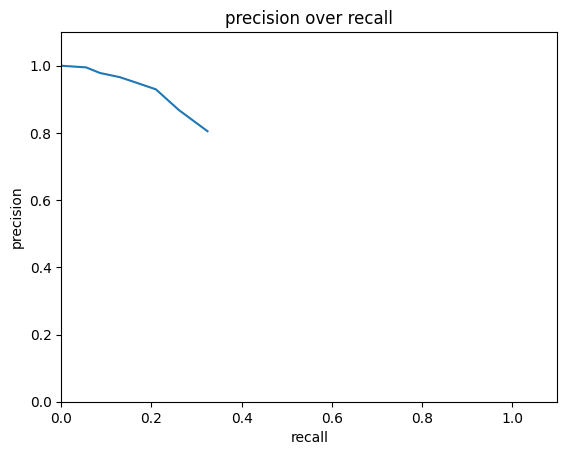

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 28.91it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

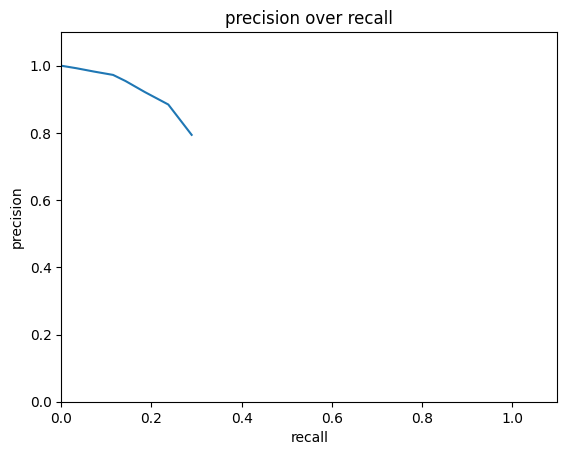

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.79it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

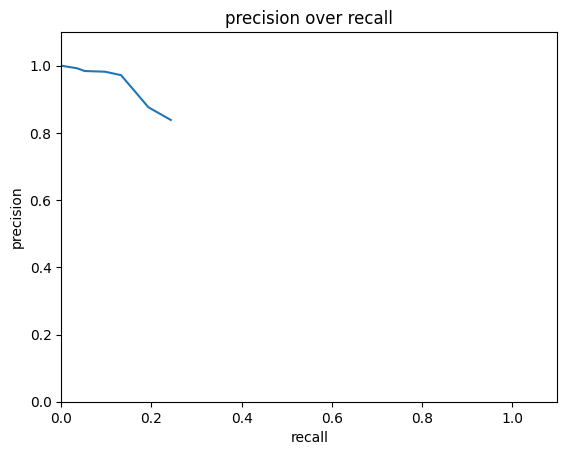

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.35it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

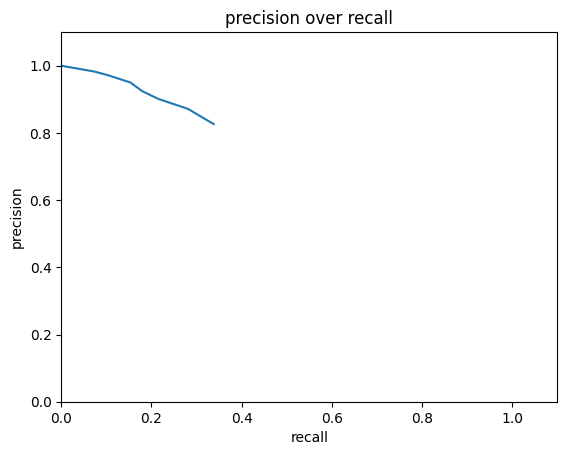

-----Pruning iteration 6/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.68it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

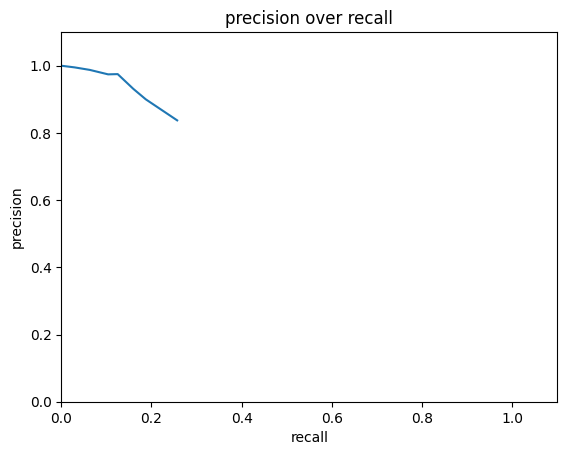

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.62it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

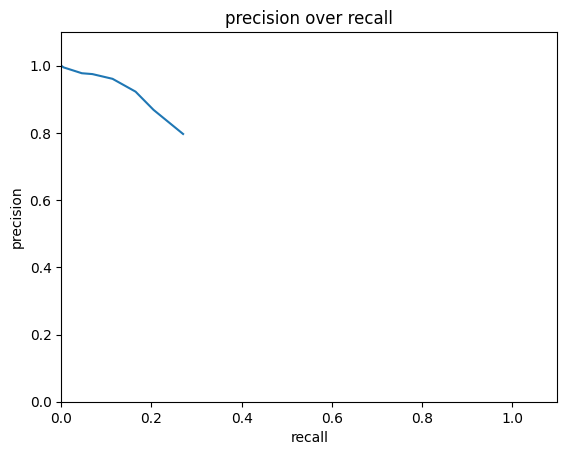

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.10it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

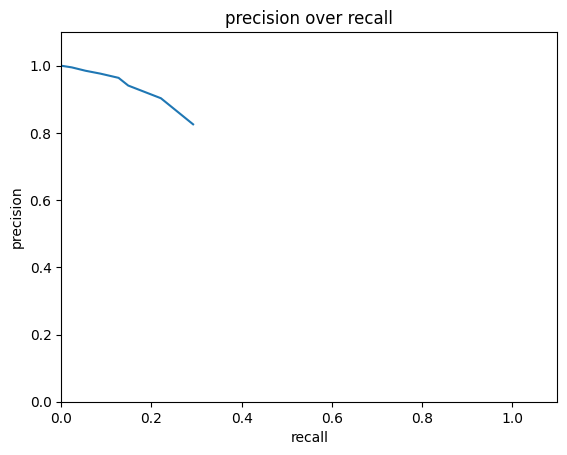

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.39it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

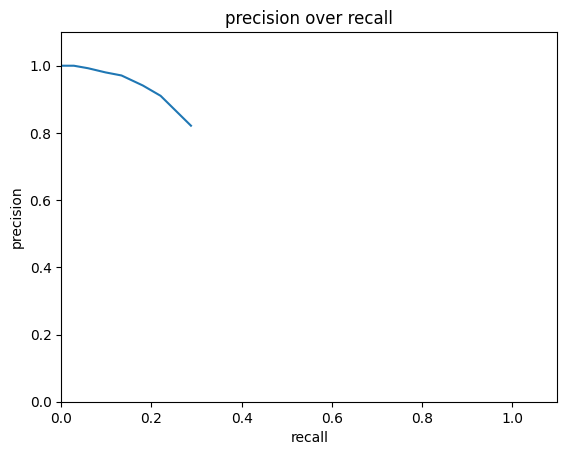

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.36it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

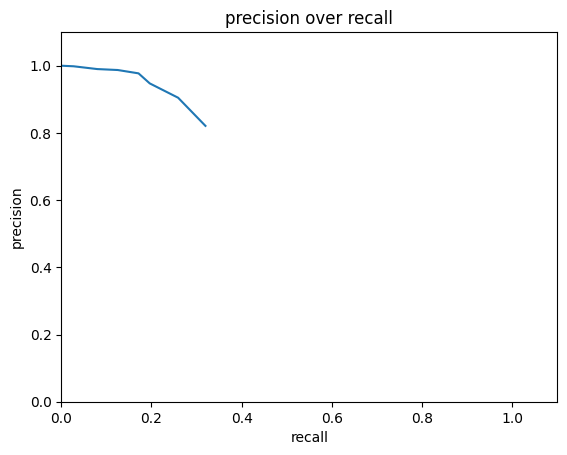

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.28it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

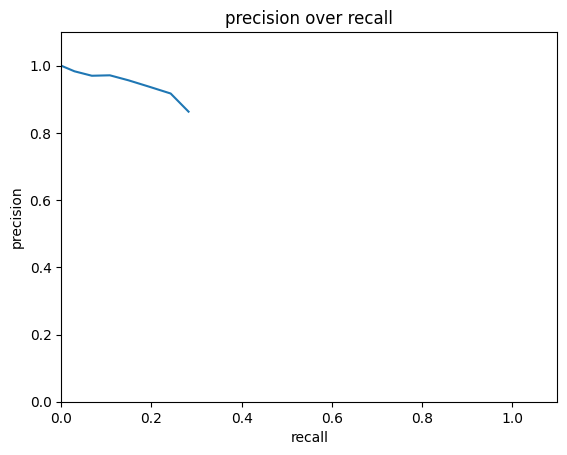

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.53it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

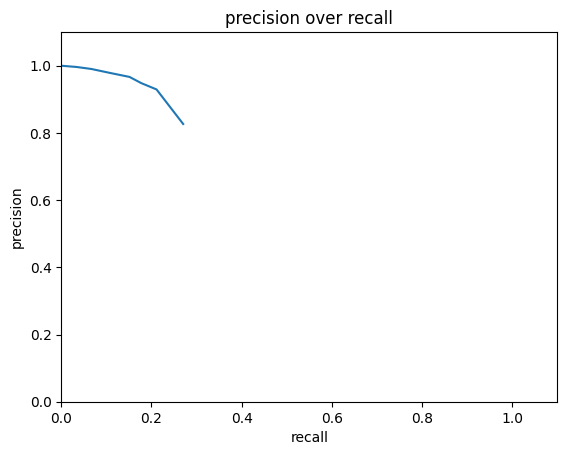

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.88it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

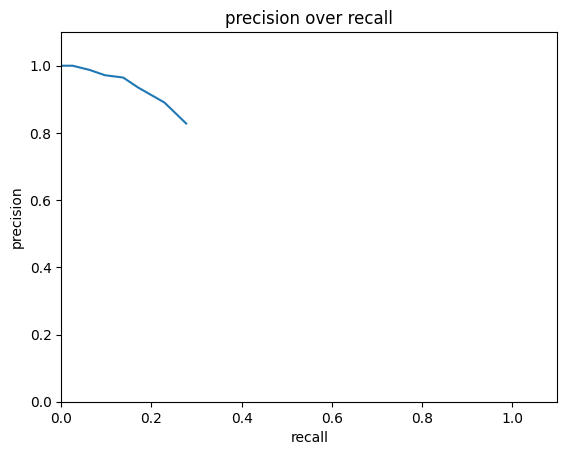

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.82it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

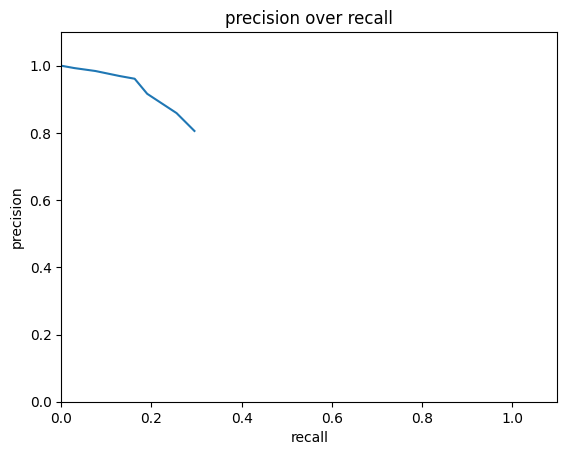

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.59it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

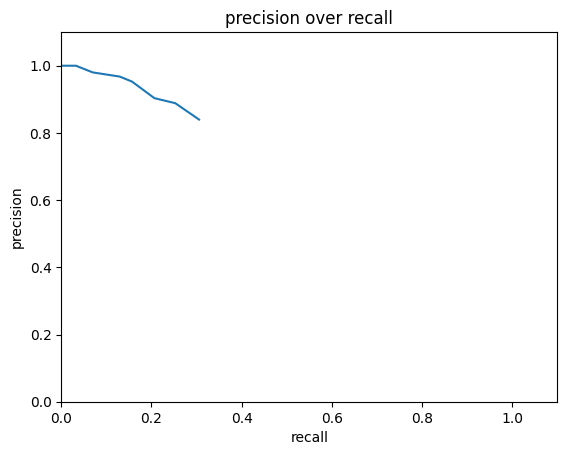

Training started.


100%|██████████| 17/17 [00:34<00:00,  2.00s/it]


Validation started.


100%|██████████| 200/200 [00:12<00:00, 16.63it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

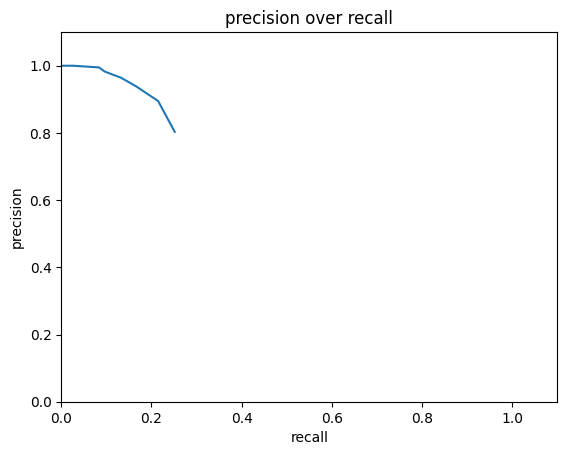

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.83s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.37it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

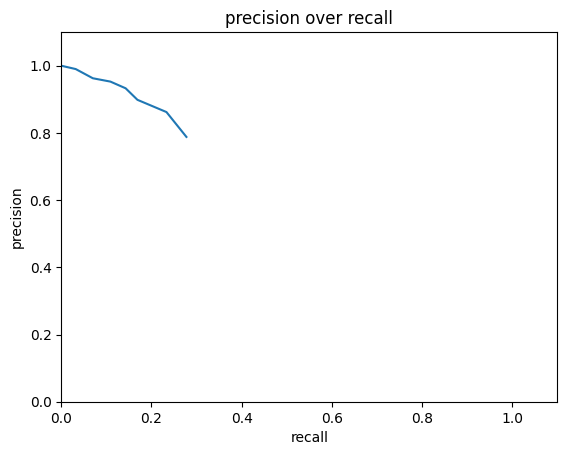

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.82it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

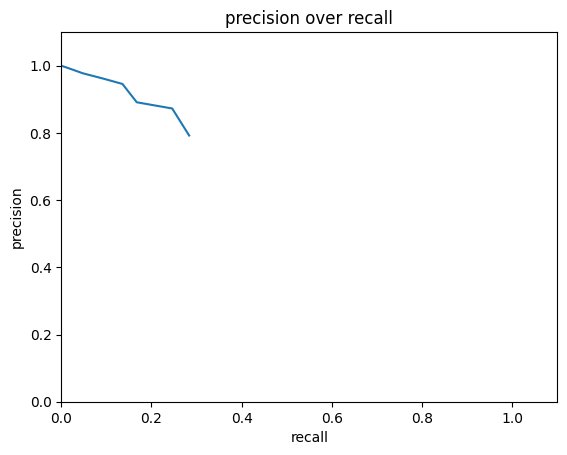

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.74it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

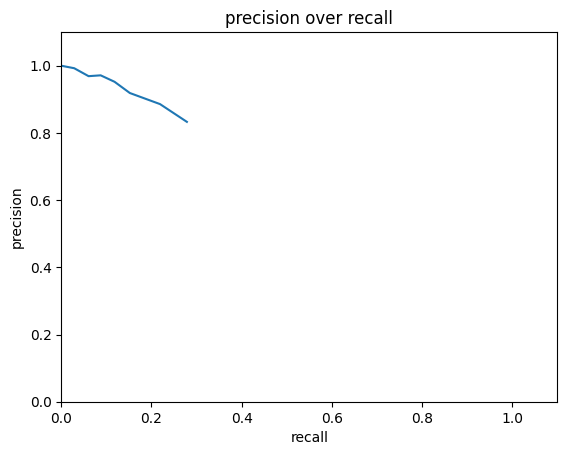

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.20it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

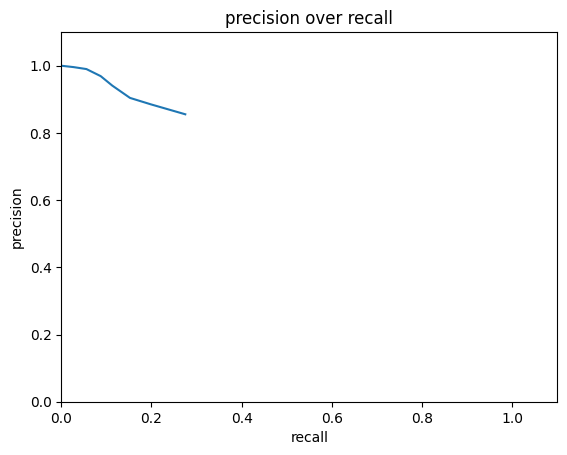

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.34it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

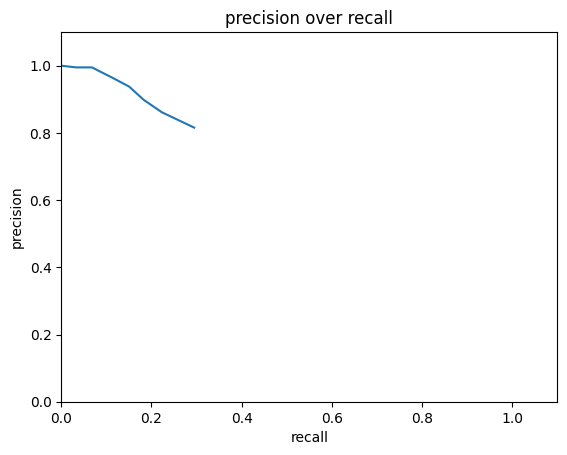

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.50it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

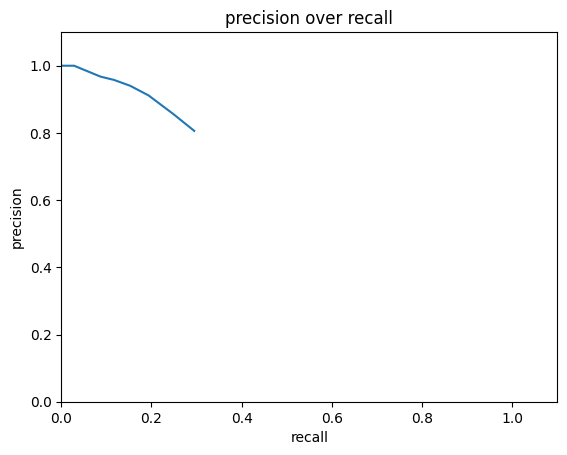

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.67s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.86it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

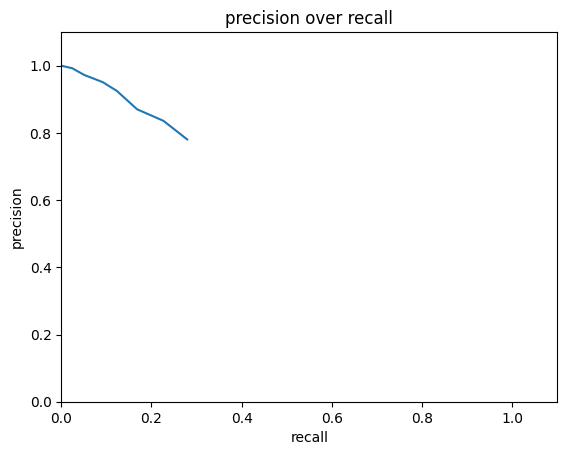

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.67s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.07it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

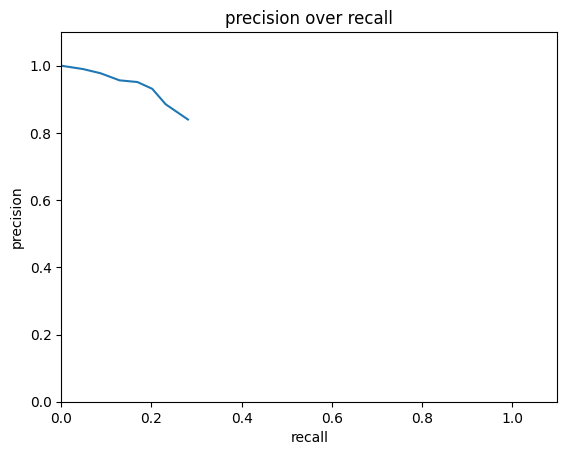

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.48it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

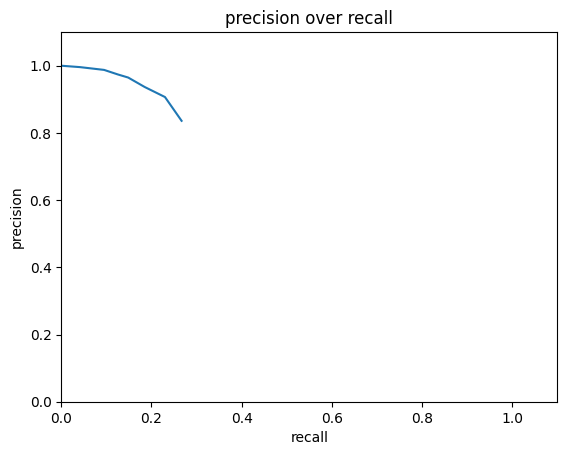

-----Pruning iteration 7/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:05<00:00, 39.45it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

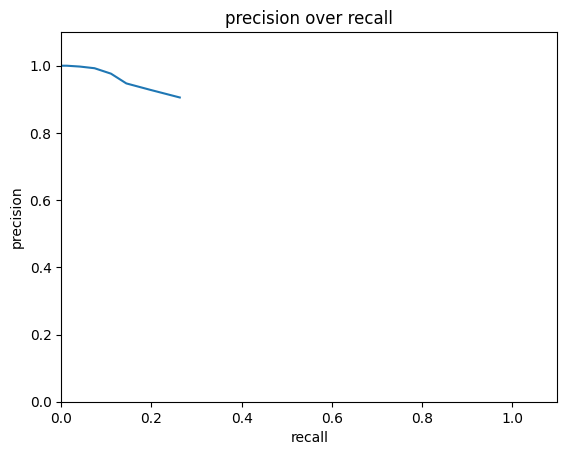

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 40.25it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

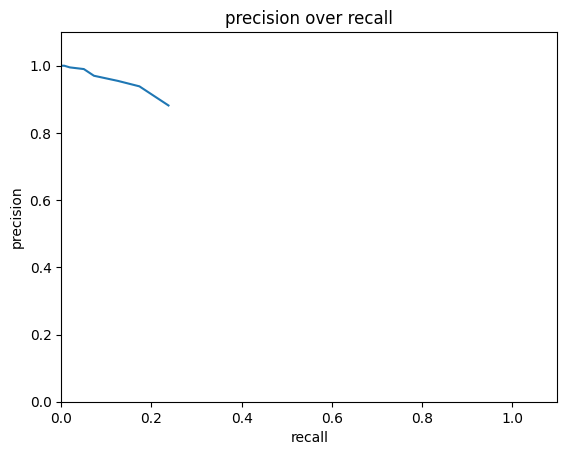

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 37.05it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

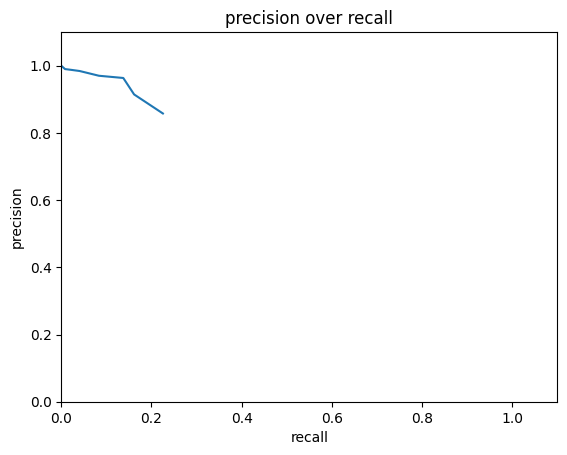

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 42.30it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

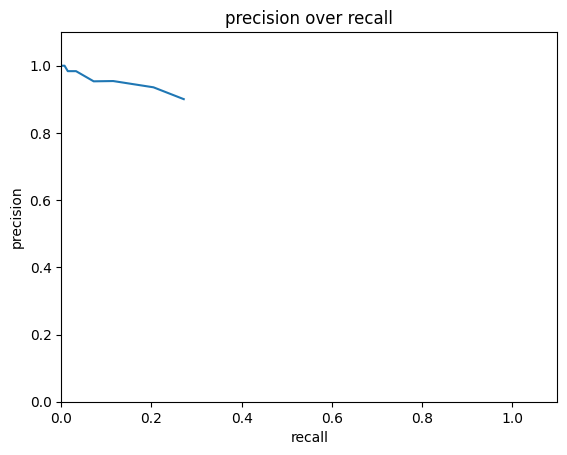

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 41.03it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

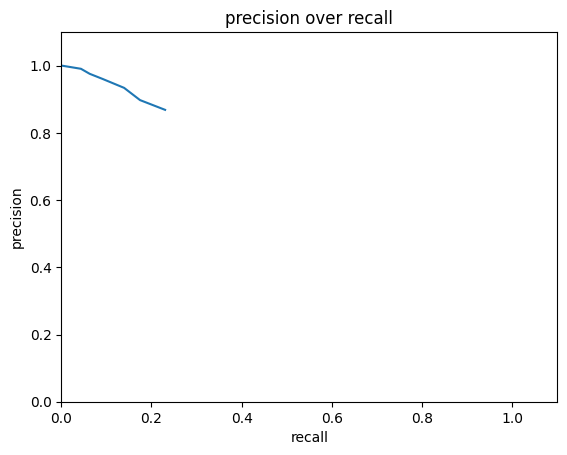

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.72it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

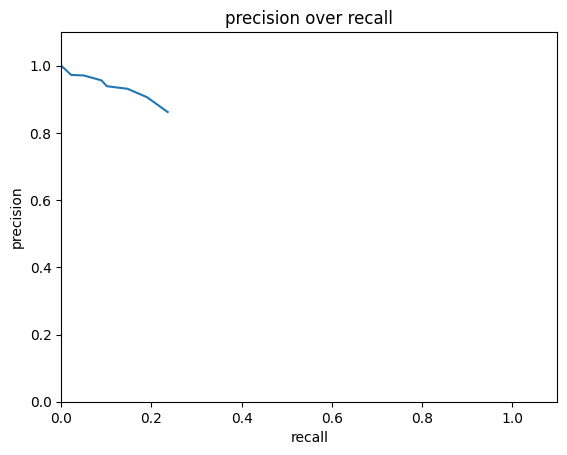

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 35.56it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

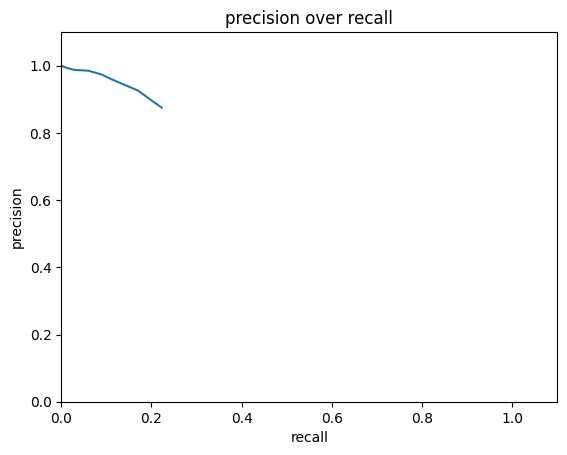

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 39.39it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

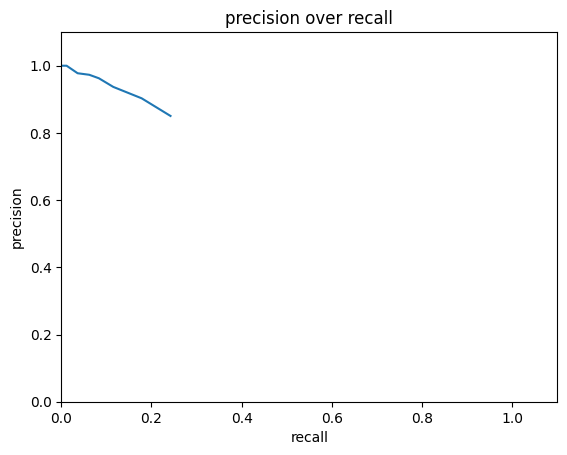

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.67s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 43.10it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

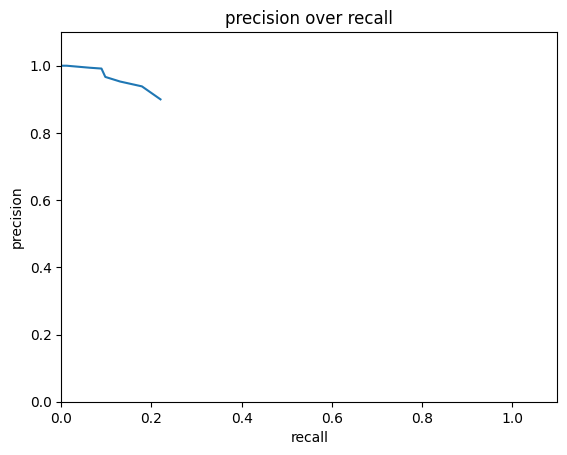

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 38.84it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

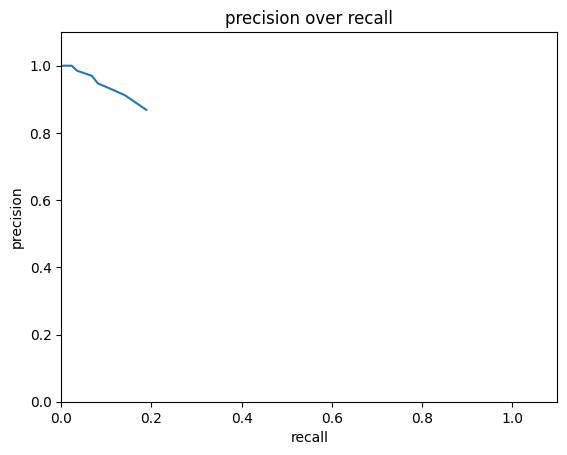

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 40.63it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

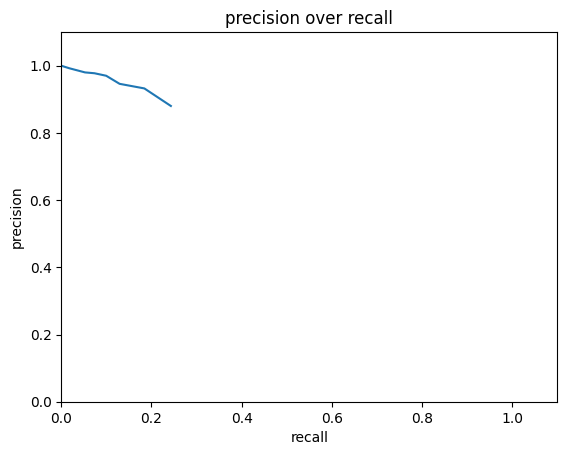

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 40.60it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

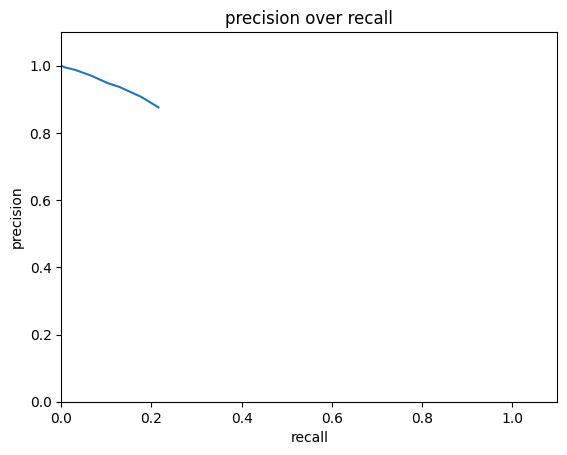

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 41.99it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

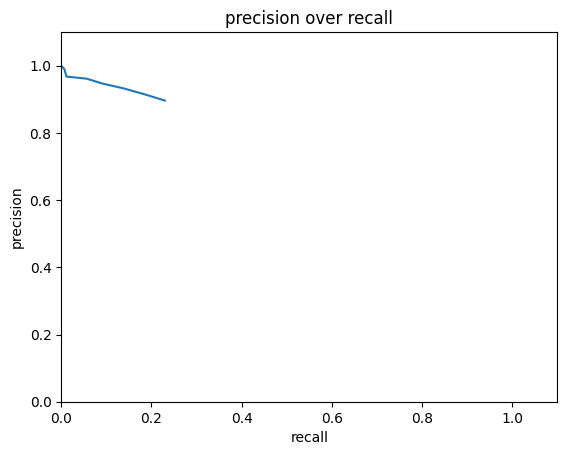

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 40.06it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

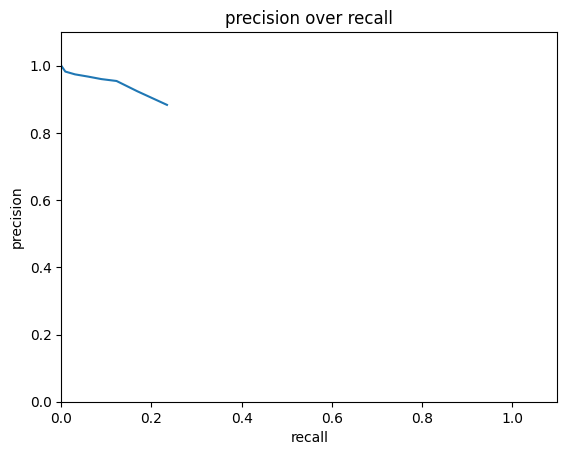

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 42.42it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

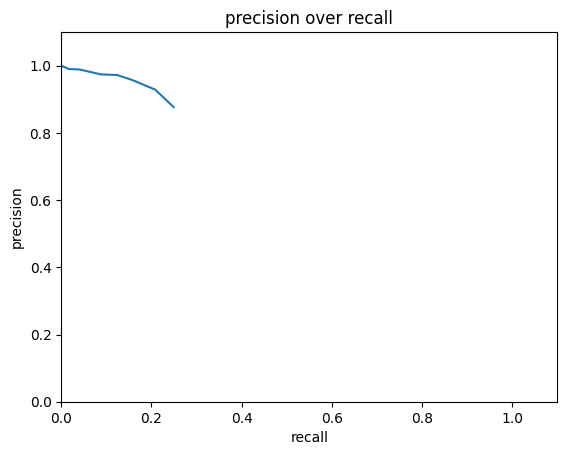

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 37.34it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

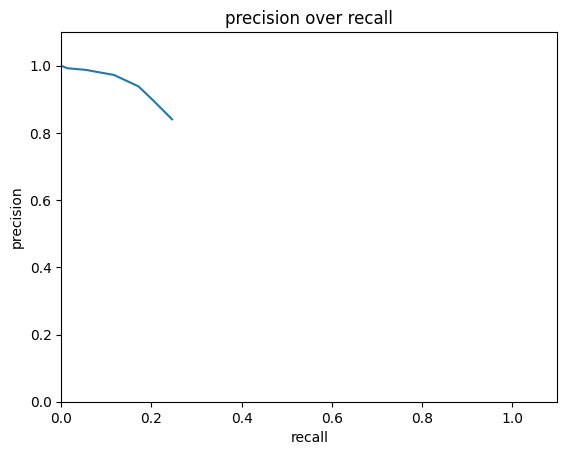

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.97it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

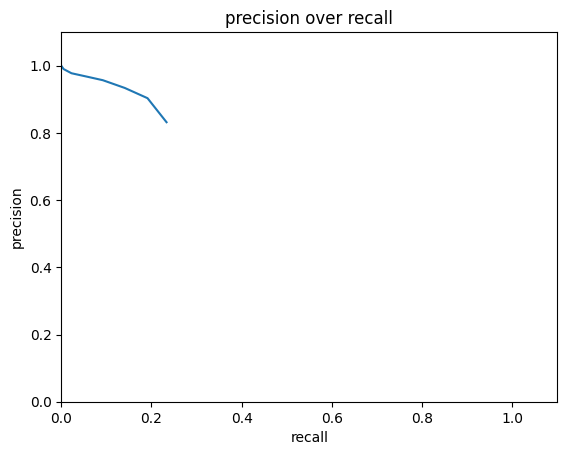

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 42.10it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

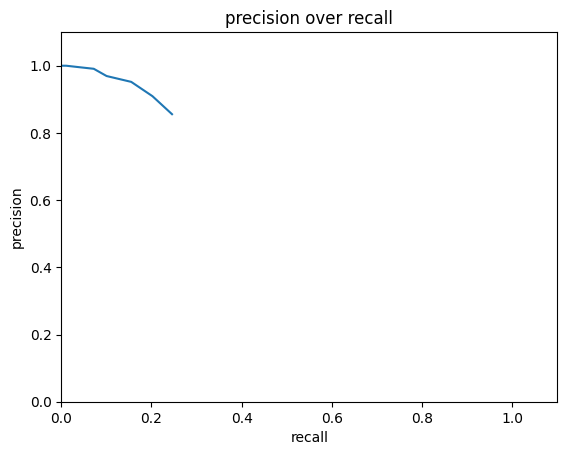

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 38.50it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

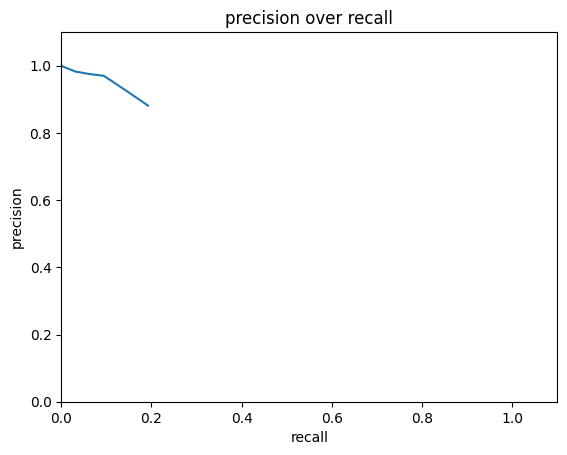

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 39.60it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

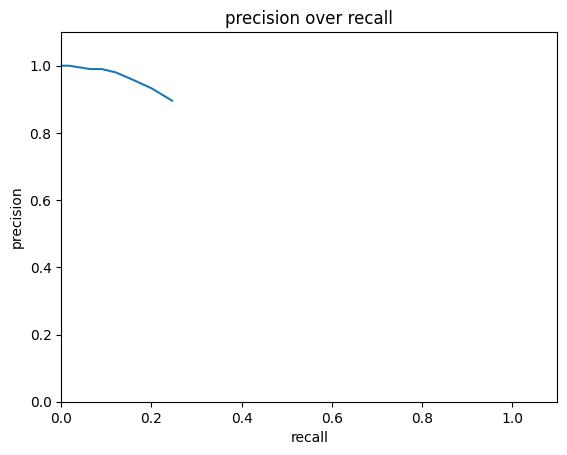

-----Pruning iteration 8/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:05<00:00, 38.38it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

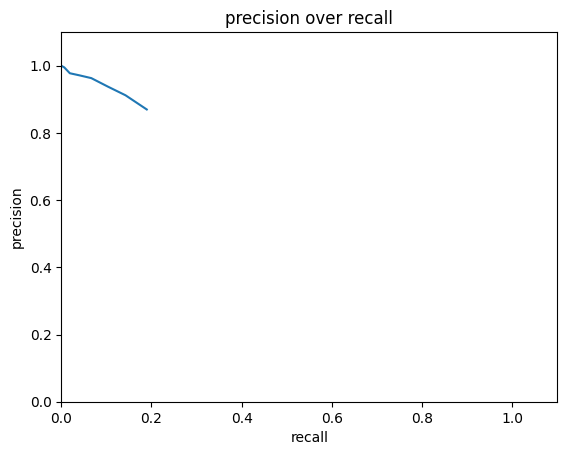

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 43.93it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

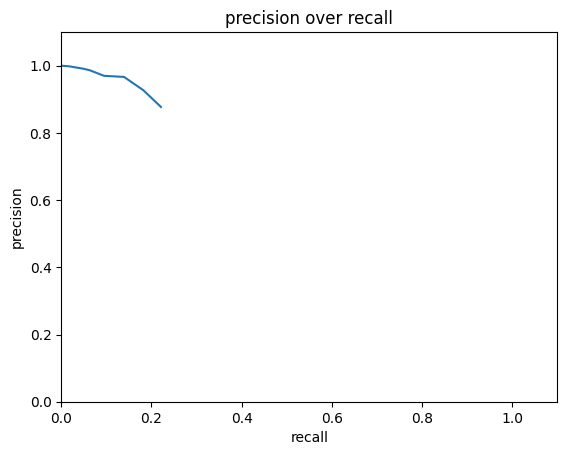

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 44.17it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

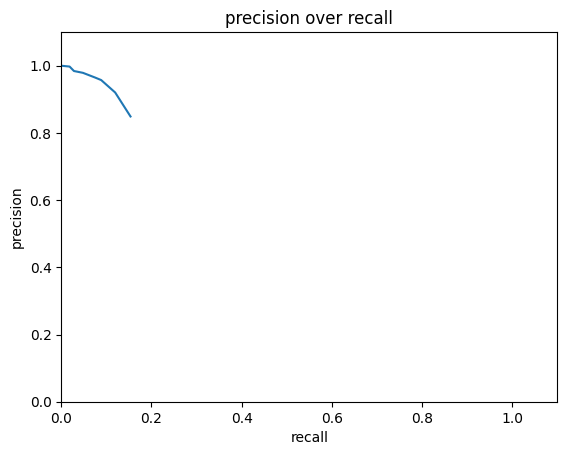

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.09it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

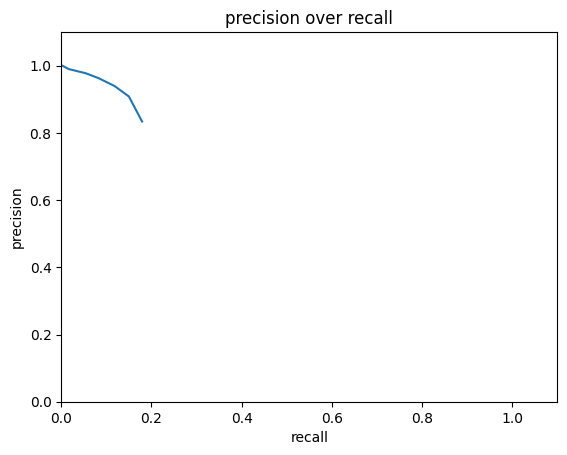

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.87it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

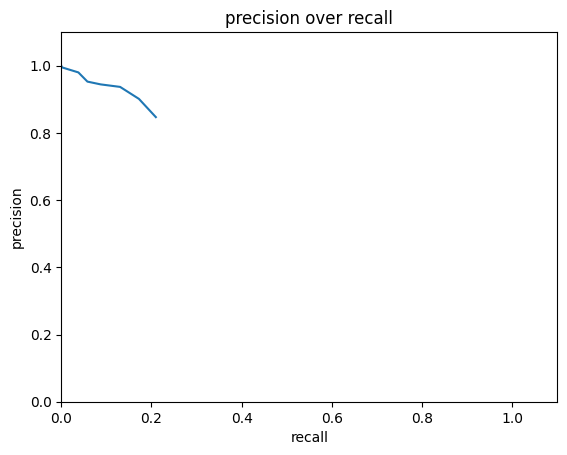

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 40.58it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

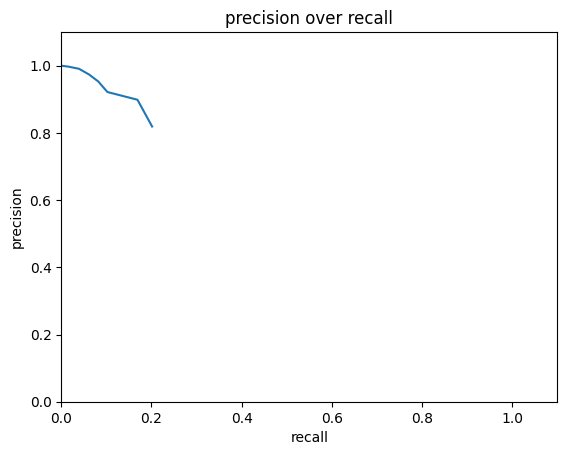

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 40.48it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

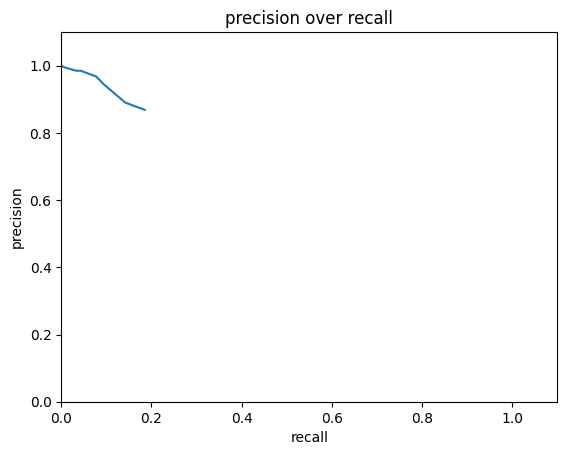

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 39.47it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

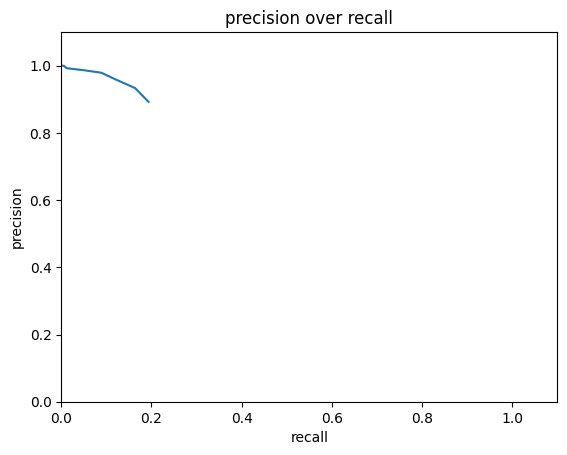

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.81it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

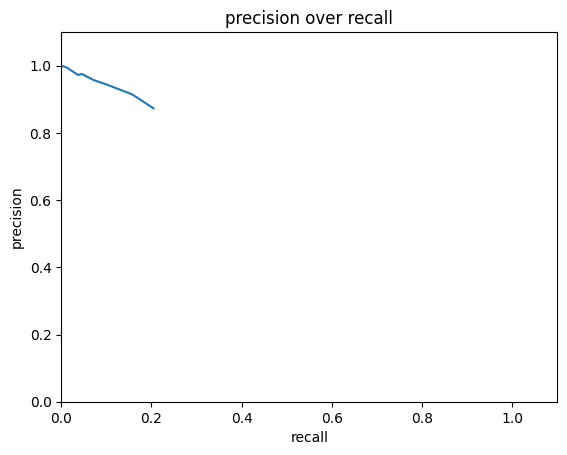

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.82it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

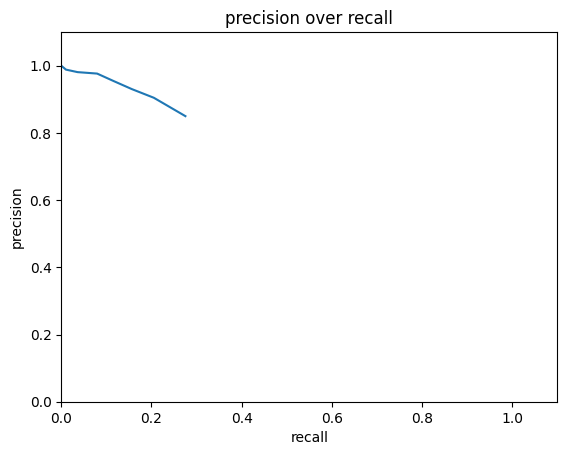

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.31it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

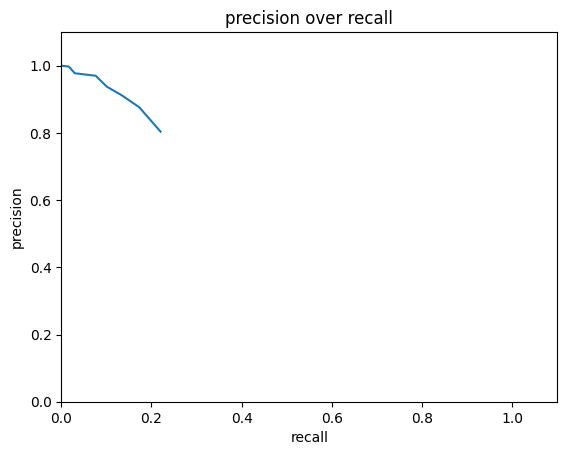

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.92it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

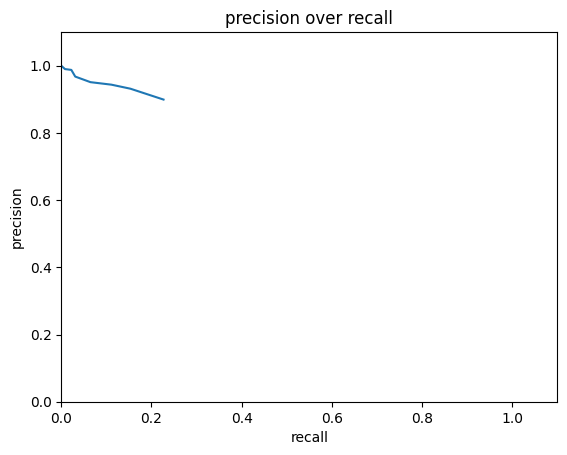

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 44.31it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

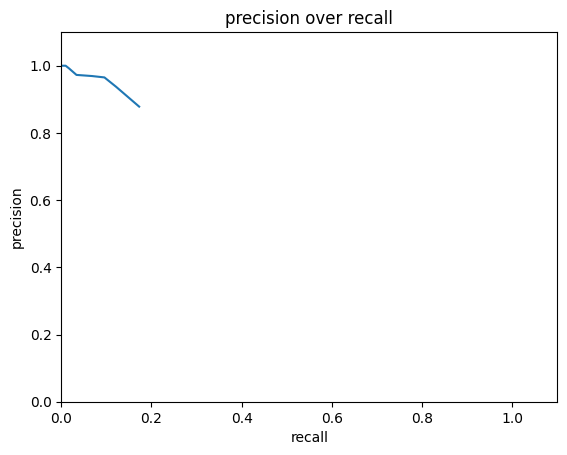

Training started.


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.84it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

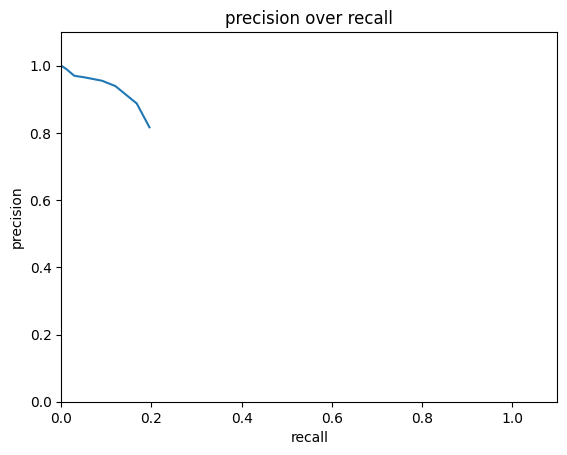

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.62s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 20.12it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

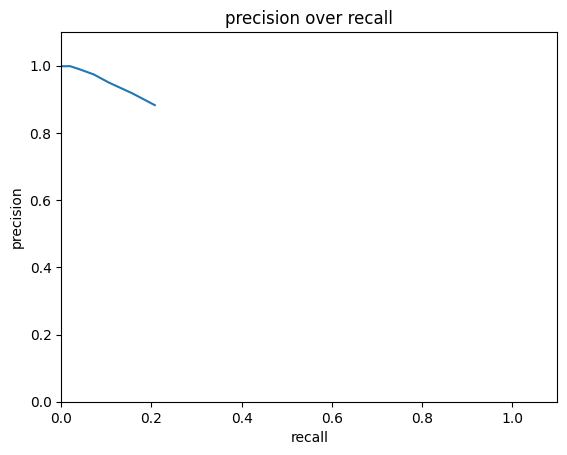

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.55s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 37.90it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

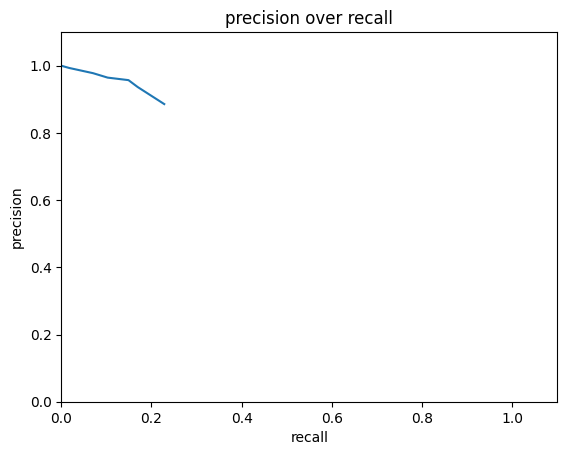

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.82s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.25it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

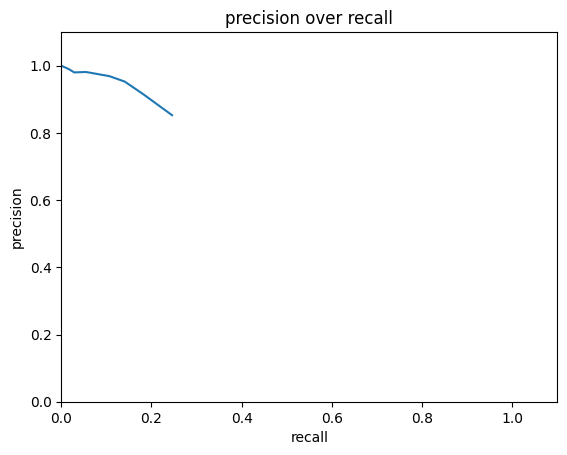

Training started.


100%|██████████| 17/17 [00:39<00:00,  2.35s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 20.87it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

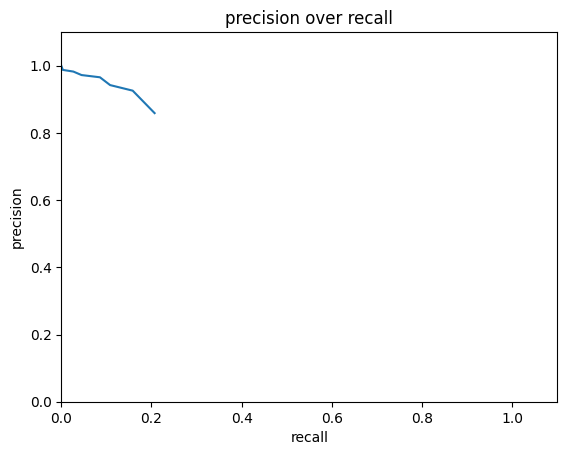

Training started.


100%|██████████| 17/17 [00:48<00:00,  2.86s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 20.81it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

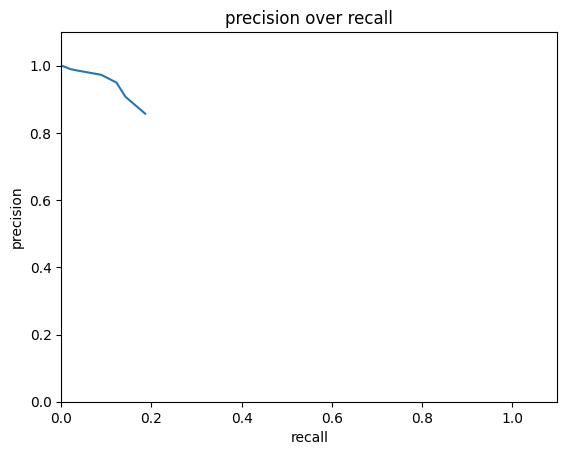

Training started.


100%|██████████| 17/17 [00:41<00:00,  2.44s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.46it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

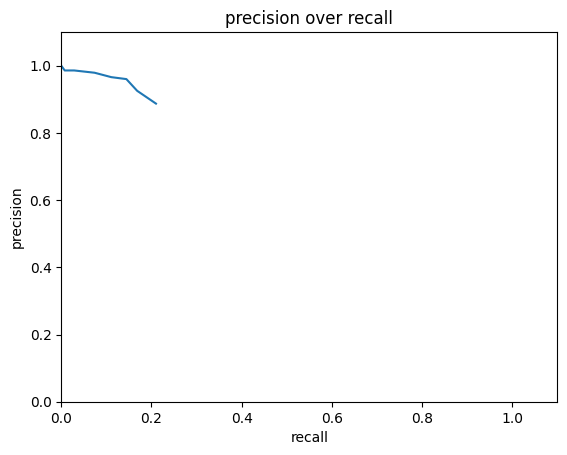

-----Pruning iteration 9/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.88it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

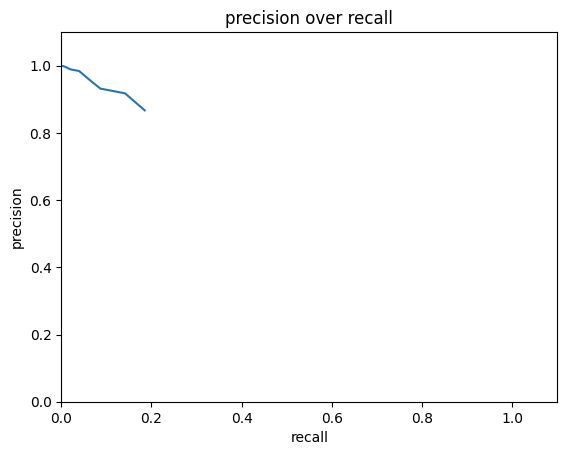

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.86s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 38.54it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

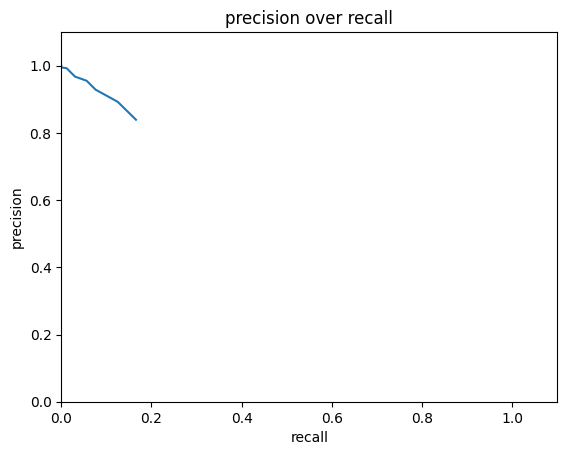

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.63s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.63it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

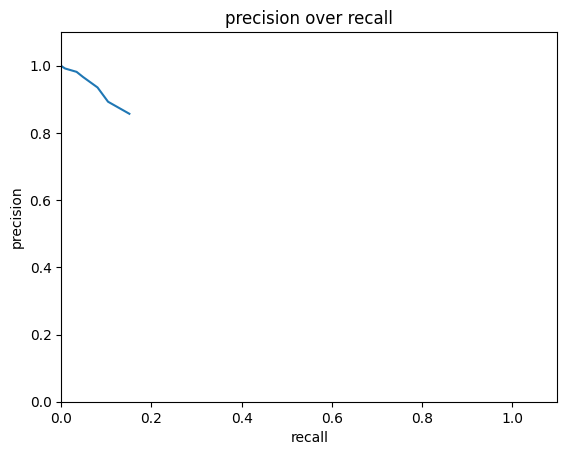

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 38.59it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

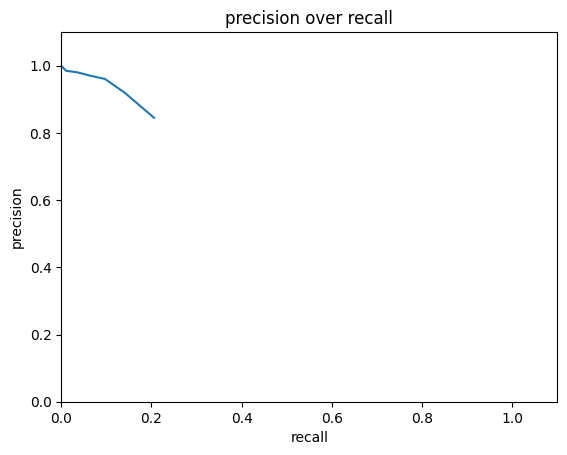

Training started.


100%|██████████| 17/17 [00:33<00:00,  1.97s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.36it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

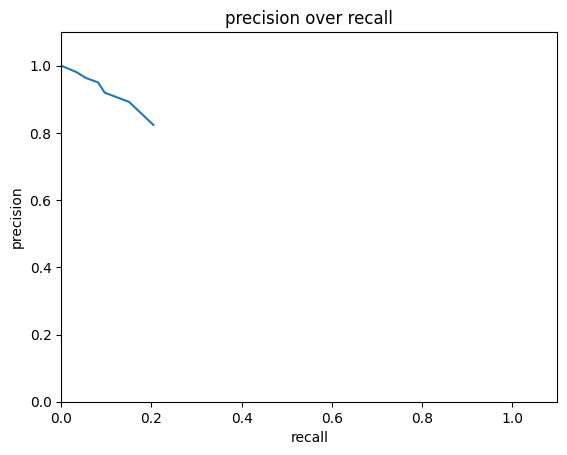

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.28s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 33.58it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

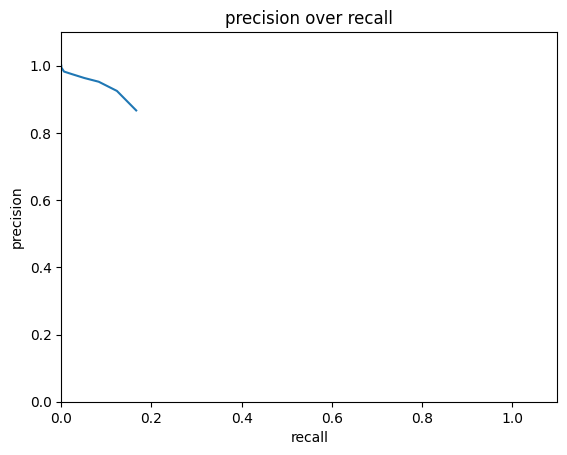

Training started.


100%|██████████| 17/17 [00:32<00:00,  1.90s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.75it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

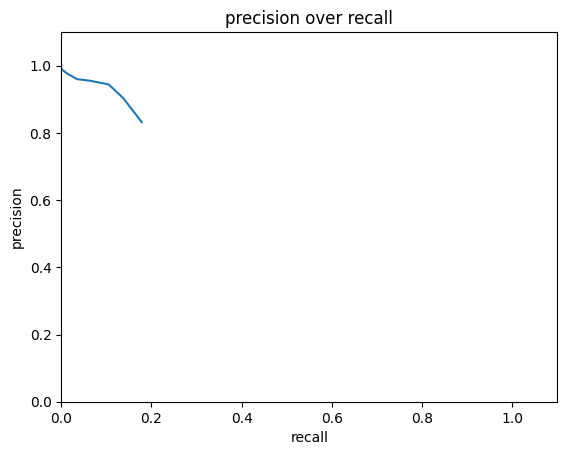

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.59s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.66it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

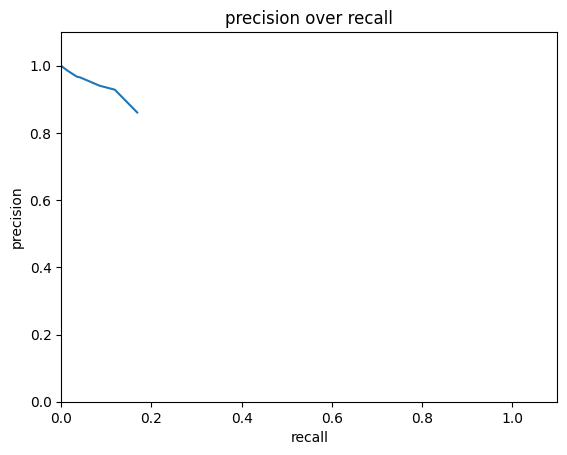

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.54s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.36it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

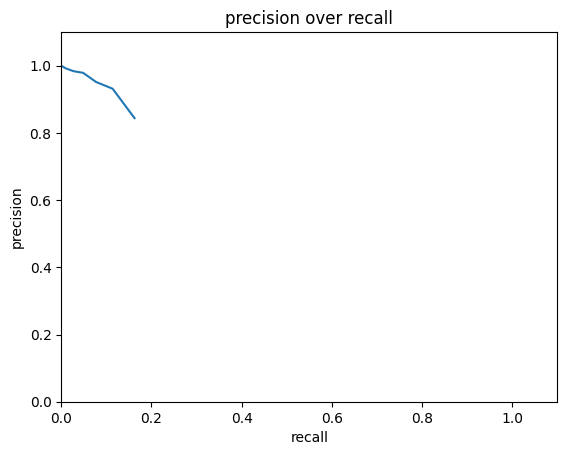

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.55it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

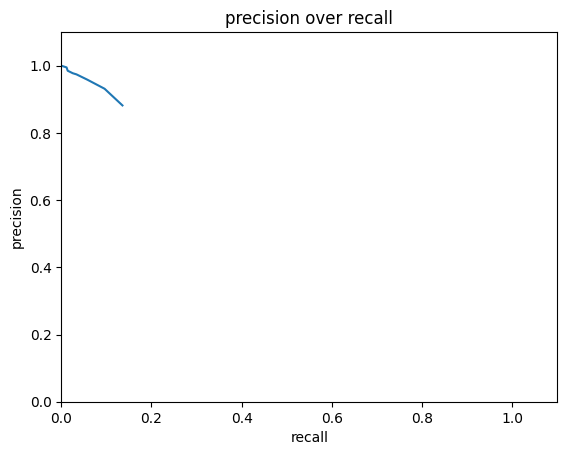

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.55s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.58it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

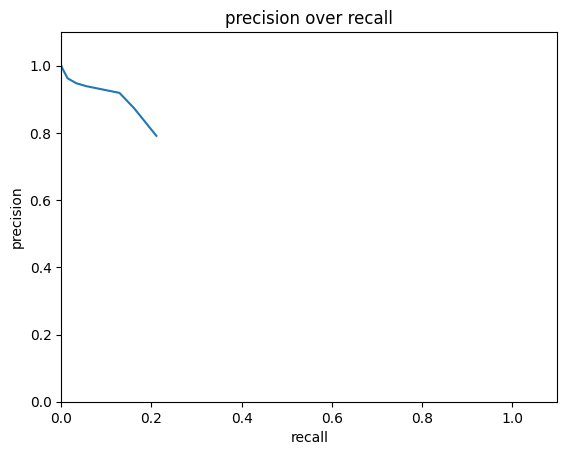

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 35.21it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

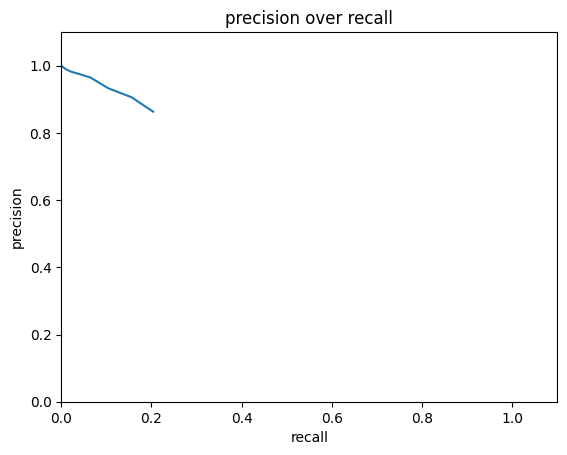

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.51it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

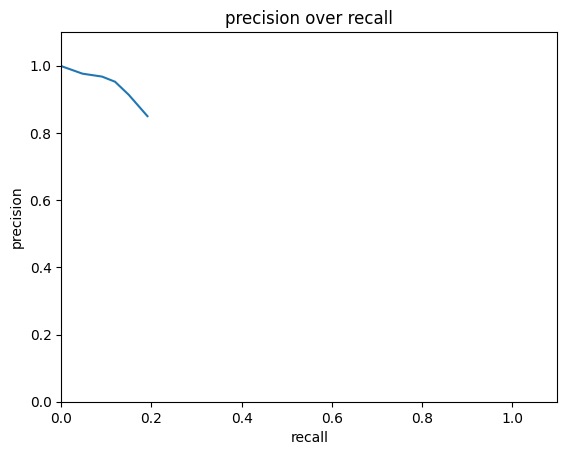

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.83s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 35.69it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

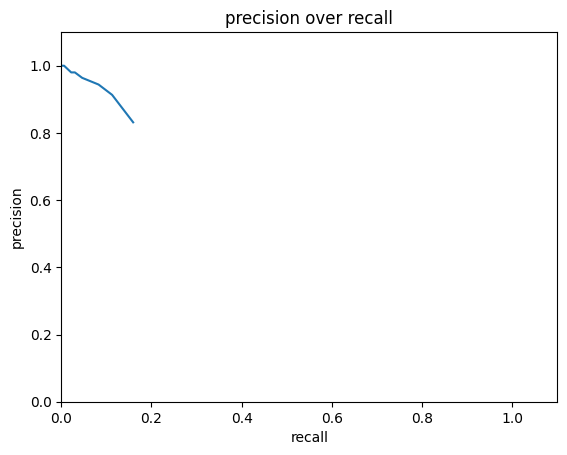

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.61s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.24it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

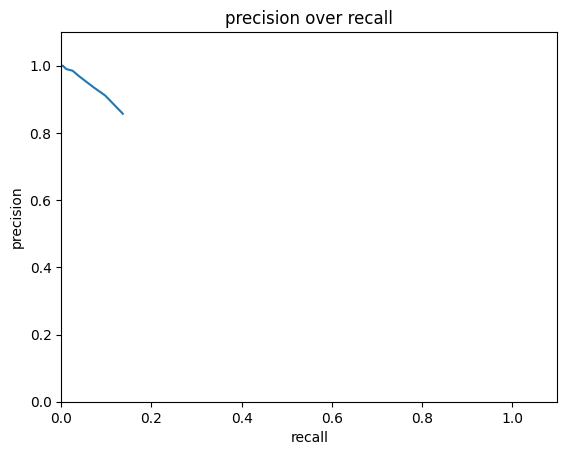

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.63s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.34it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

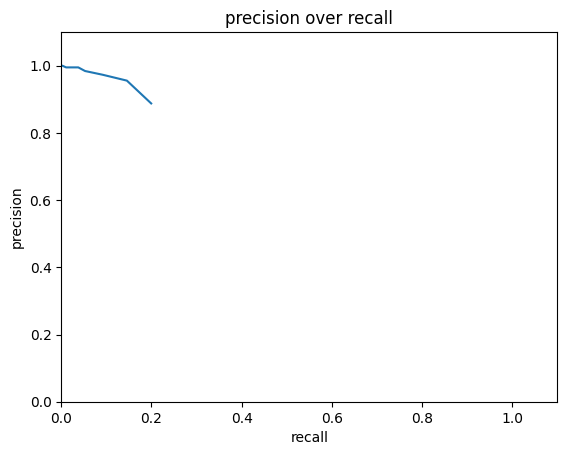

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.60s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.39it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

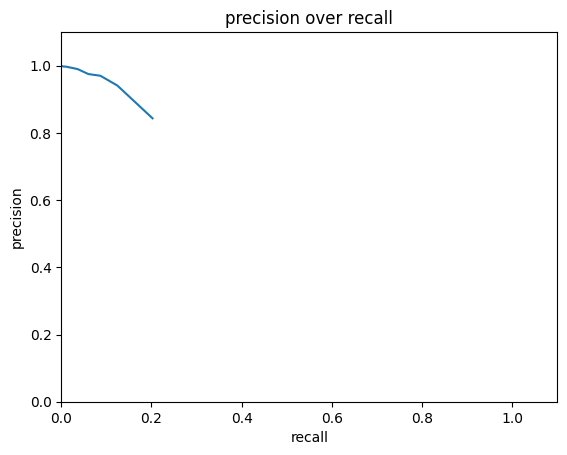

Training started.


100%|██████████| 17/17 [00:42<00:00,  2.53s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.17it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

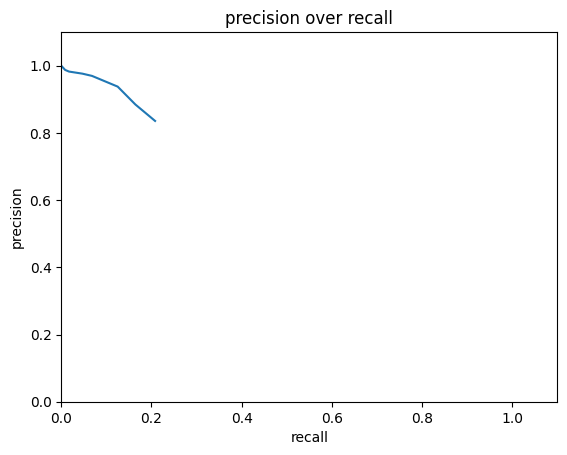

Training started.


100%|██████████| 17/17 [00:42<00:00,  2.50s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.92it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

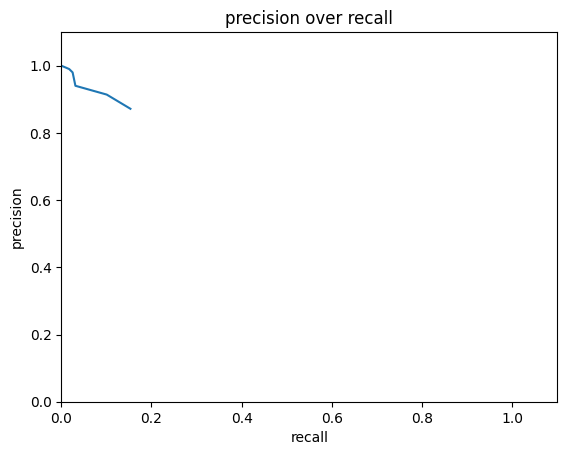

Training started.


100%|██████████| 17/17 [00:42<00:00,  2.51s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.98it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

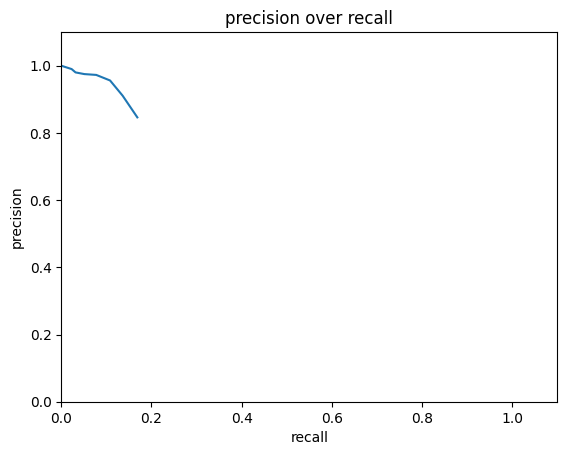

-----Pruning iteration 10/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.06it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

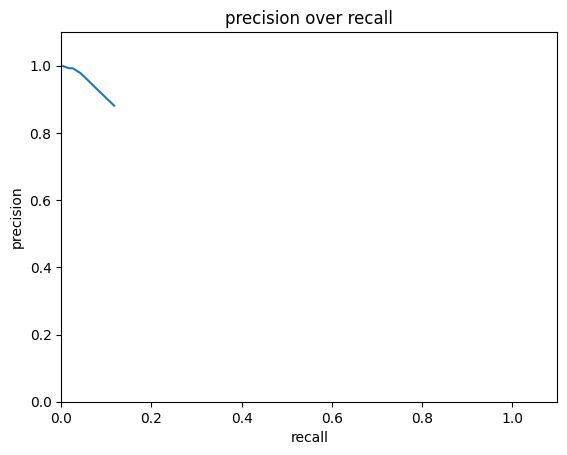

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.20it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

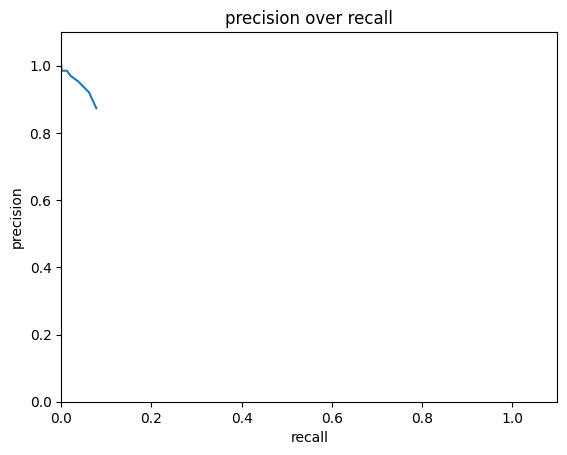

Training started.


100%|██████████| 17/17 [00:42<00:00,  2.50s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 28.73it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

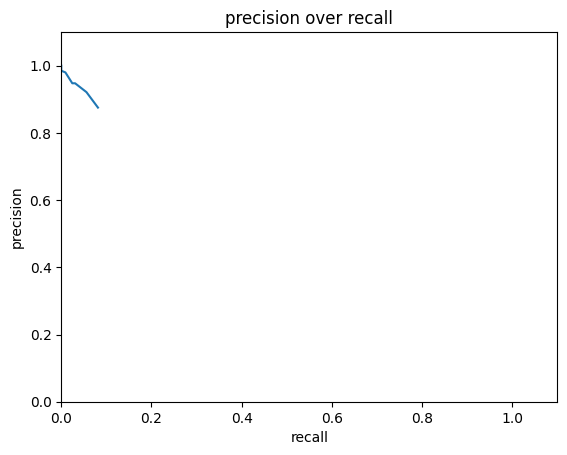

Training started.


100%|██████████| 17/17 [00:41<00:00,  2.43s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.94it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

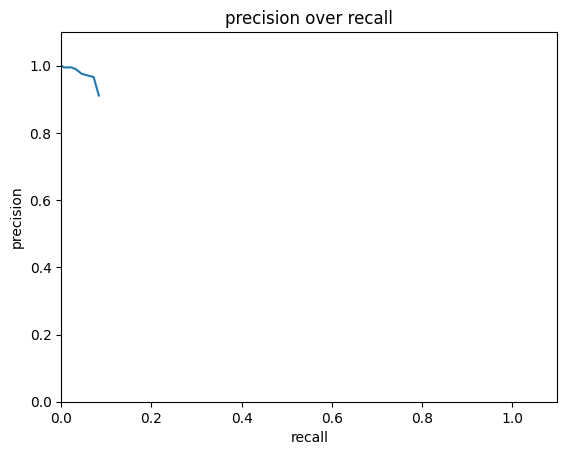

Training started.


100%|██████████| 17/17 [00:41<00:00,  2.44s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.26it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

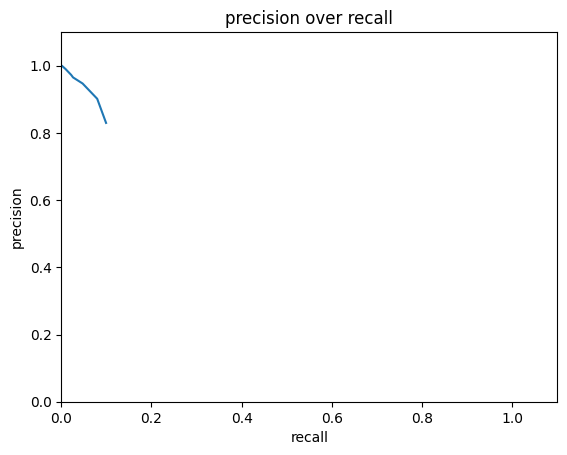

Training started.


100%|██████████| 17/17 [00:42<00:00,  2.48s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.00it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

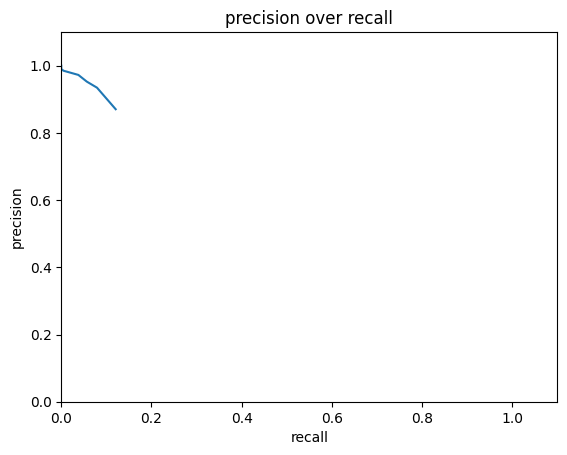

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.54s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.59it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

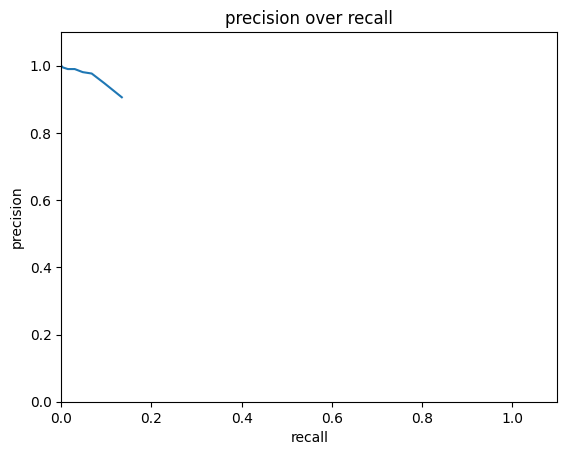

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.65s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.27it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

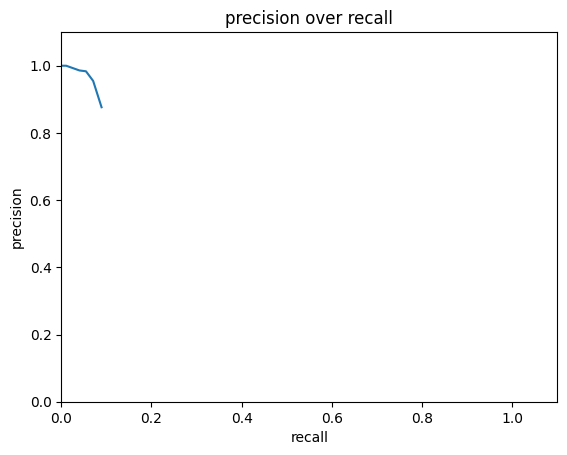

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.67s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.40it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

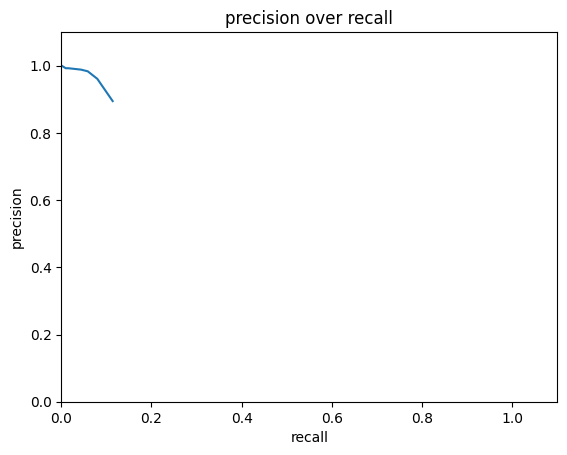

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.65s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.94it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

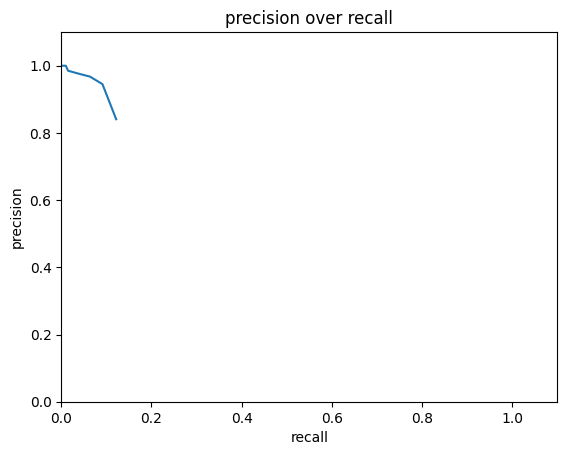

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.03it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

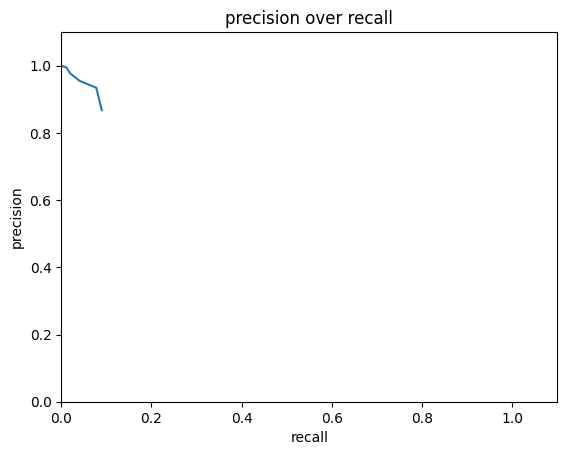

Training started.


100%|██████████| 17/17 [00:42<00:00,  2.50s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.69it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

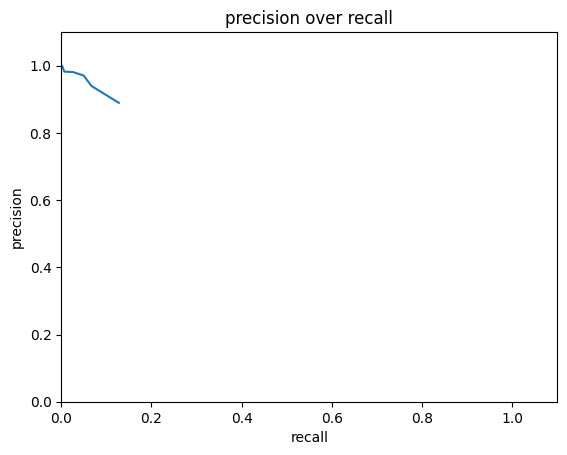

Training started.


100%|██████████| 17/17 [00:42<00:00,  2.52s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.17it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

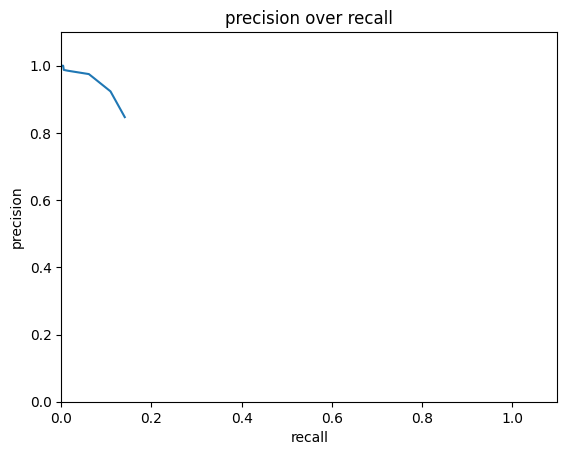

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.54s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.04it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

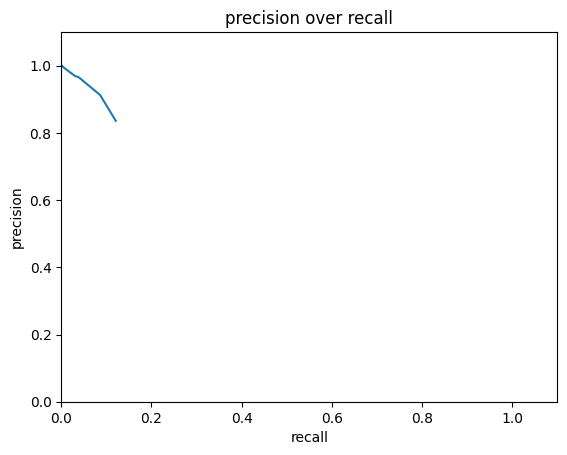

Training started.


100%|██████████| 17/17 [00:39<00:00,  2.30s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 39.34it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

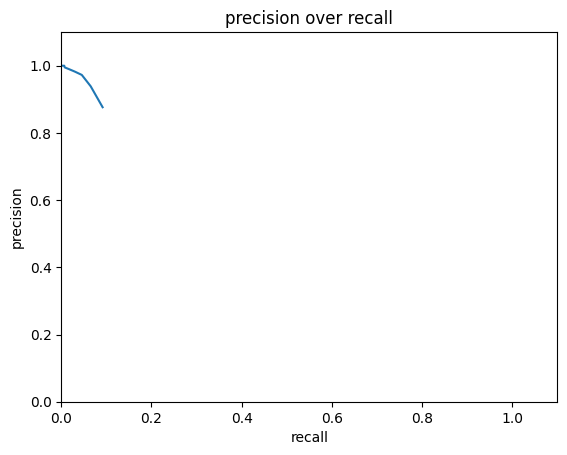

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.21s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 33.00it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

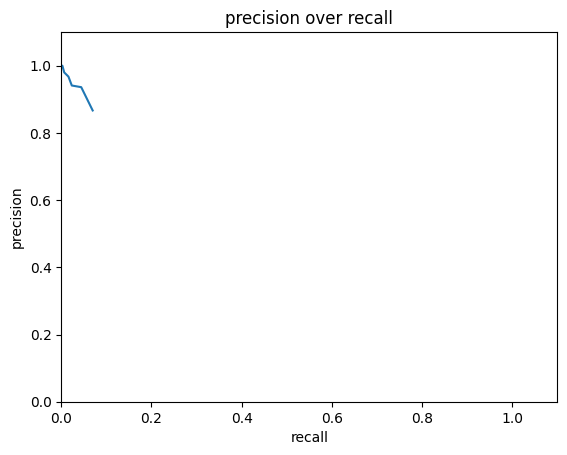

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.54s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.67it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

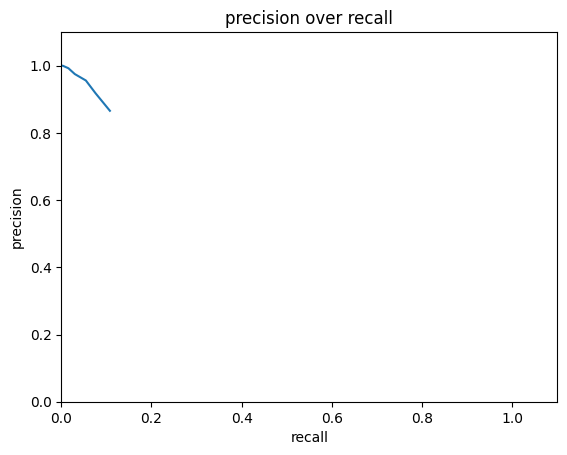

Training started.


100%|██████████| 17/17 [00:42<00:00,  2.52s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.48it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

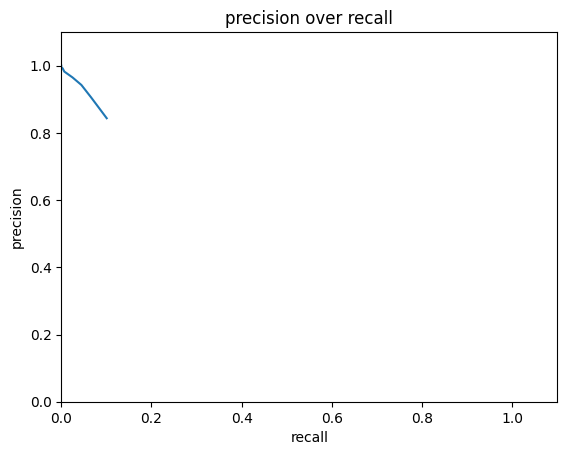

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 35.61it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

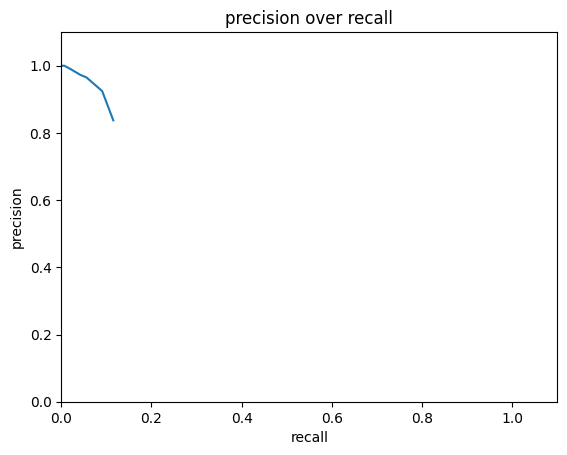

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 50.87it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

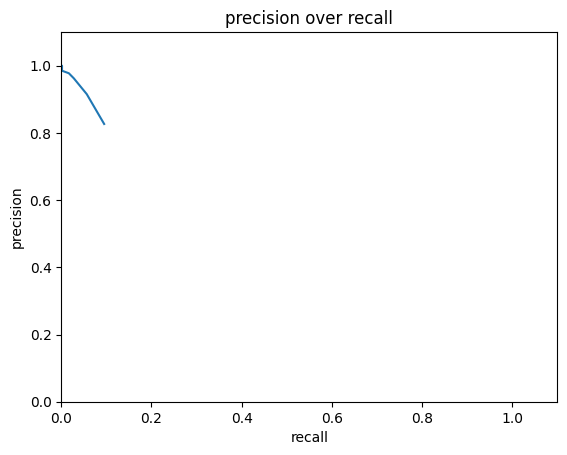

-----Pruning iteration 11/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.85it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

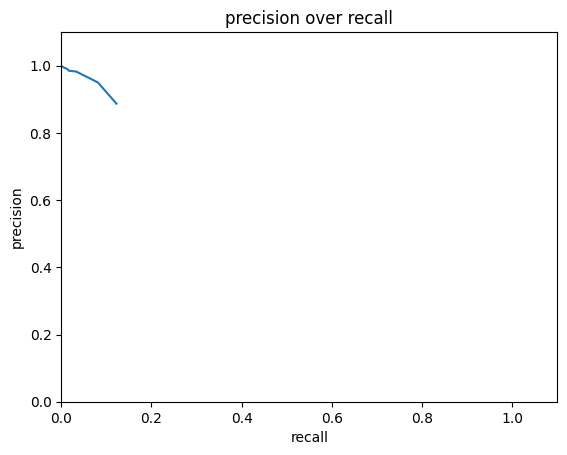

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 50.30it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

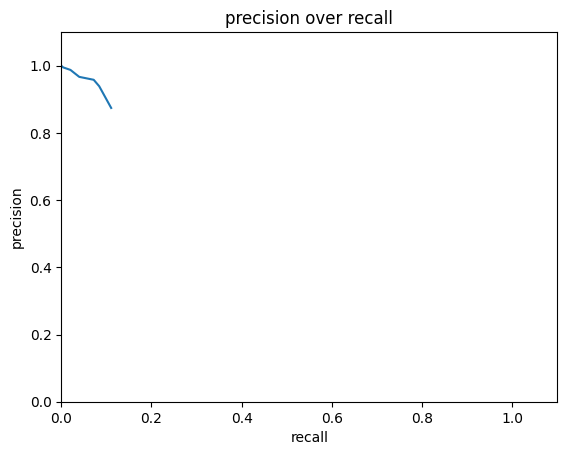

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.37it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

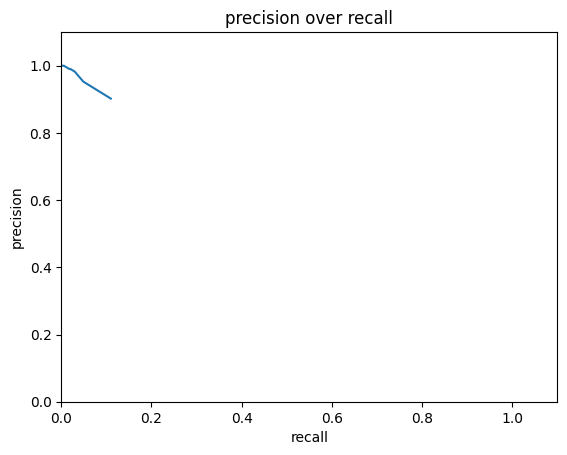

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.33it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

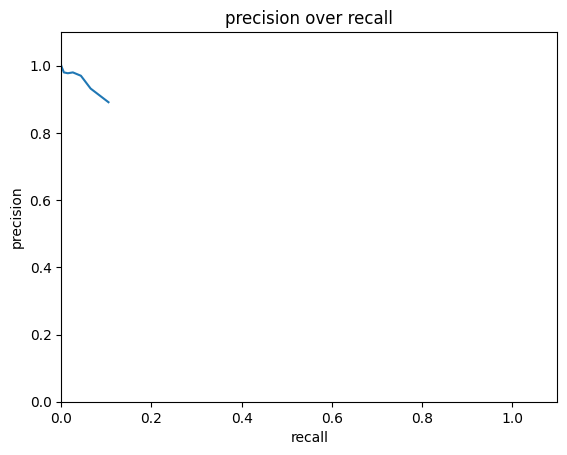

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 43.49it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

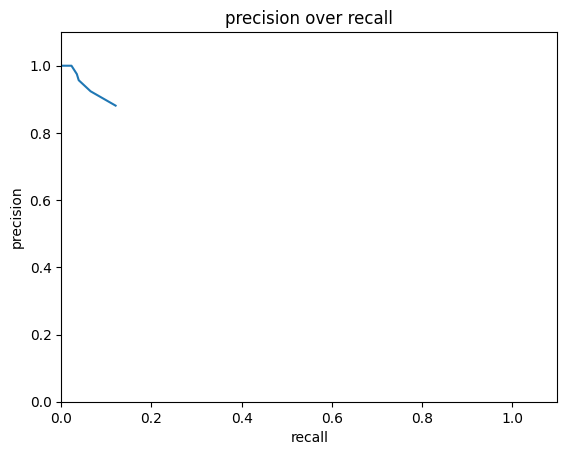

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.00it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

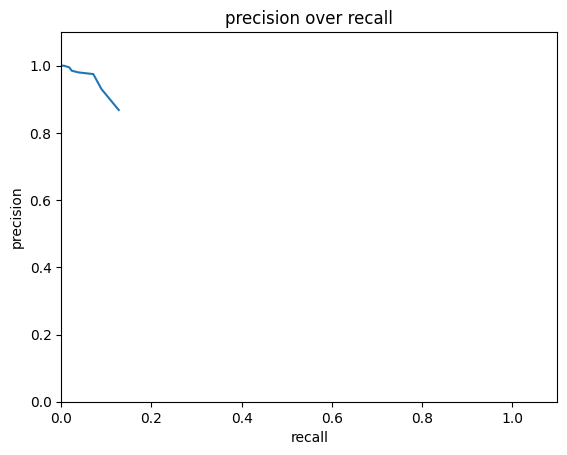

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 50.01it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

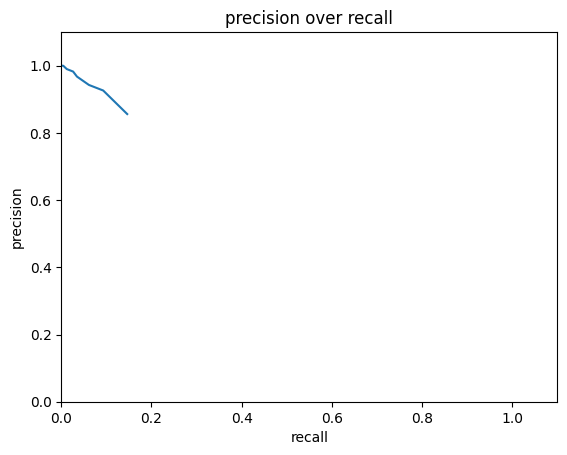

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.08it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

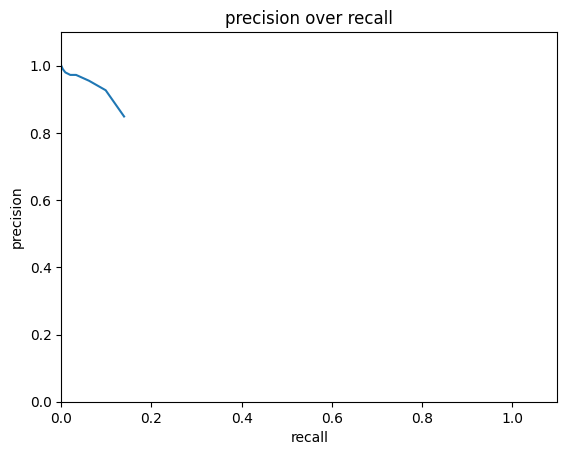

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.77it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

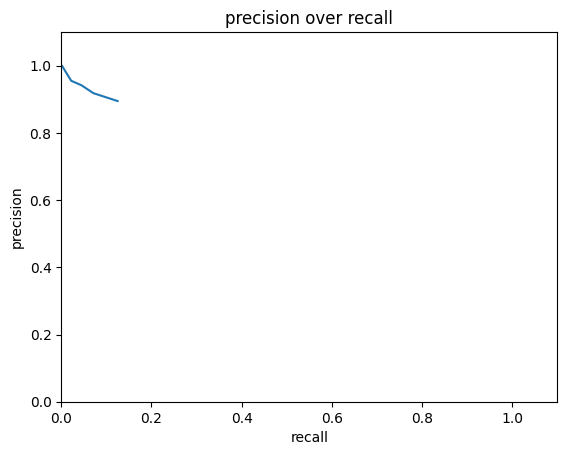

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.67s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.24it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

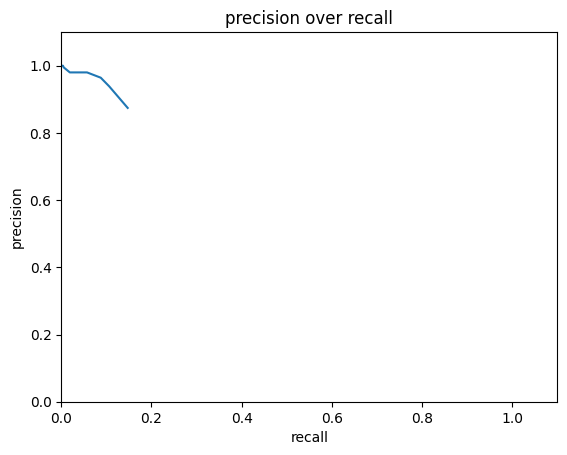

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.62s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 56.16it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

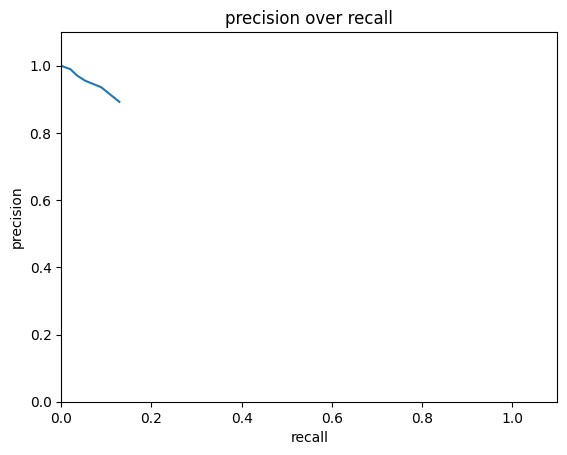

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.54it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

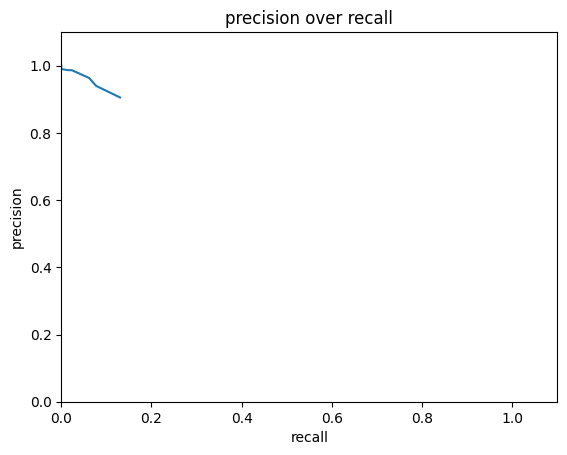

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.18it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

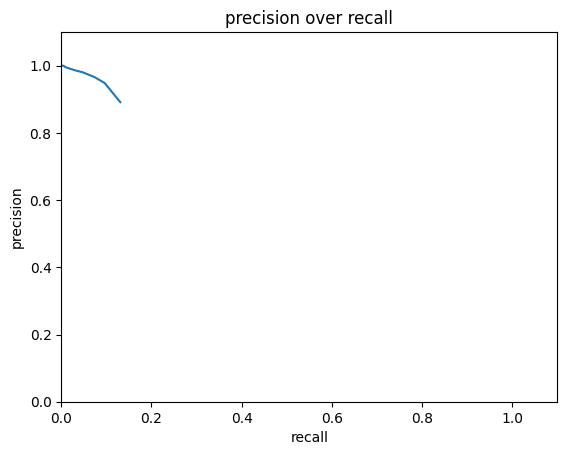

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 48.28it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

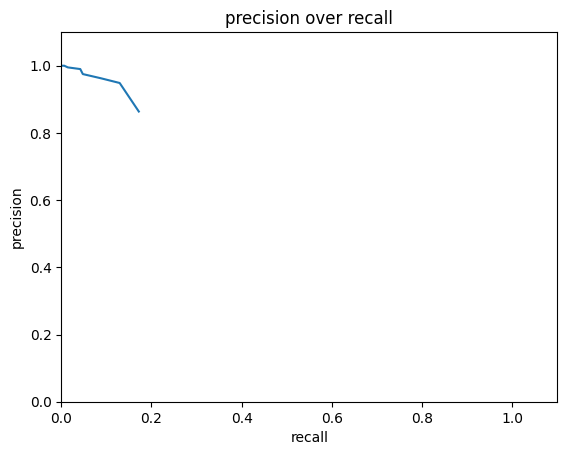

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.84s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 50.85it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

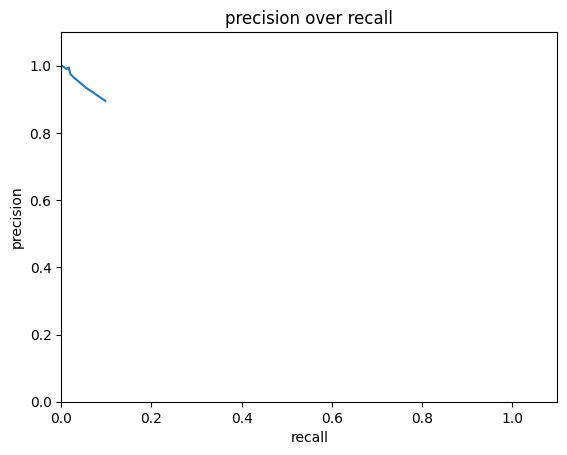

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 55.89it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

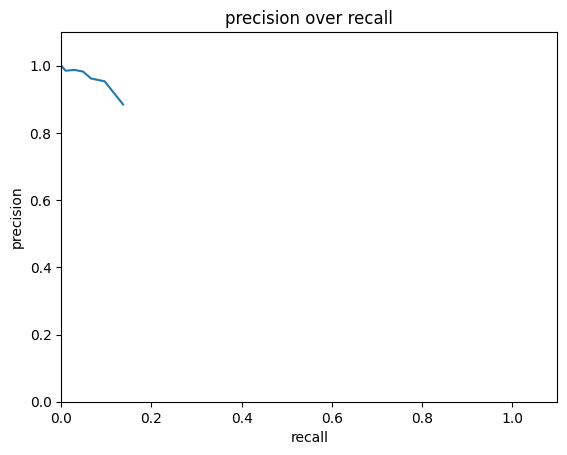

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 44.34it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

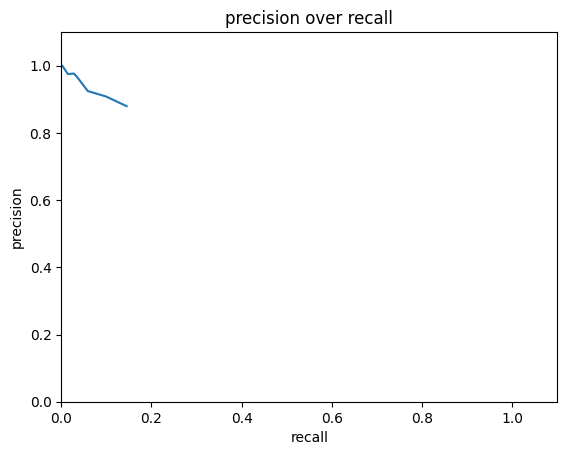

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.23it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

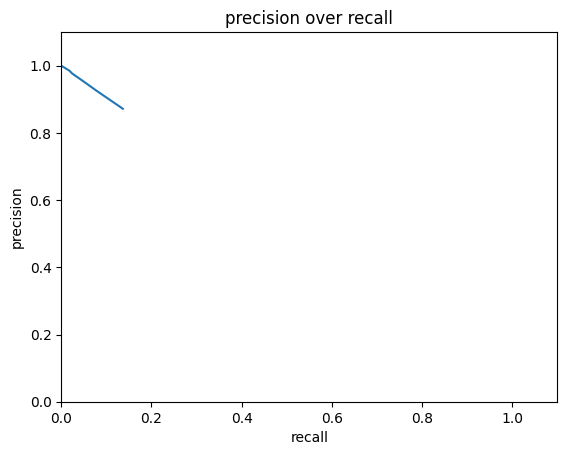

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.82s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 42.29it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

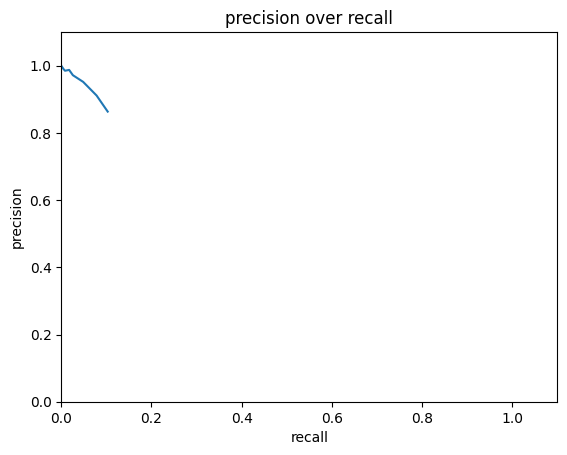

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.72it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

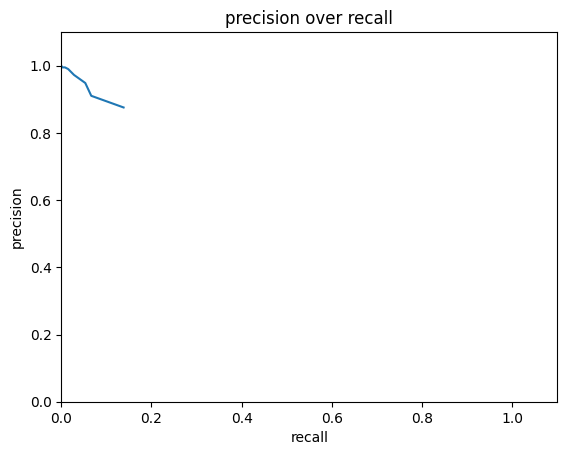

-----Pruning iteration 12/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:06<00:00, 28.85it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

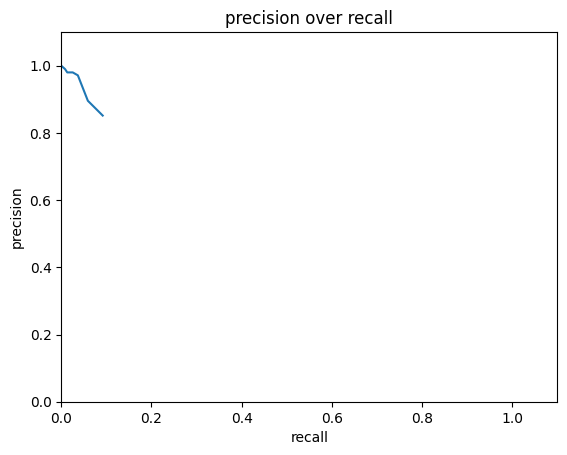

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.60s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 28.79it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

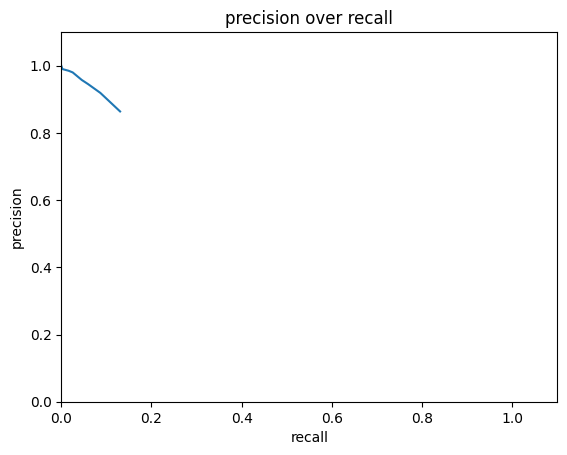

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.65s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.36it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

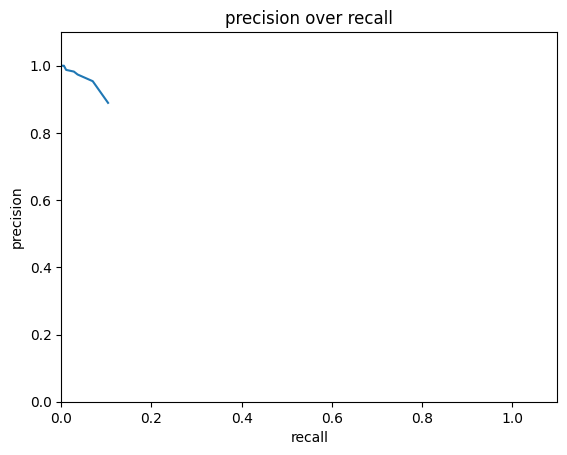

Training started.


100%|██████████| 17/17 [00:36<00:00,  2.15s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 46.17it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

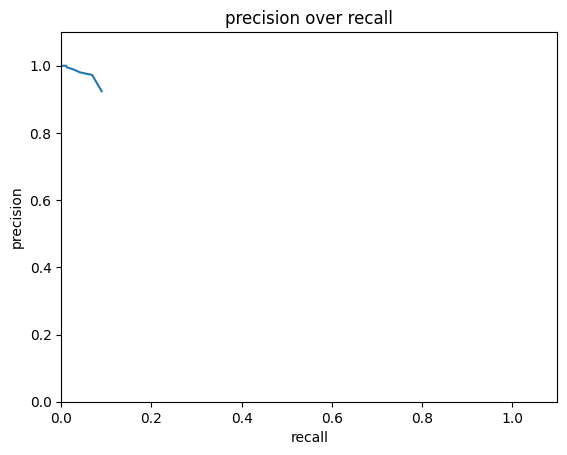

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 57.64it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

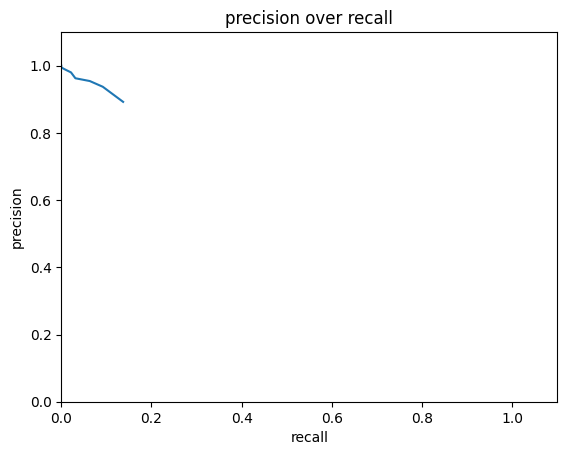

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 54.91it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

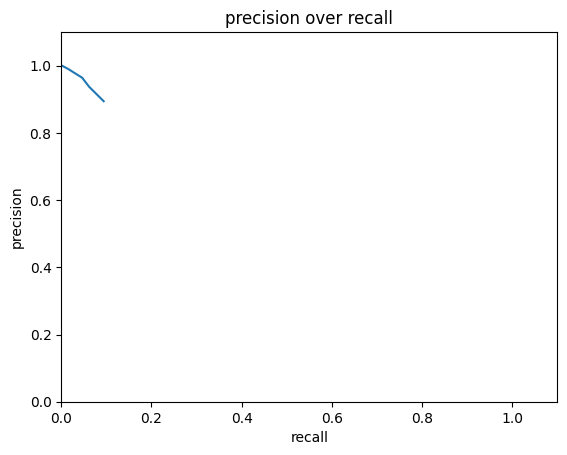

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.12it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

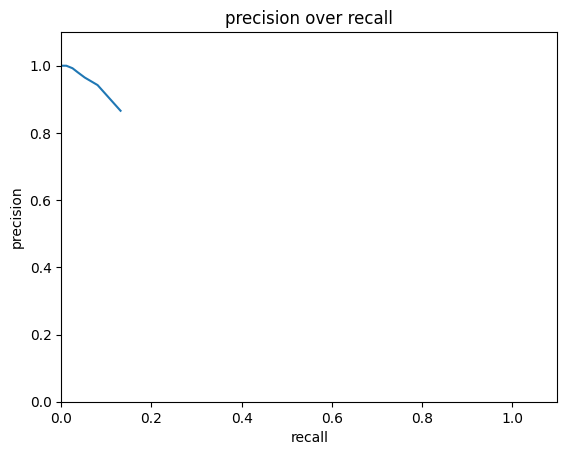

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.67it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

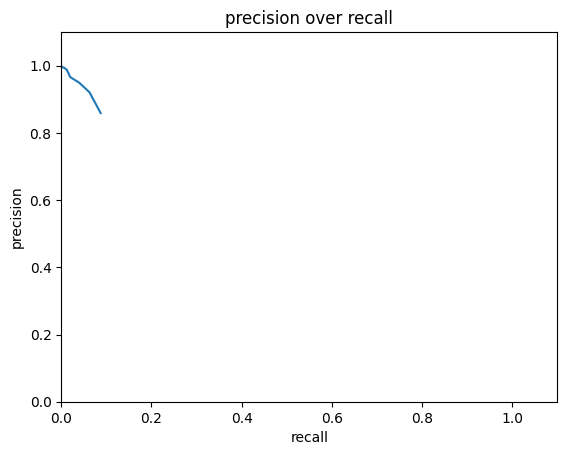

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 57.76it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

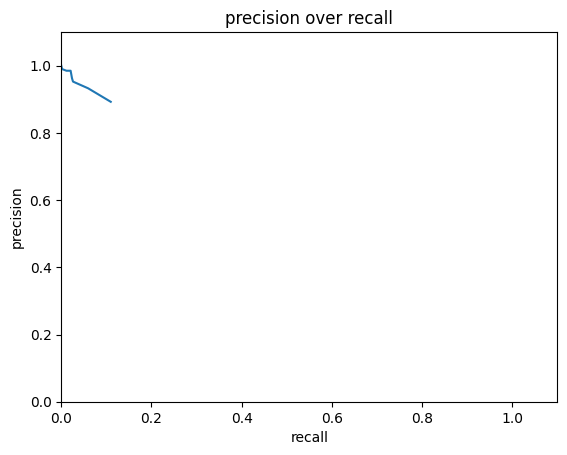

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.73it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

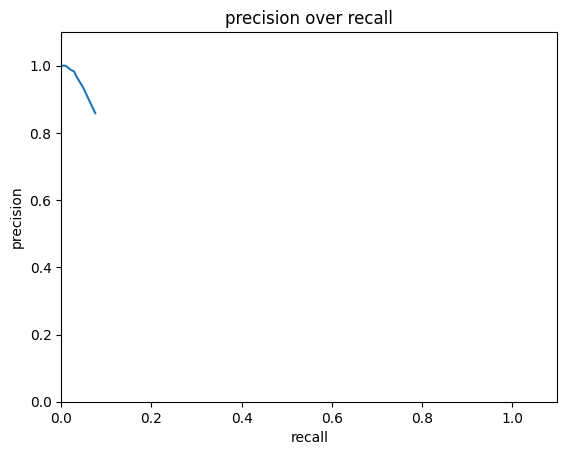

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 56.50it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

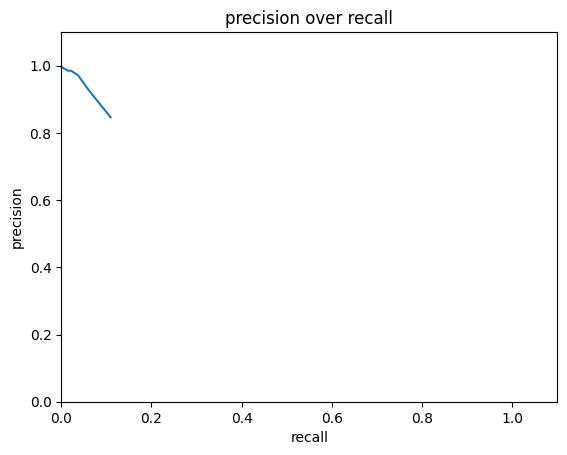

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 44.77it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

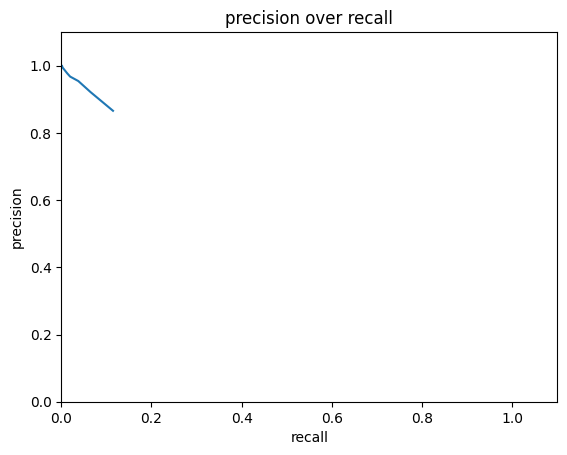

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 37.88it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

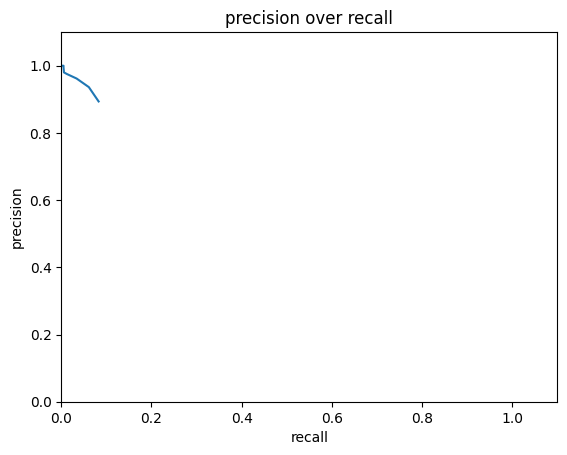

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.74s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.73it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

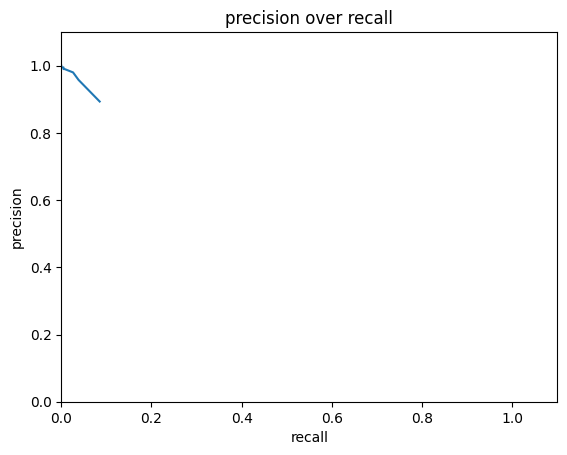

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.20s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.88it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

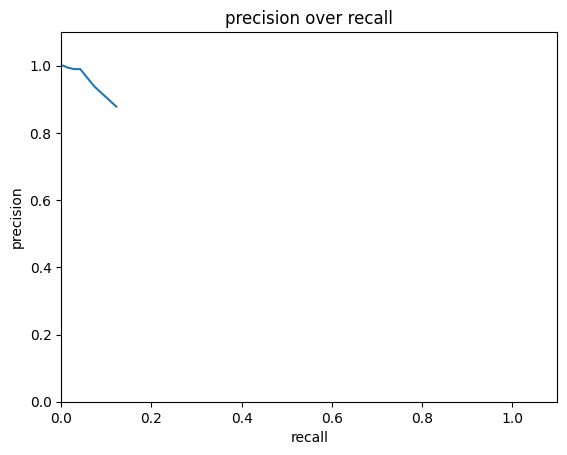

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.44it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

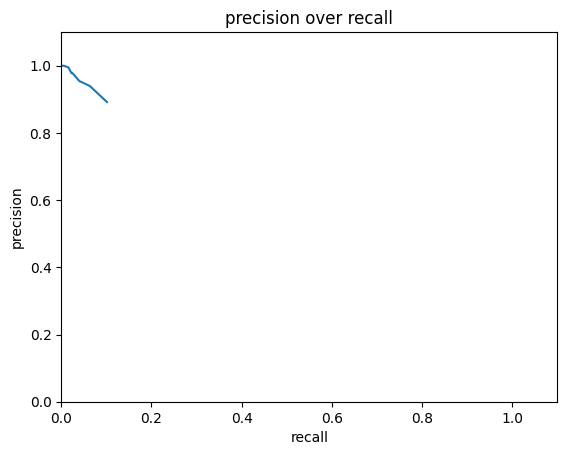

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.15it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

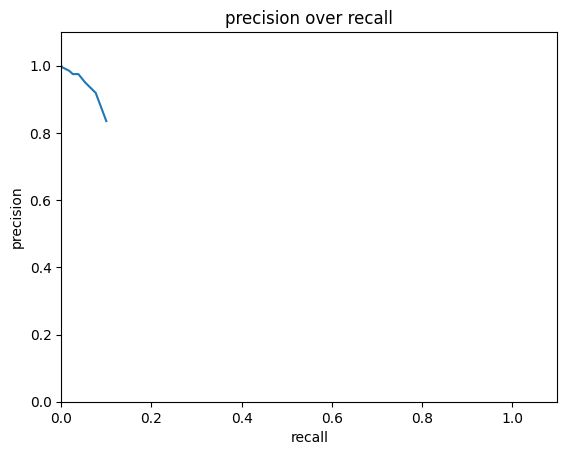

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 60.30it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

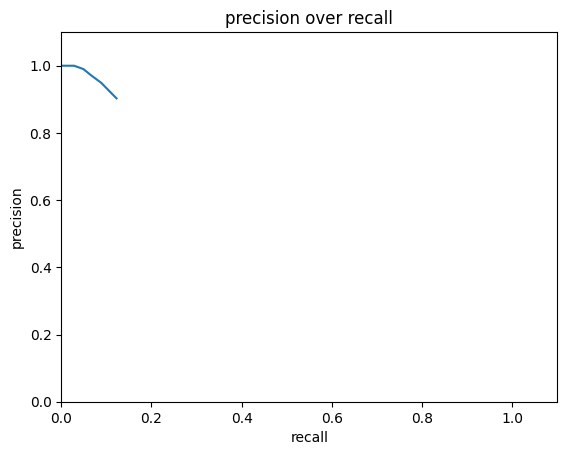

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 57.05it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

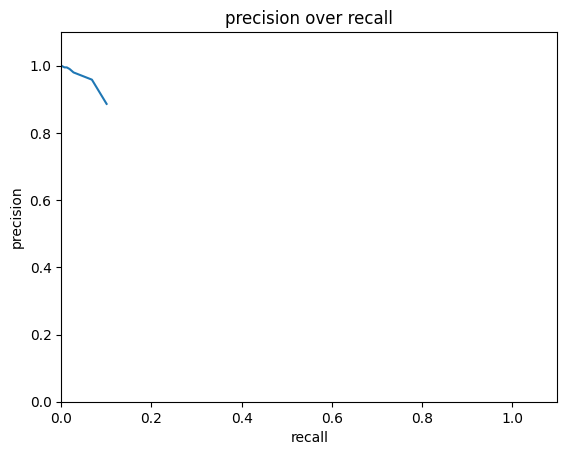

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.73s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 58.80it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

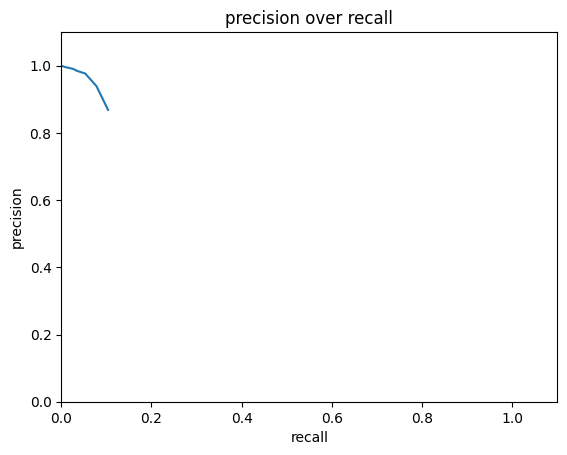

-----Pruning iteration 13/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:04<00:00, 49.89it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

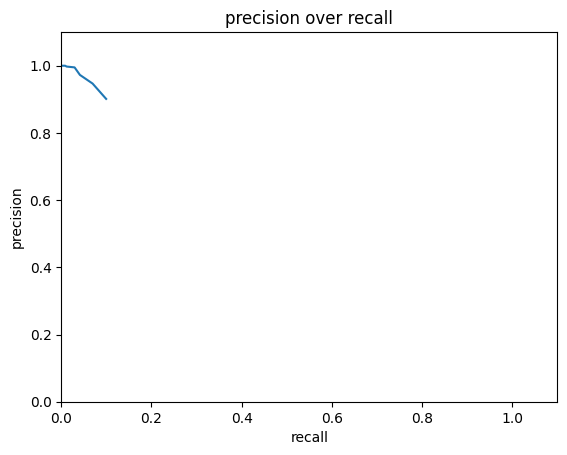

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.11it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

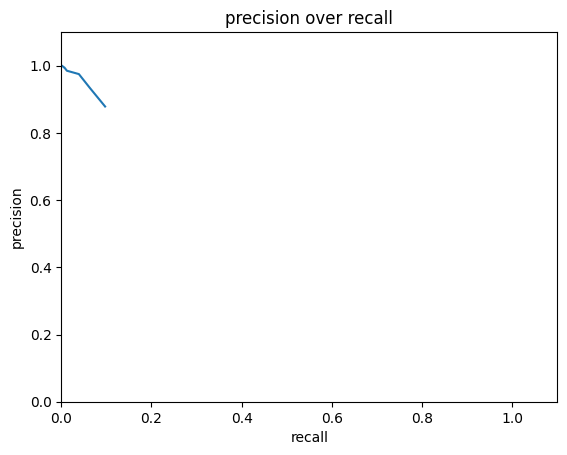

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.00it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

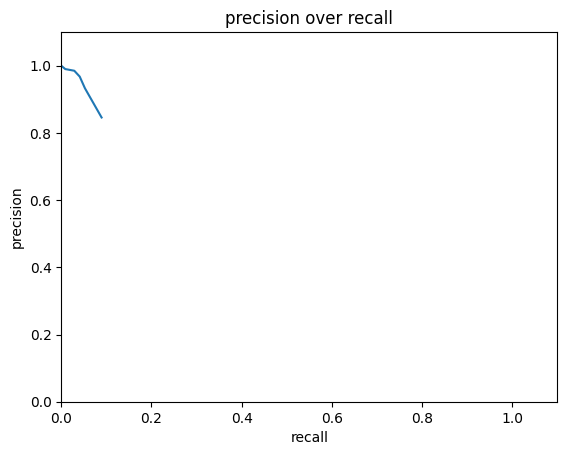

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 55.83it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

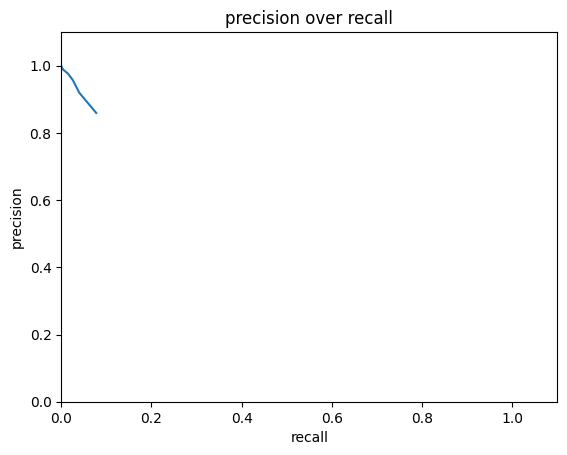

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 57.84it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

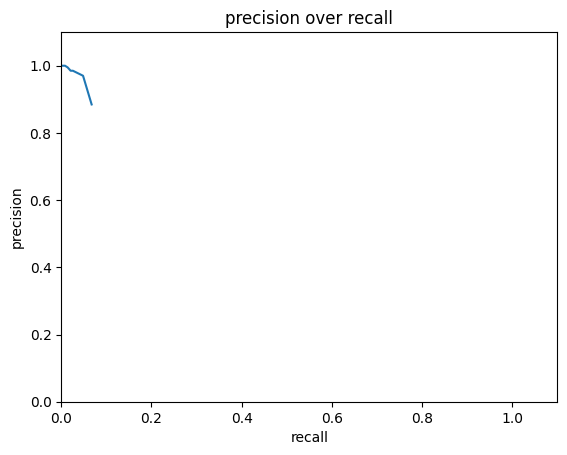

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.34it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

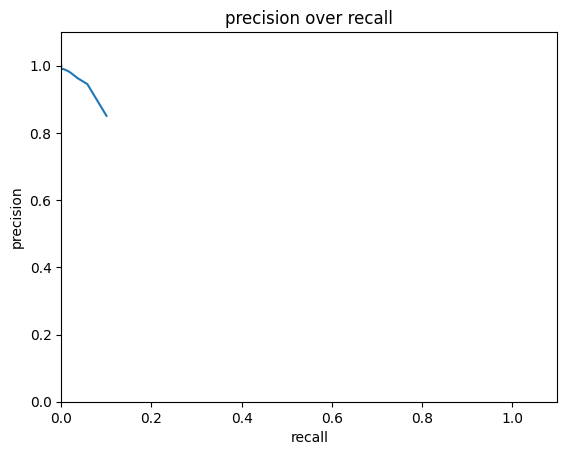

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 54.76it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

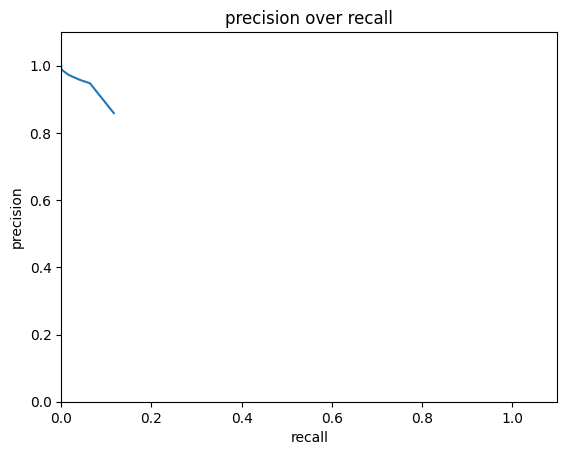

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.39it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

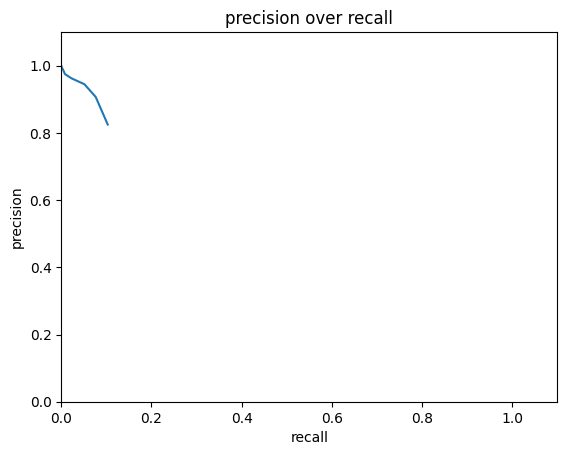

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.13it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

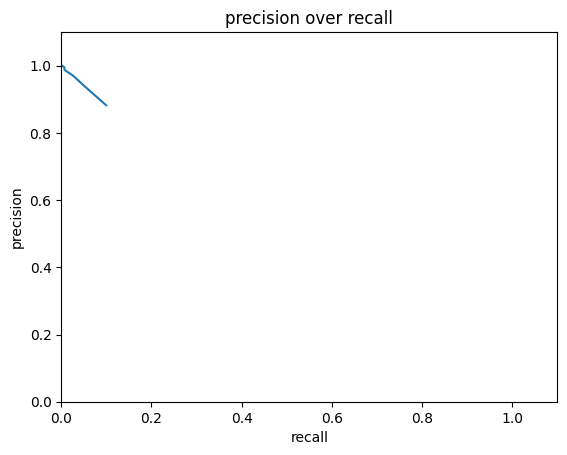

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.90it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

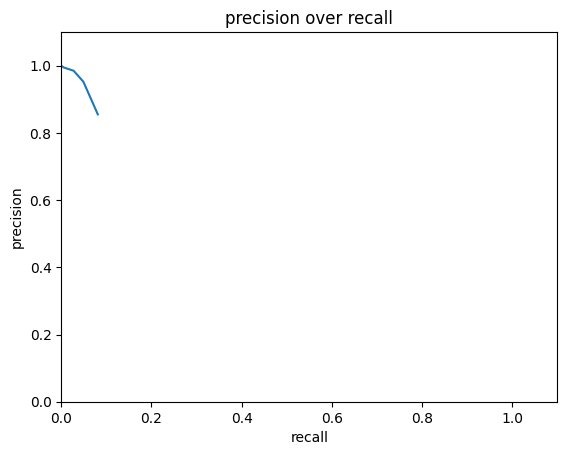

Training started.


100%|██████████| 17/17 [00:32<00:00,  1.90s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 48.66it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

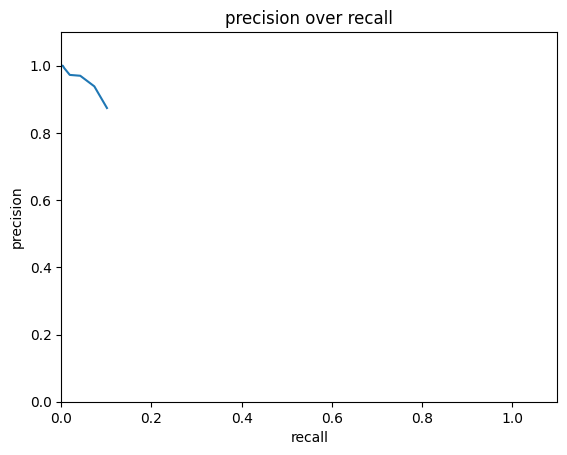

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.54s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 28.65it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

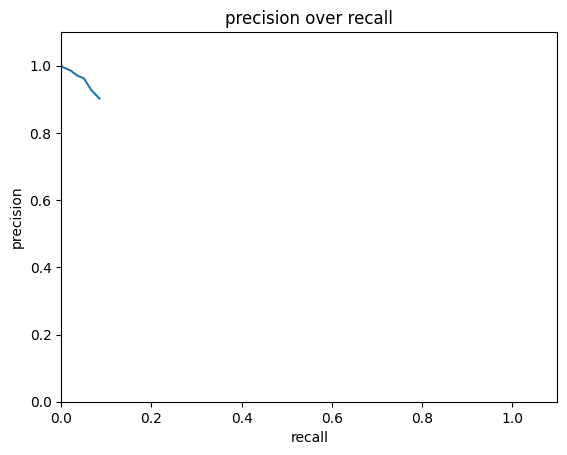

Training started.


100%|██████████| 17/17 [00:40<00:00,  2.40s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 54.84it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

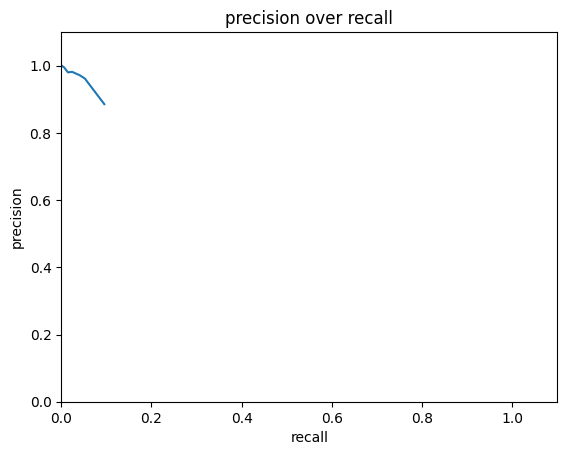

Training started.


100%|██████████| 17/17 [00:35<00:00,  2.10s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 33.20it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

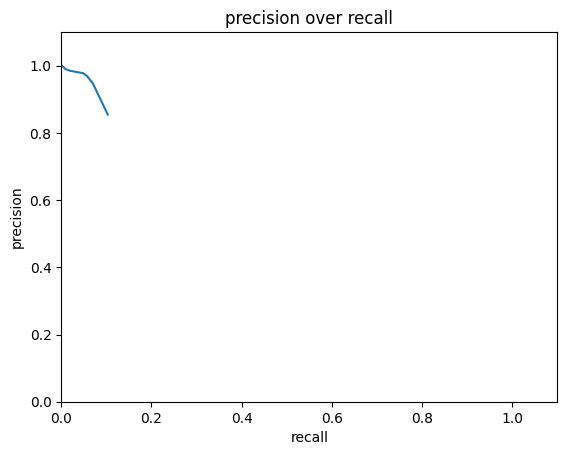

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

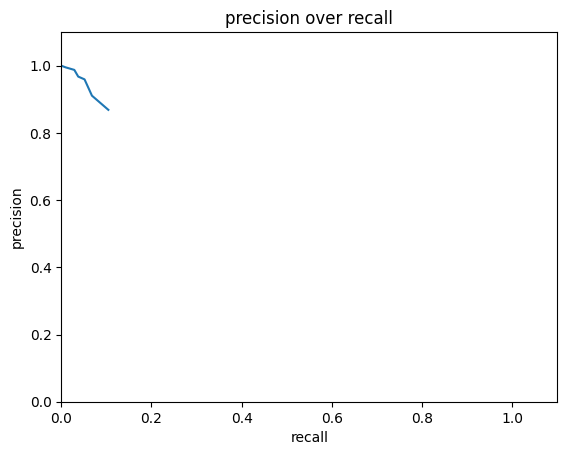

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 28.81it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

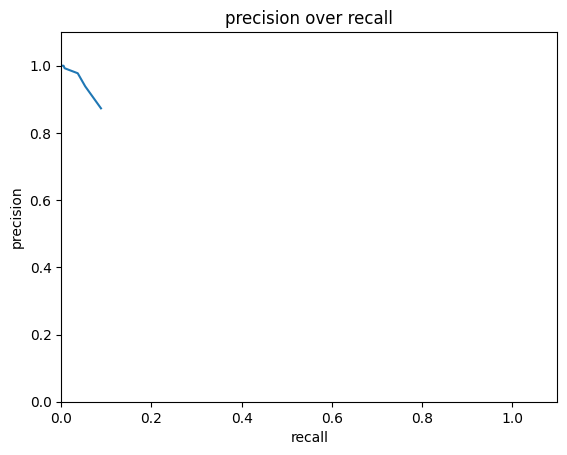

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.73s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.42it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

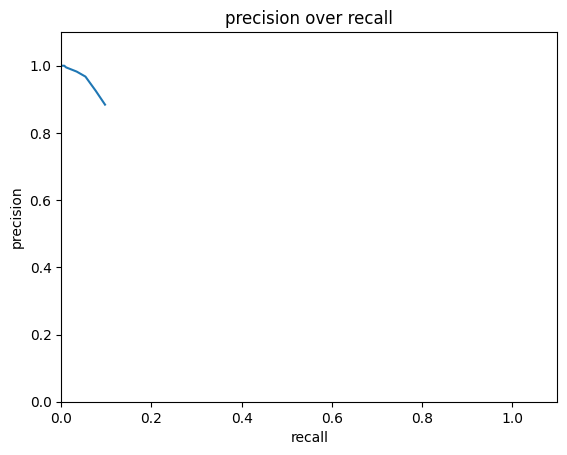

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.04it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

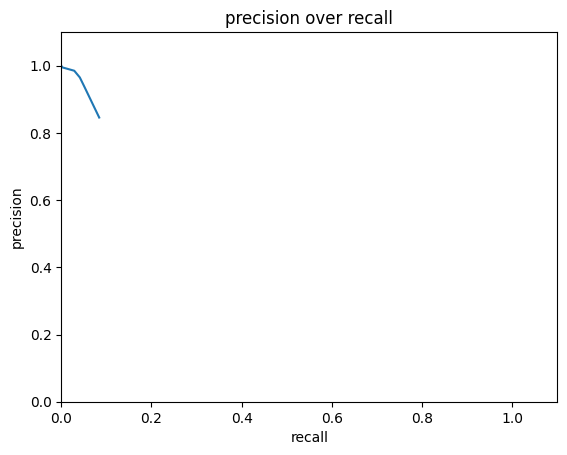

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.61s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.01it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

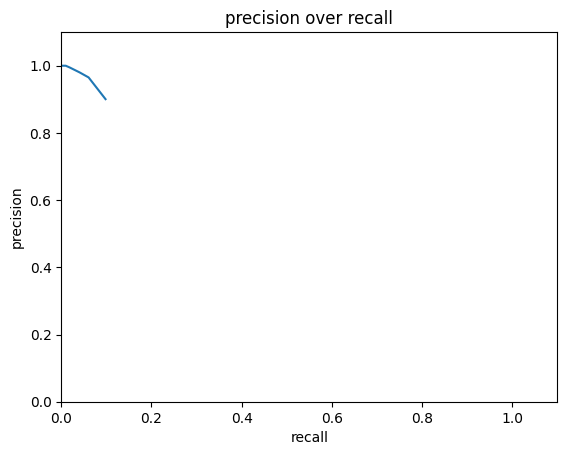

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.00it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

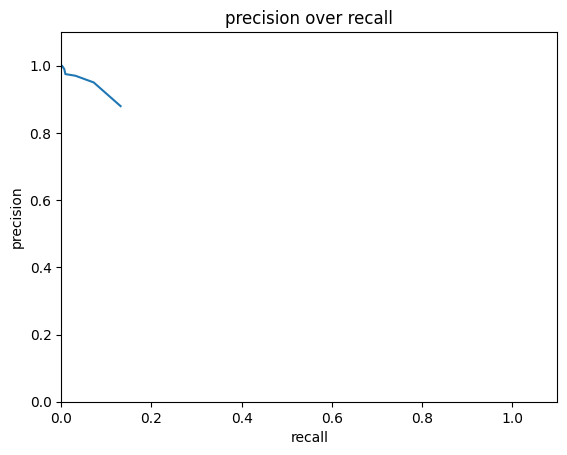

-----Pruning iteration 14/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.82it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

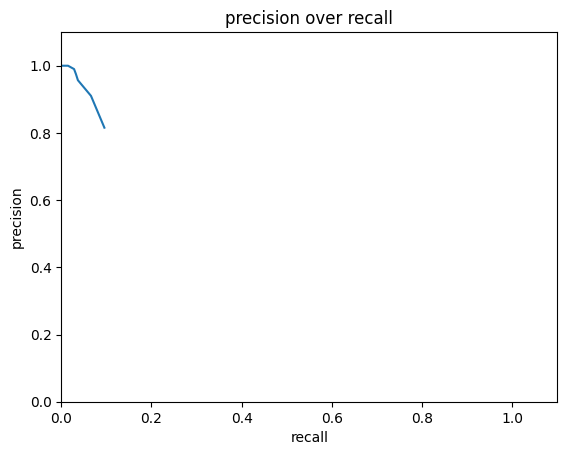

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.65s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.26it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

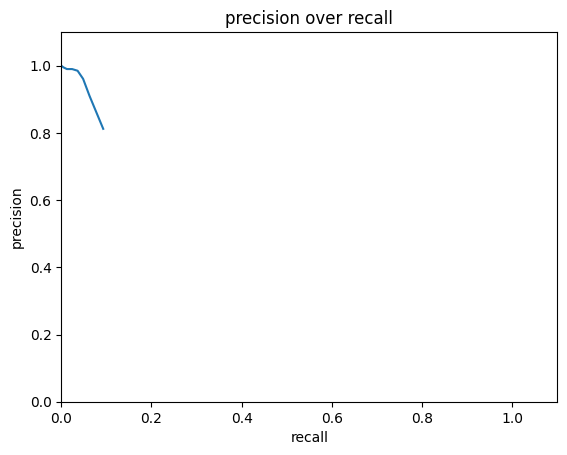

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.17it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

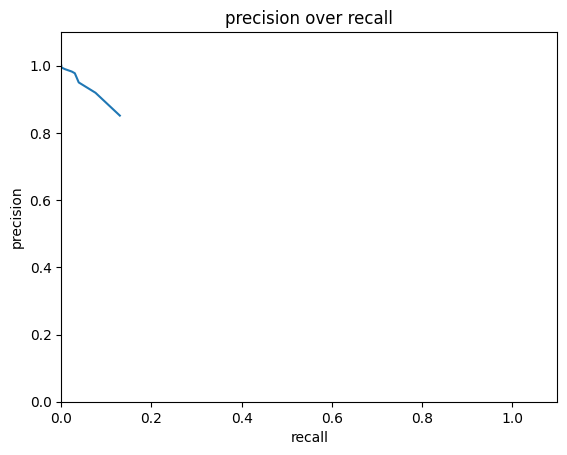

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.62s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.37it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

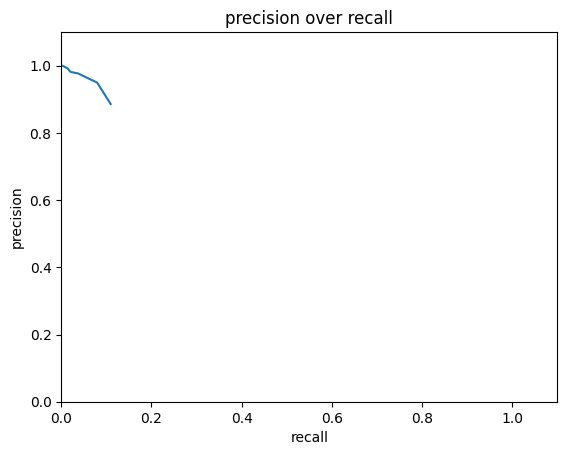

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.65s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.86it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

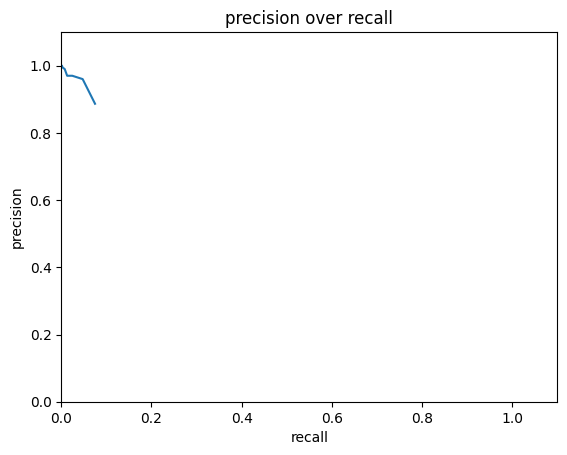

Training started.


100%|██████████| 17/17 [00:39<00:00,  2.33s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.16it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

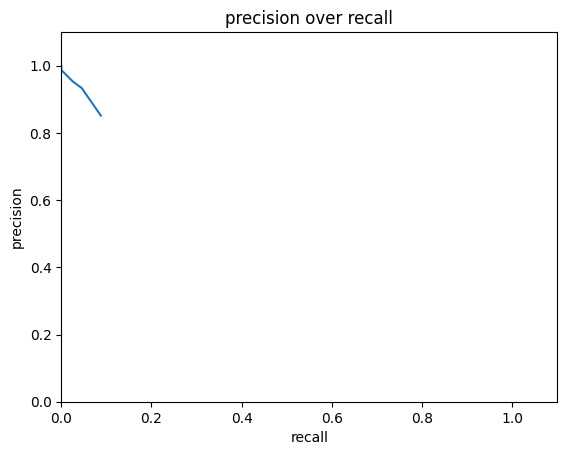

Training started.


100%|██████████| 17/17 [00:36<00:00,  2.15s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 37.82it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

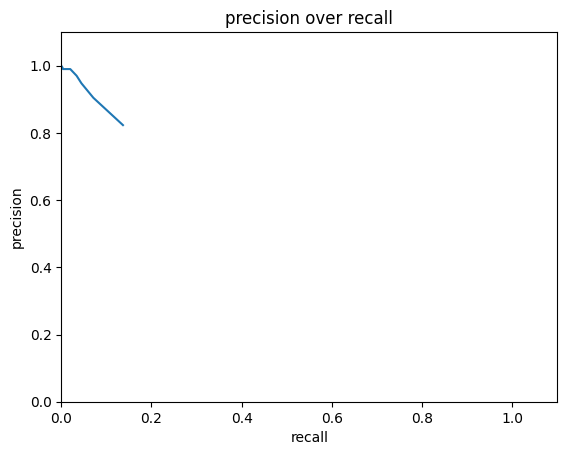

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.18s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 38.59it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

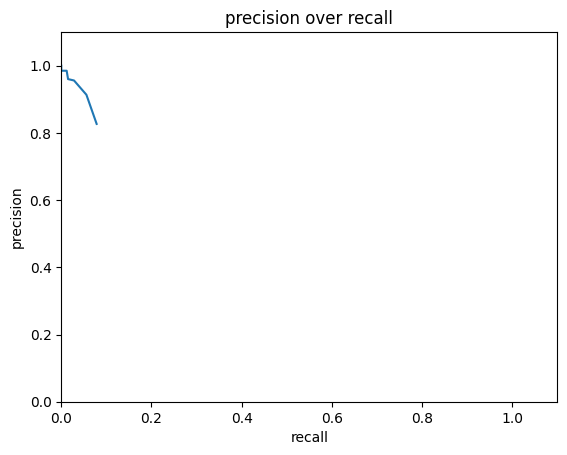

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.84s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.15it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

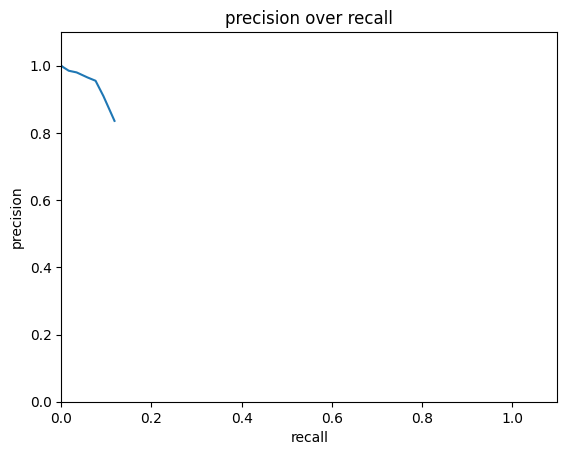

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 55.16it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

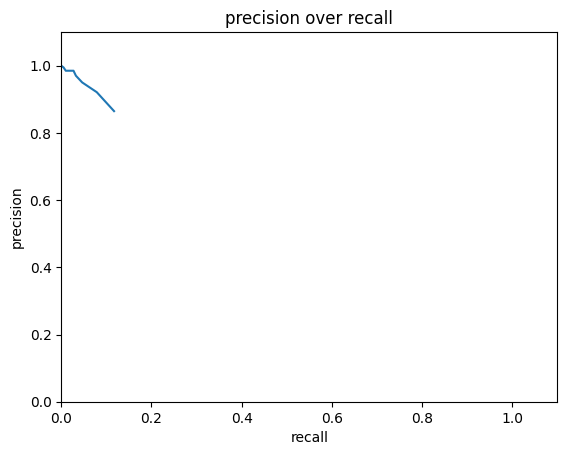

Training started.


100%|██████████| 17/17 [00:27<00:00,  1.63s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.58it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

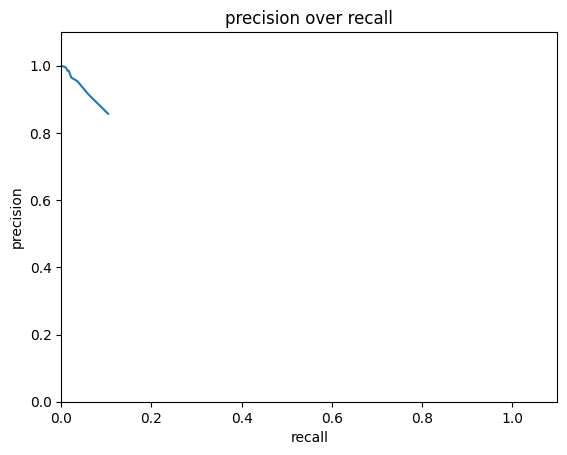

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.25it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

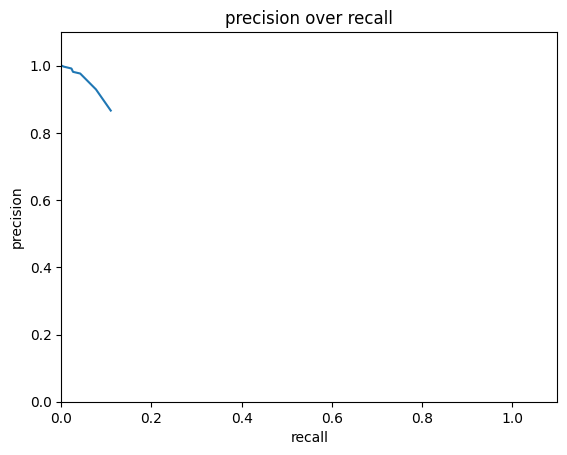

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.53it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

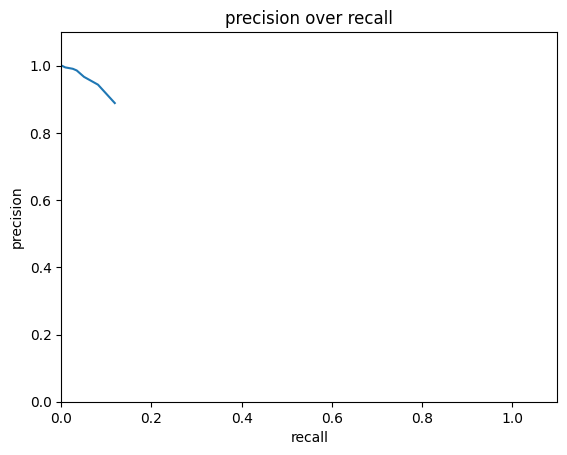

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.35it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

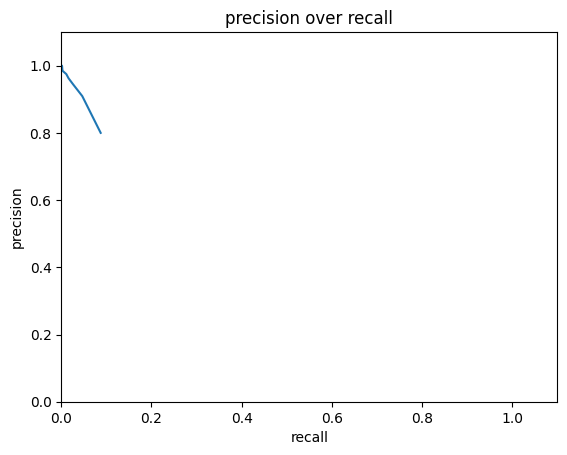

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 49.48it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

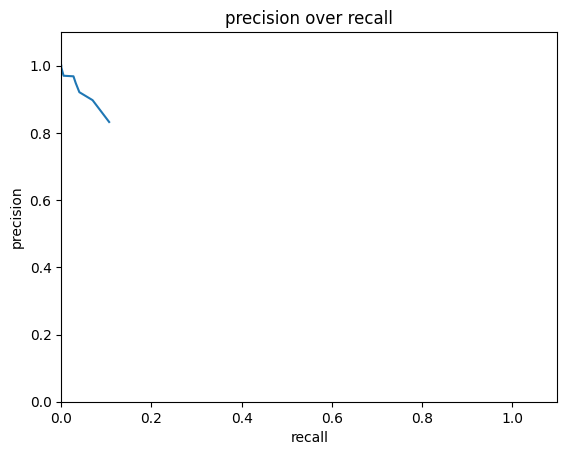

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.82it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

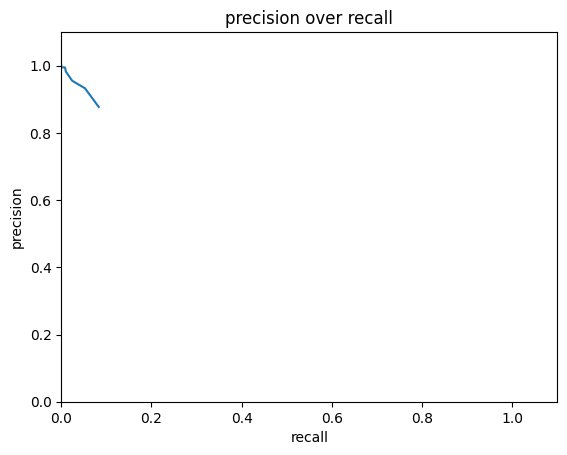

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 49.96it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

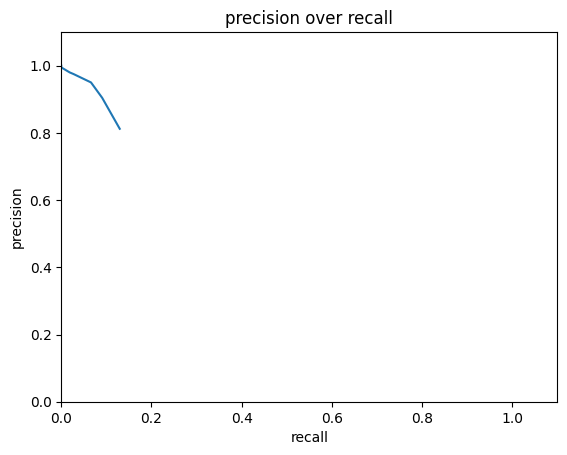

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.69s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 49.51it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

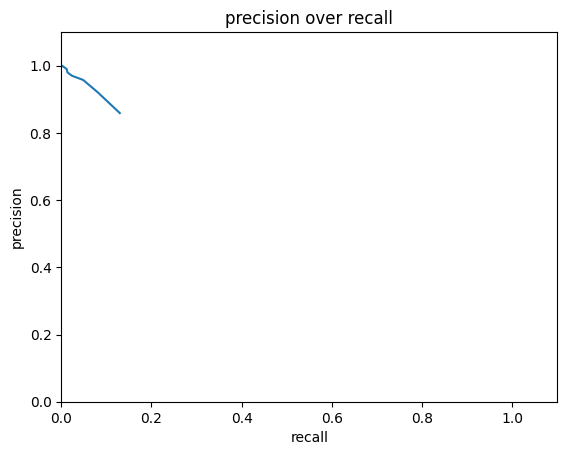

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.30it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

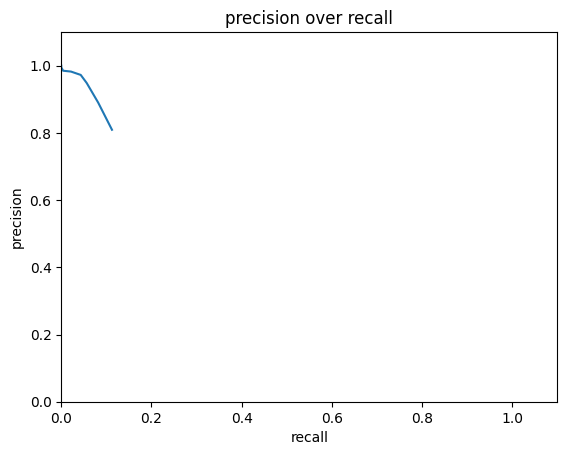

Training started.


100%|██████████| 17/17 [00:34<00:00,  2.06s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 41.61it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

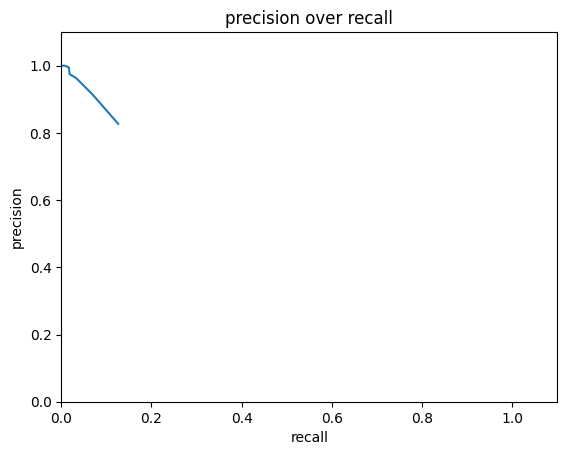

-----Pruning iteration 15/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.05it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

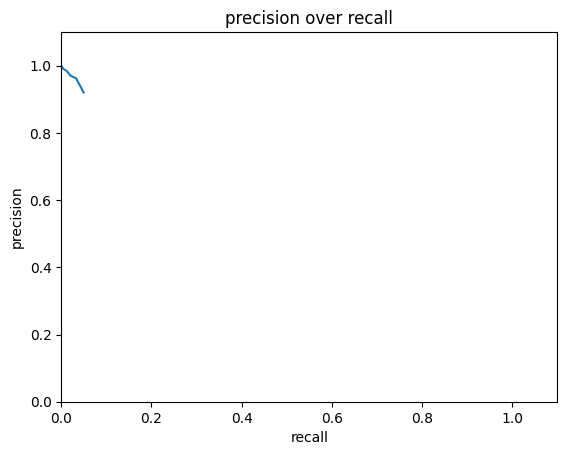

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.26s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 42.67it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

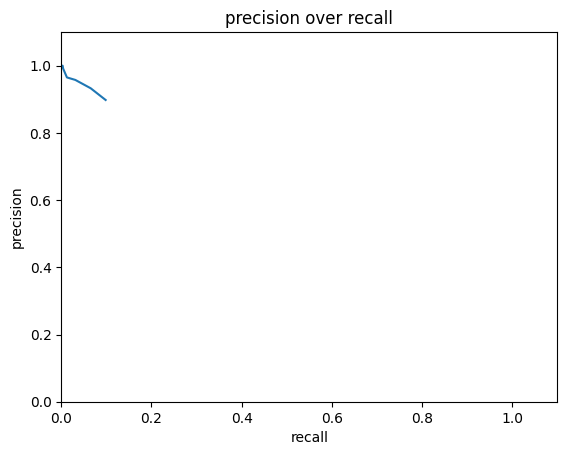

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 39.39it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

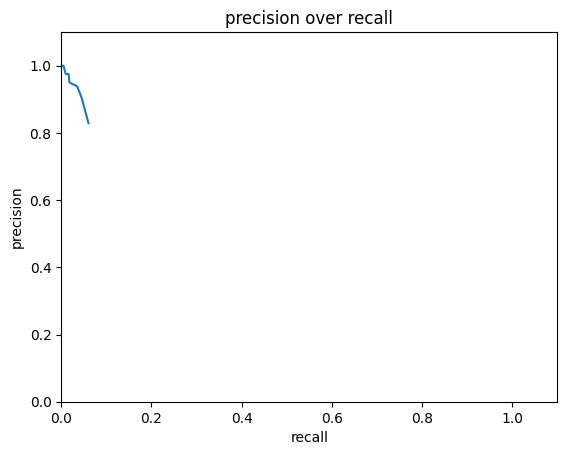

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.23s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 46.77it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

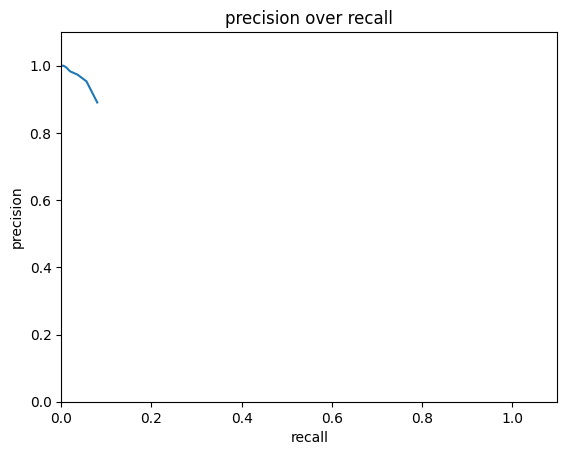

Training started.


100%|██████████| 17/17 [00:36<00:00,  2.13s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 45.82it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

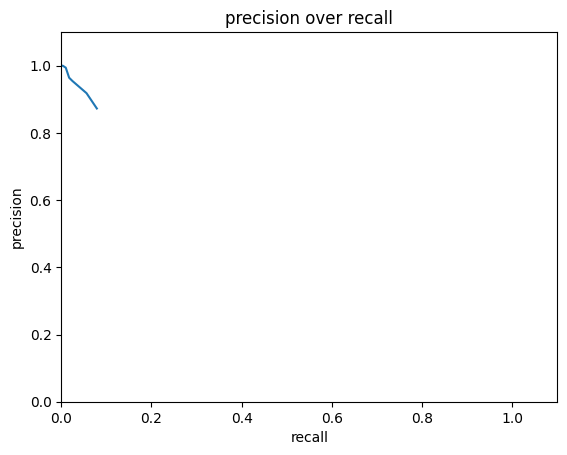

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.26s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.62it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

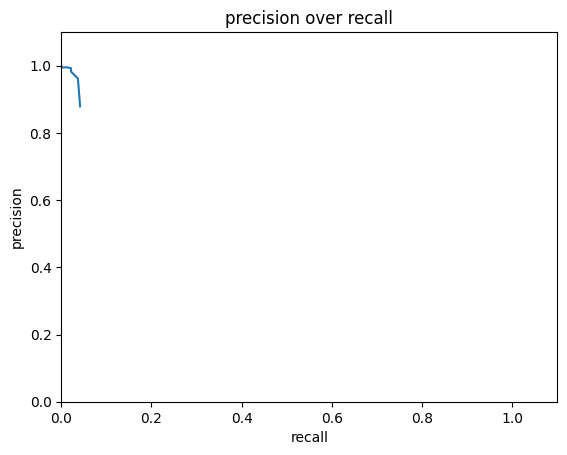

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.22s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 48.51it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

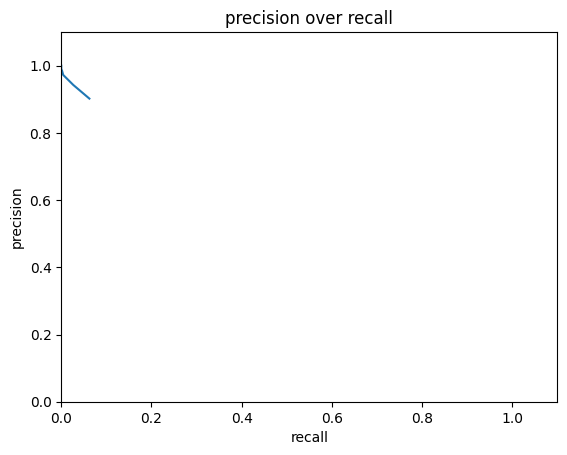

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 50.00it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

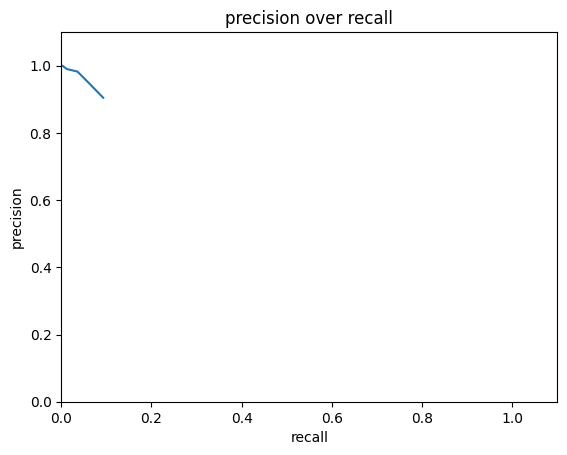

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.22s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 59.01it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

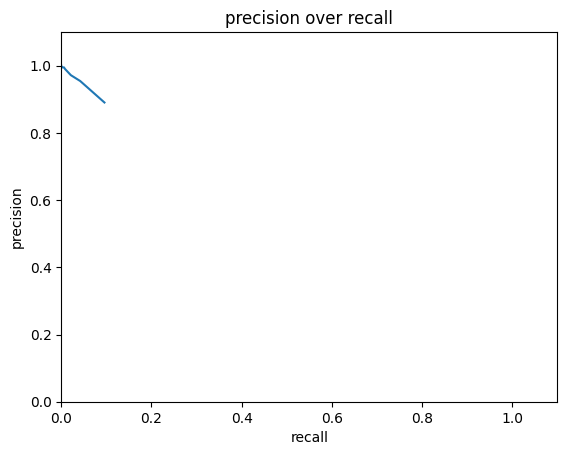

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 59.37it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

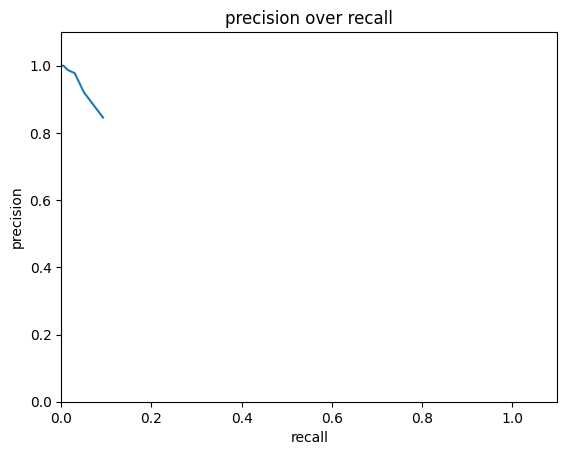

Training started.


100%|██████████| 17/17 [00:34<00:00,  2.04s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.91it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

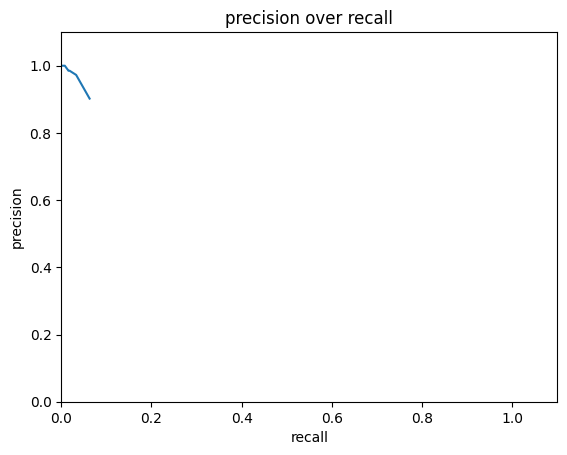

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 35.36it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

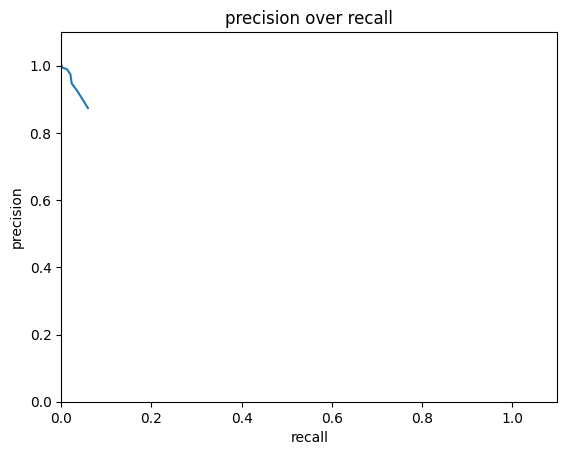

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.57s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.93it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

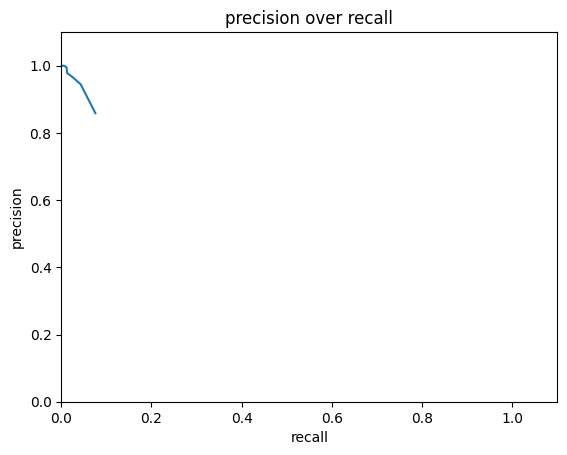

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.61s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.29it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

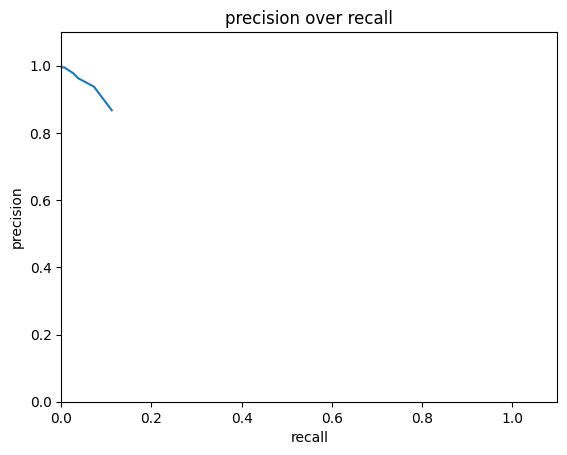

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.63s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.57it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

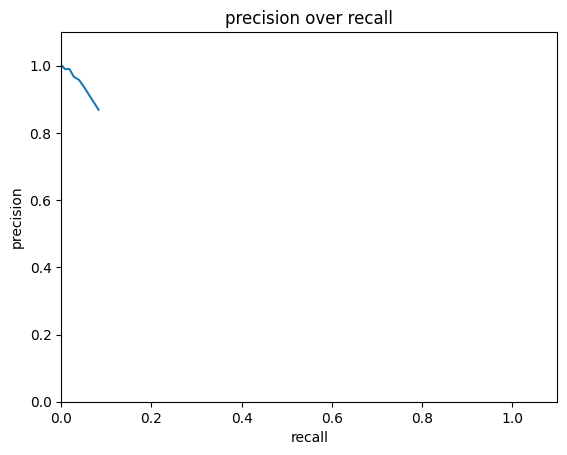

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.61s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.51it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

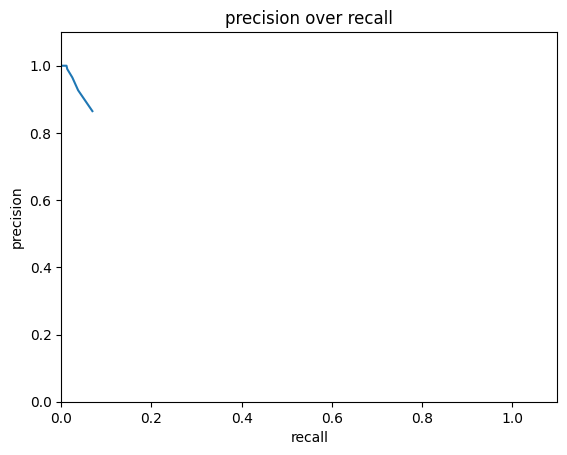

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.76s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.24it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

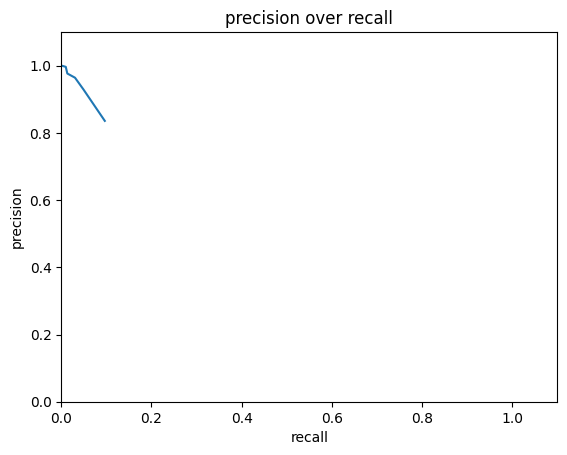

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.46it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

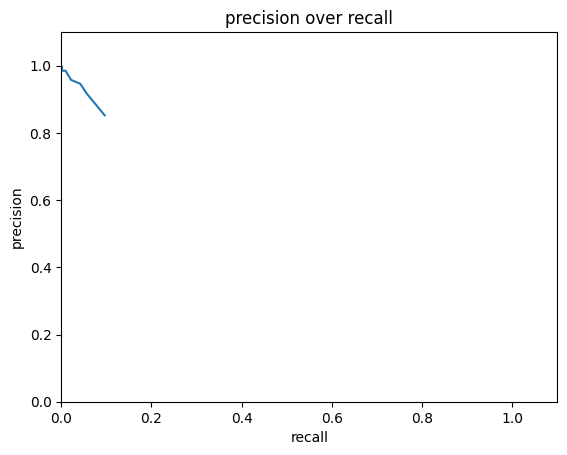

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.70s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.57it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

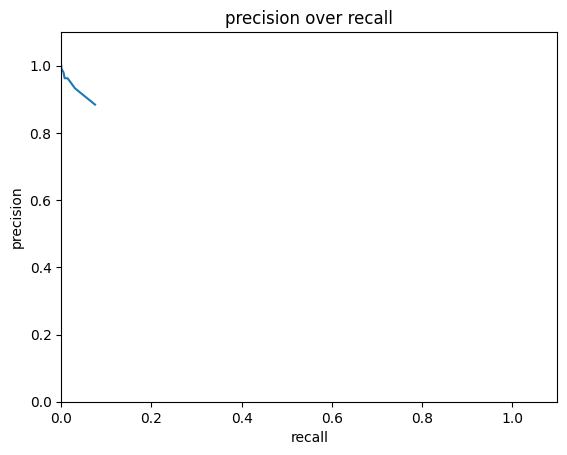

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.83it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

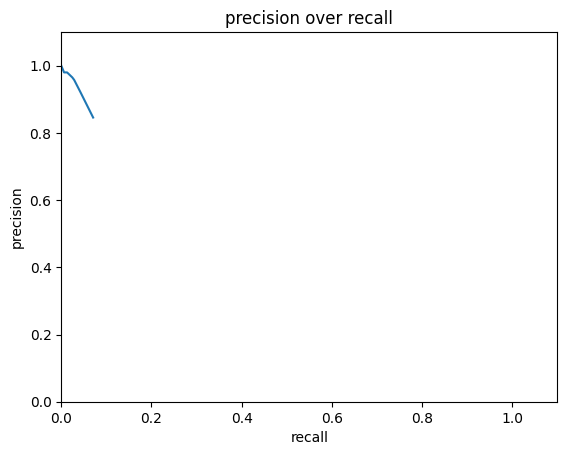

-----Pruning iteration 16/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.48it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

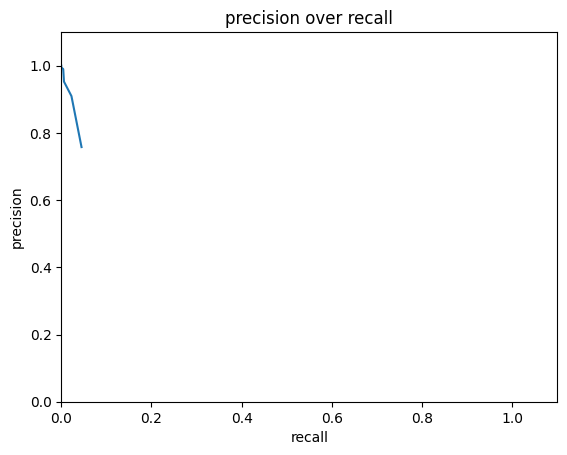

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.12it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

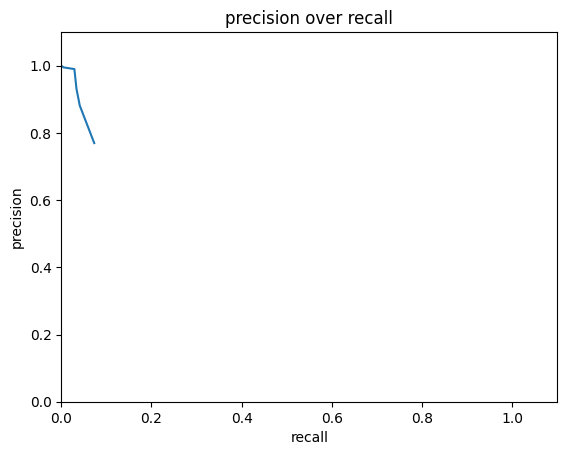

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.76s/it]


Validation started.


100%|██████████| 200/200 [00:10<00:00, 18.27it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

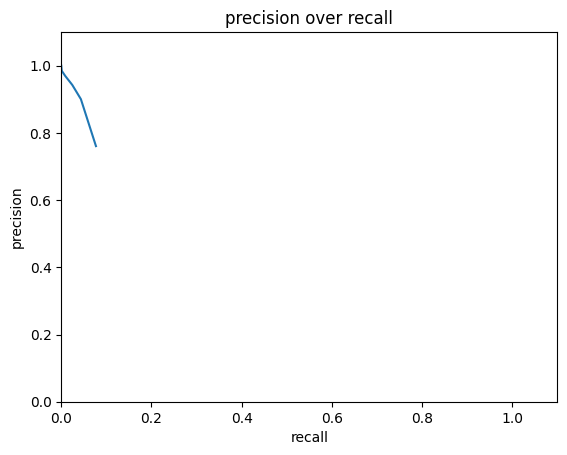

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.73s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.82it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

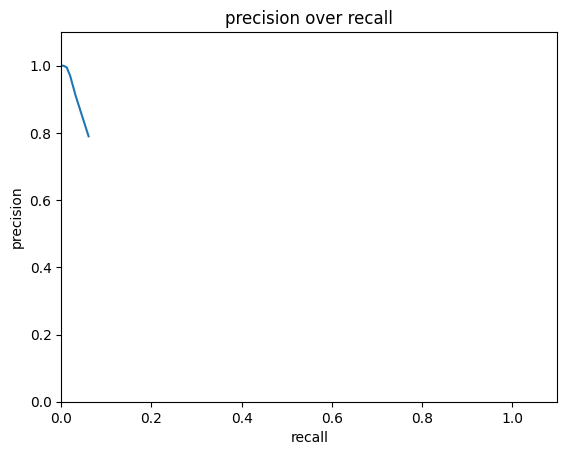

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.63it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

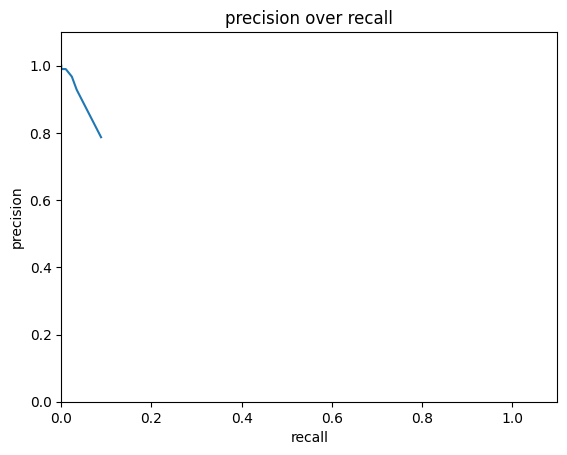

Training started.


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.96it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

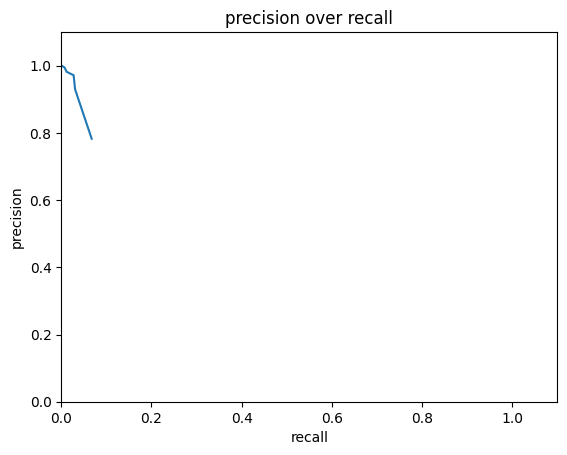

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.74s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.44it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

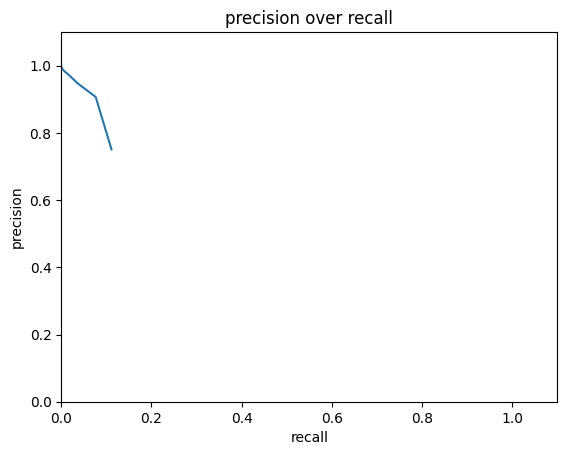

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.89it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

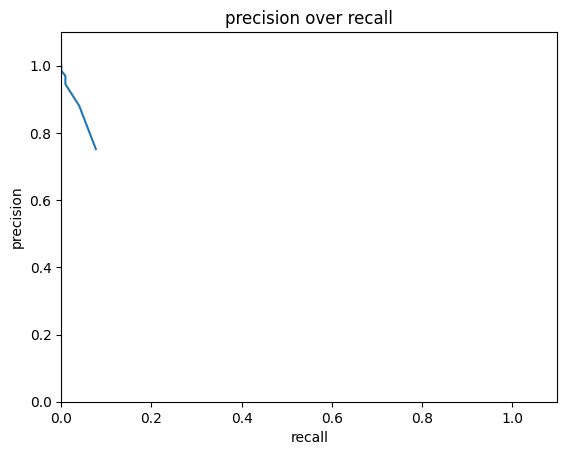

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.72s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.40it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

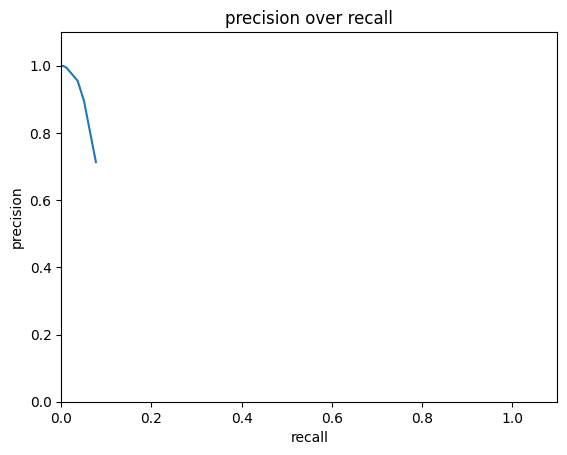

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.63s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.00it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

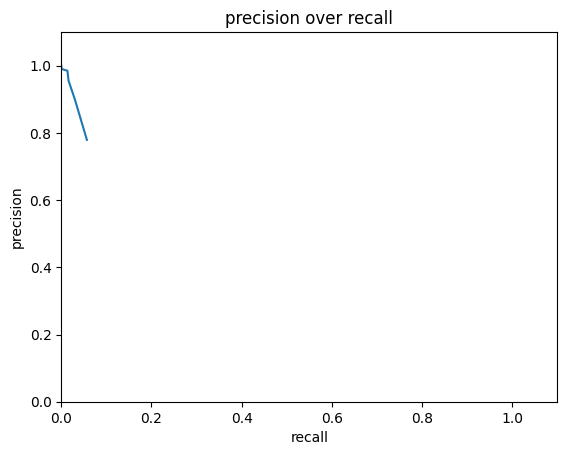

Training started.


100%|██████████| 17/17 [00:47<00:00,  2.77s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.14it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

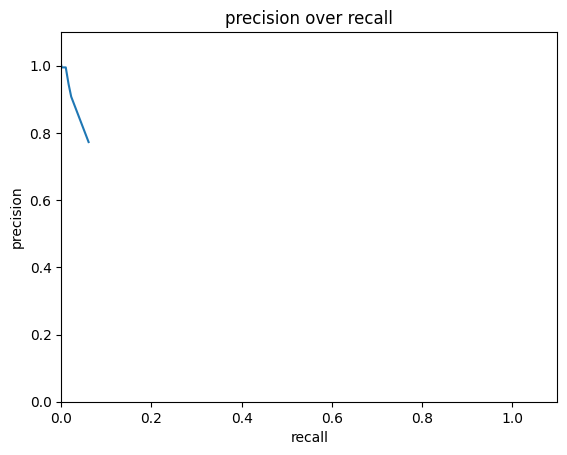

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 44.57it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

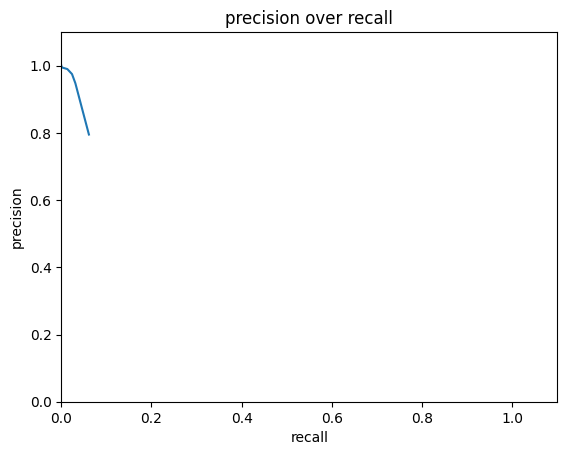

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.23s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.69it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

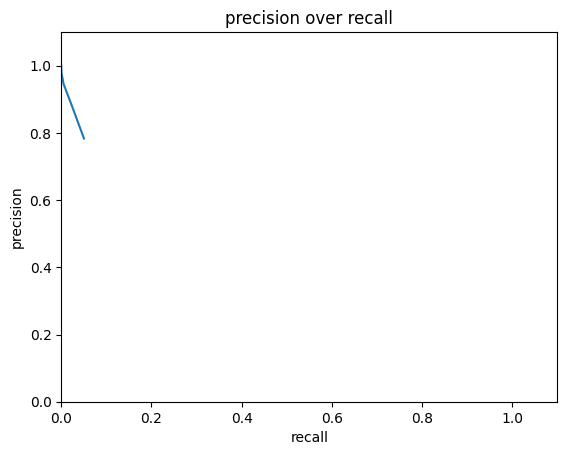

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.27s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 35.32it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

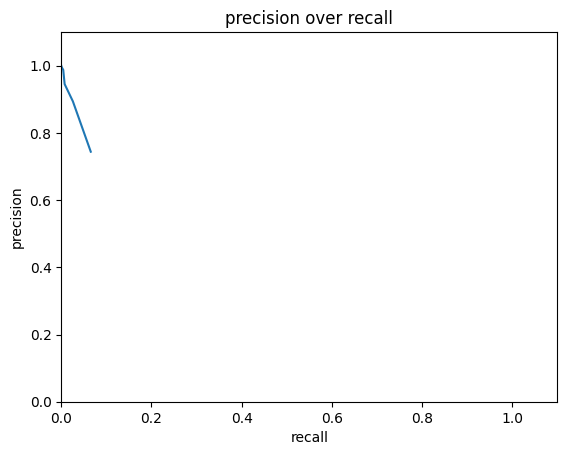

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.26s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.18it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

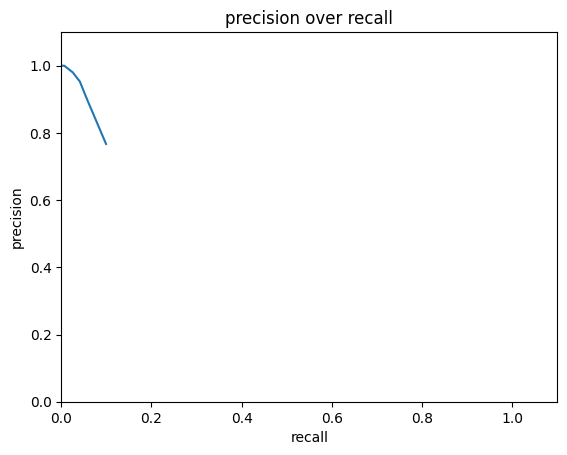

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.23s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 44.04it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

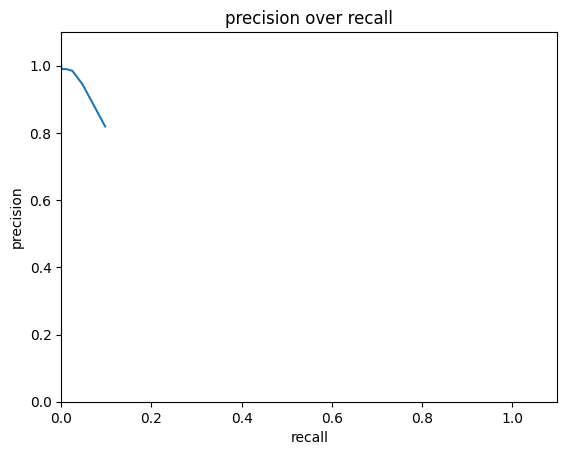

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 37.04it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

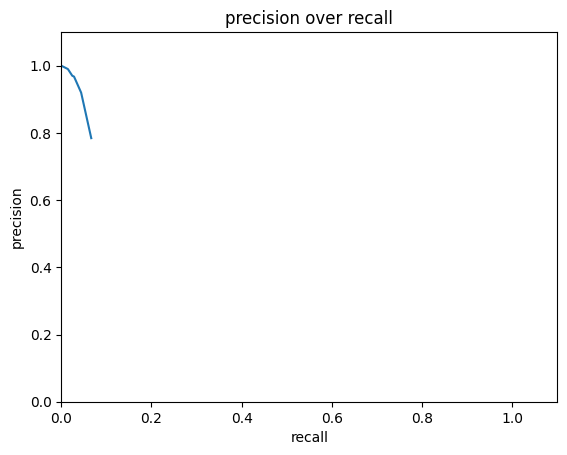

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.21s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 37.64it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

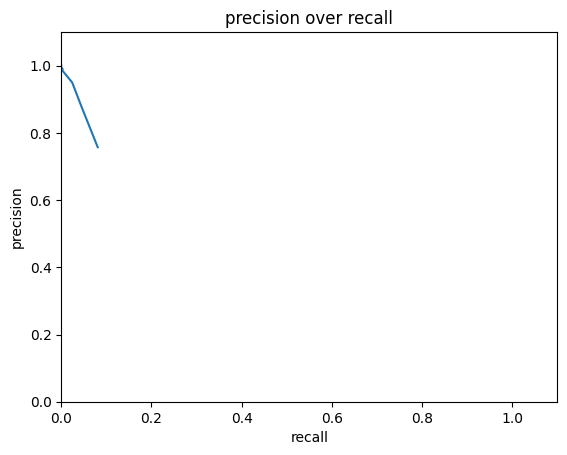

Training started.


100%|██████████| 17/17 [00:38<00:00,  2.26s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 41.34it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

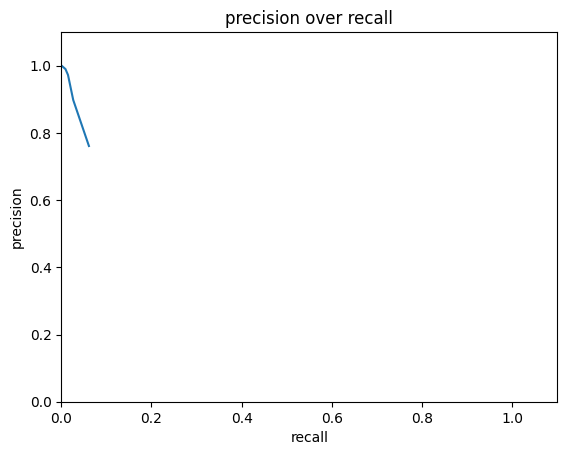

Training started.


100%|██████████| 17/17 [00:35<00:00,  2.10s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.78it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

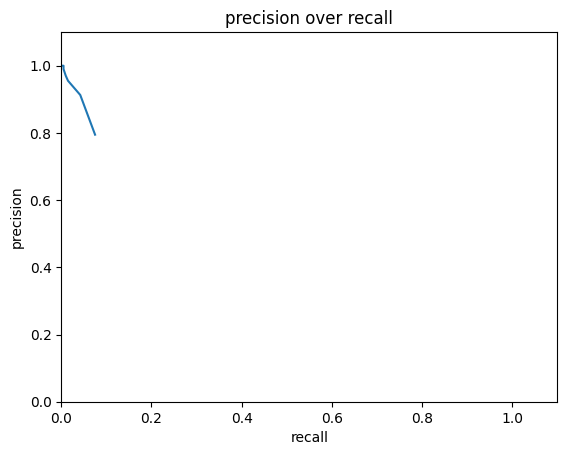

-----Pruning iteration 17/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:04<00:00, 41.80it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

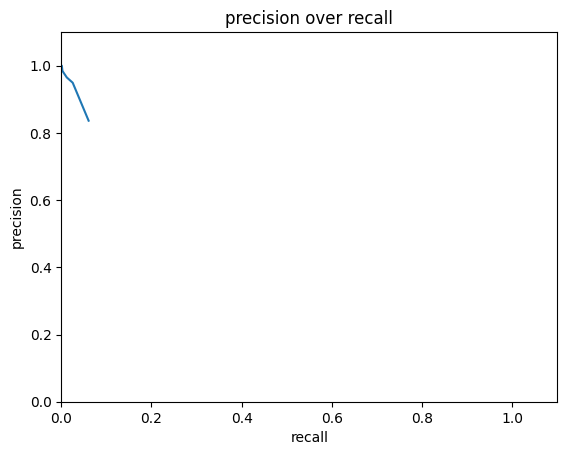

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.83s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 50.14it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

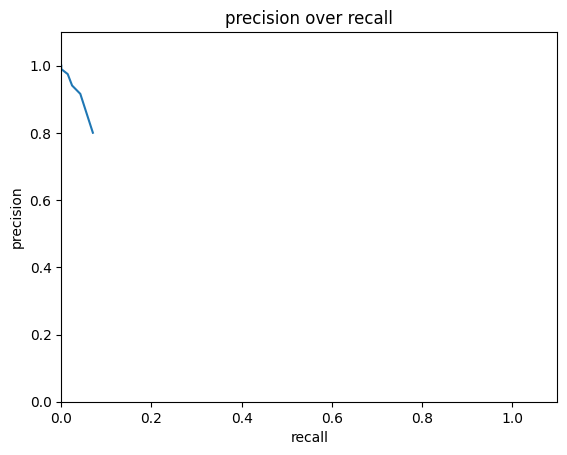

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.87s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 54.39it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

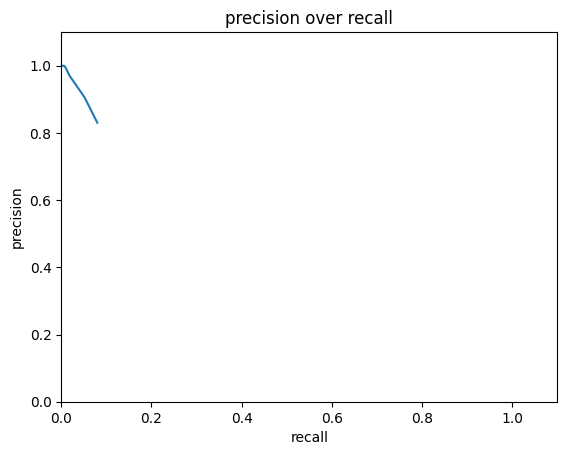

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.87s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 49.27it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

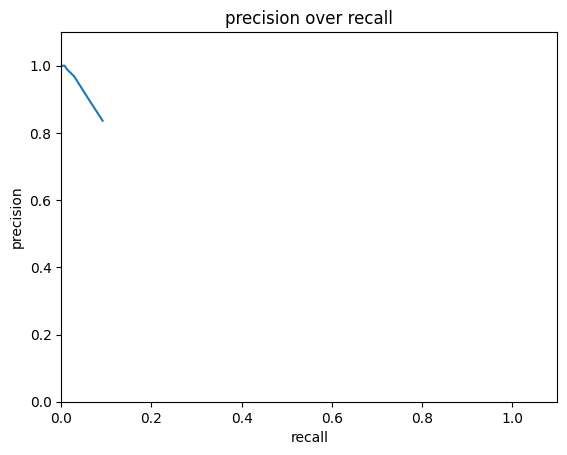

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.84s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.44it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

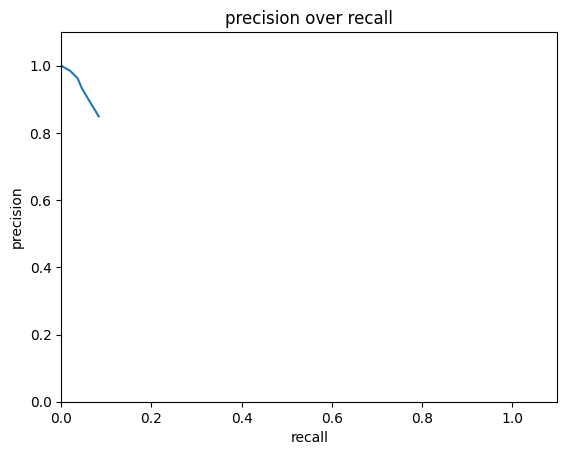

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.61s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 33.83it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

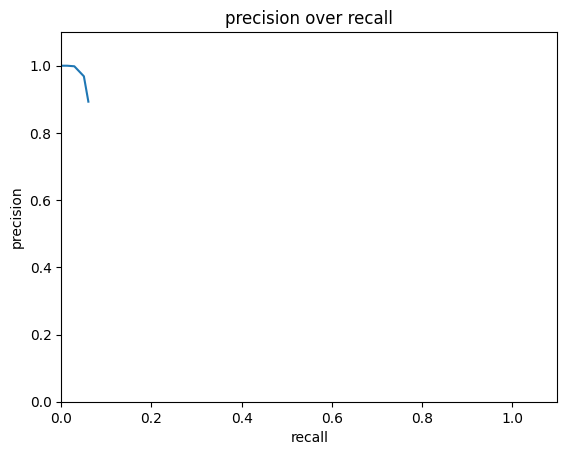

Training started.


100%|██████████| 17/17 [00:43<00:00,  2.55s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 55.26it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

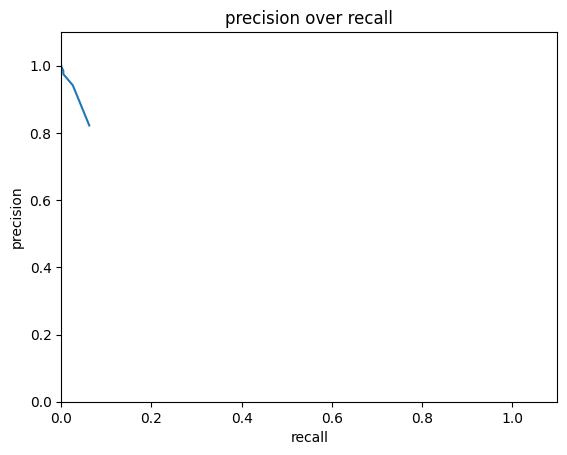

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 54.00it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

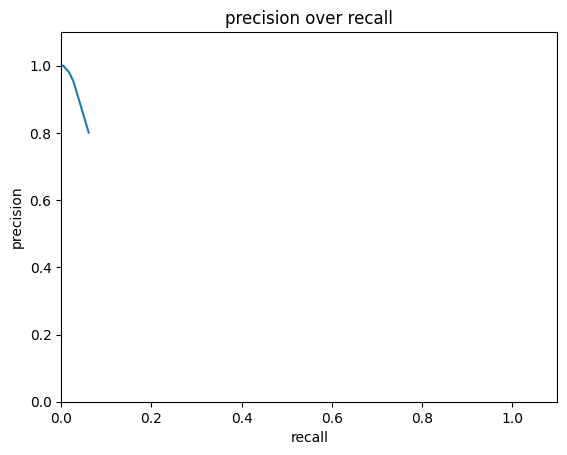

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 54.17it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

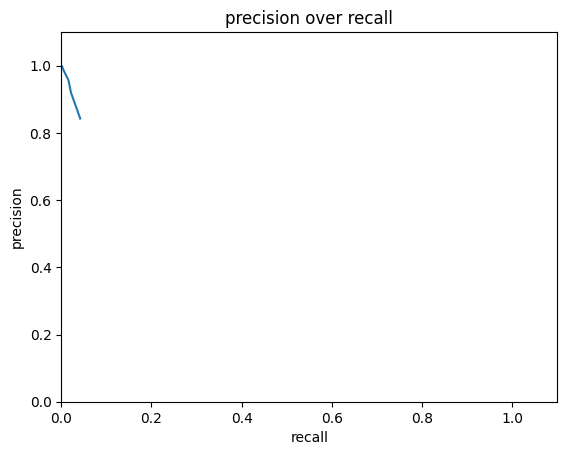

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 60.91it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

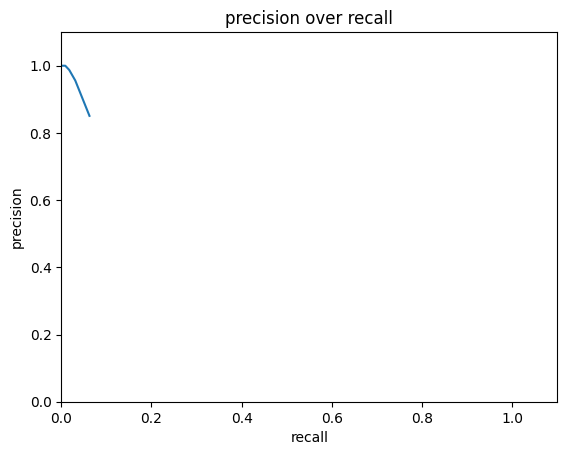

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.28it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

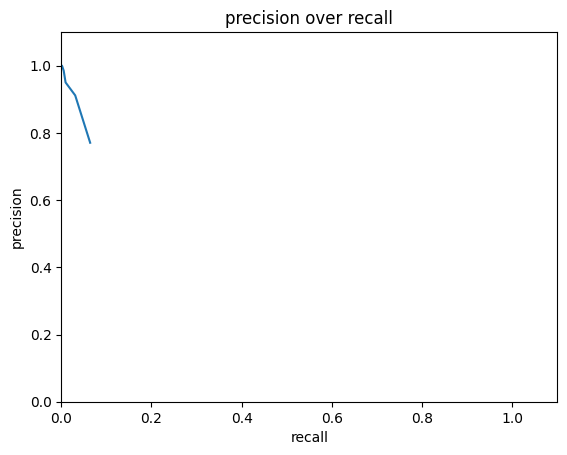

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.82s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.89it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

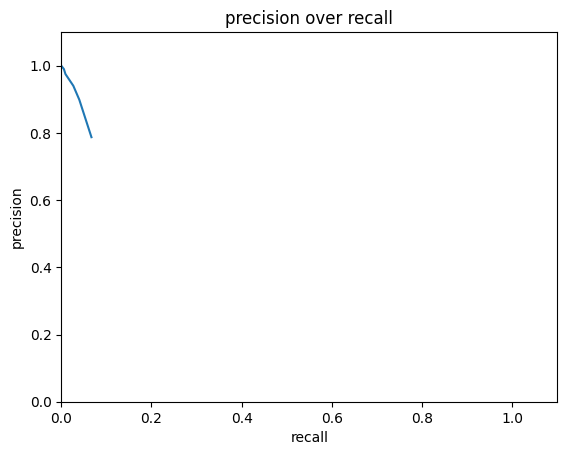

Training started.


100%|██████████| 17/17 [00:33<00:00,  1.96s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.06it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

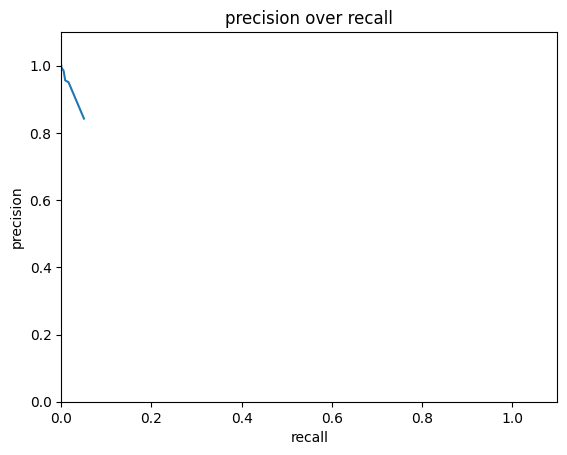

Training started.


100%|██████████| 17/17 [00:46<00:00,  2.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.44it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

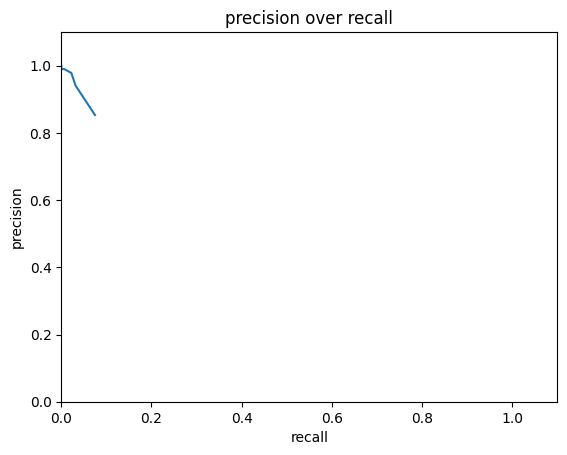

Training started.


100%|██████████| 17/17 [00:37<00:00,  2.19s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 56.16it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

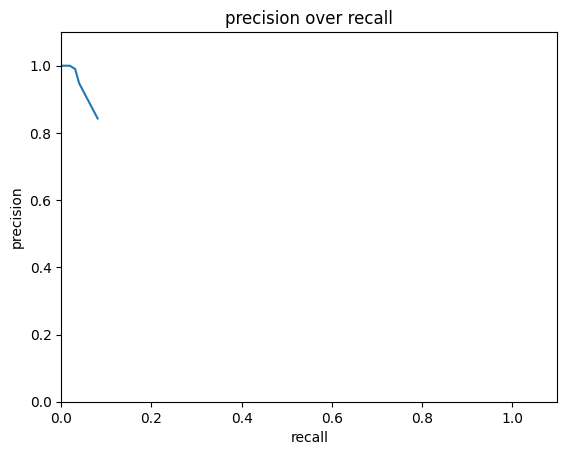

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.73it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

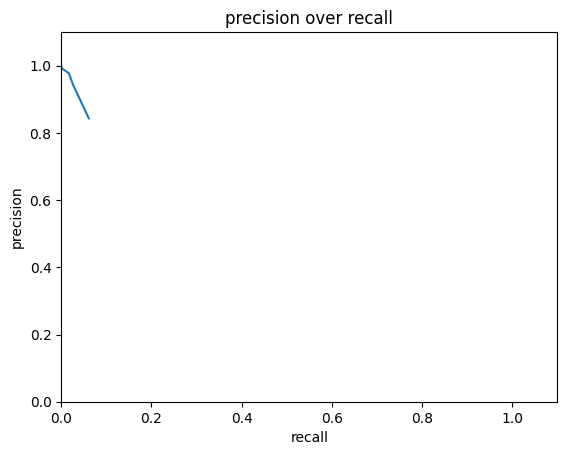

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 55.37it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

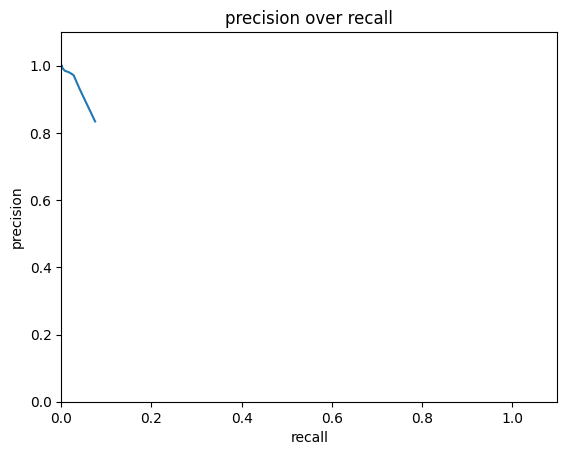

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 59.70it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

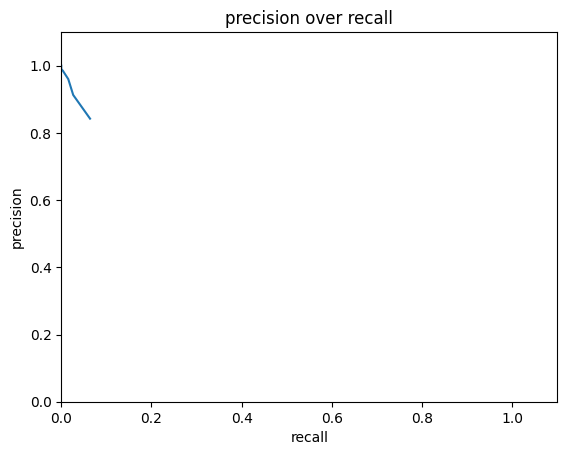

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.87s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 56.60it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

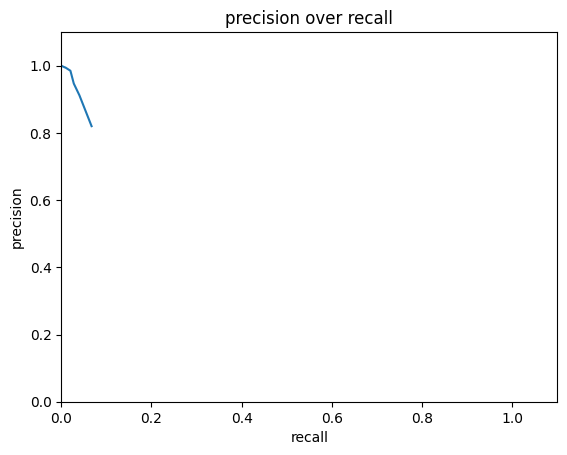

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 54.84it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

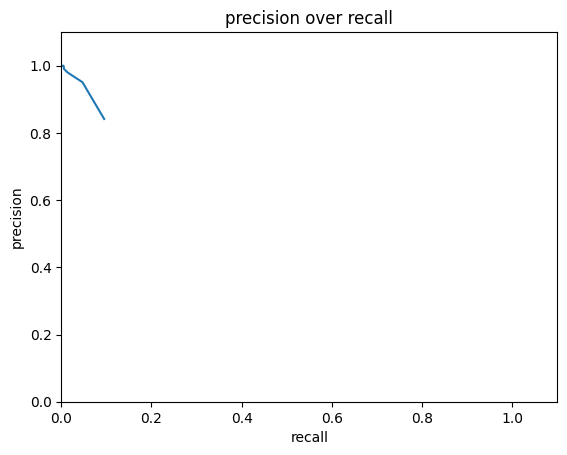

-----Pruning iteration 18/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.84it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

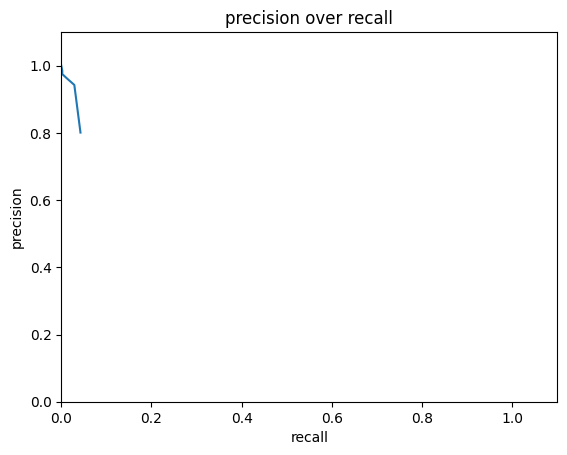

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 49.68it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

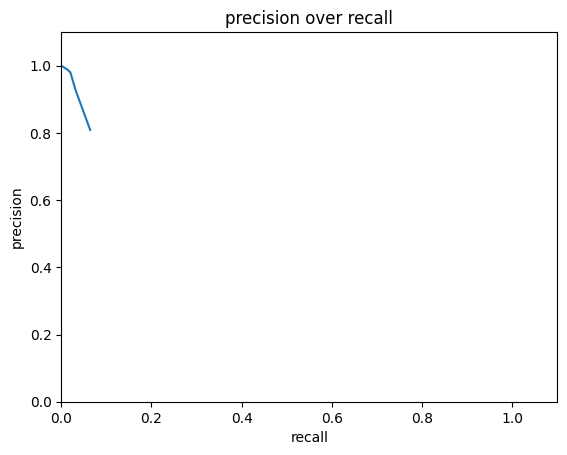

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.46it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

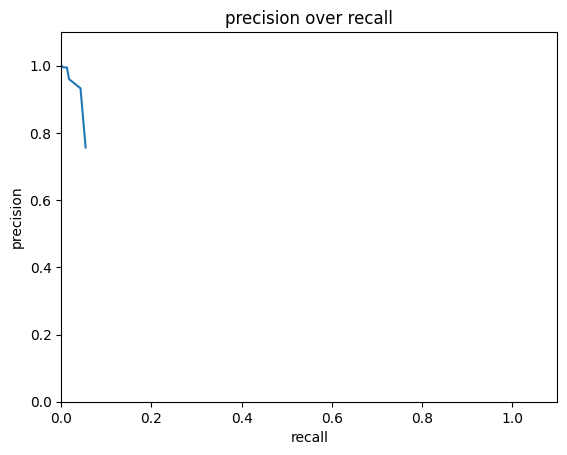

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 64.33it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

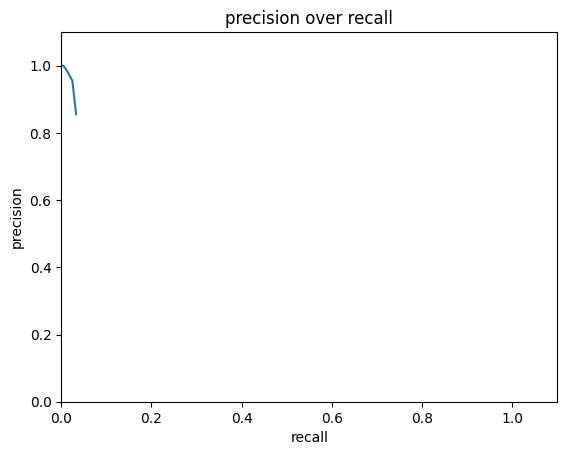

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 63.64it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

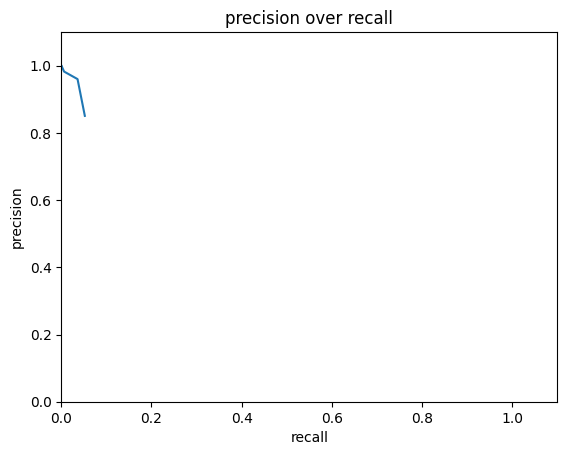

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 40.87it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

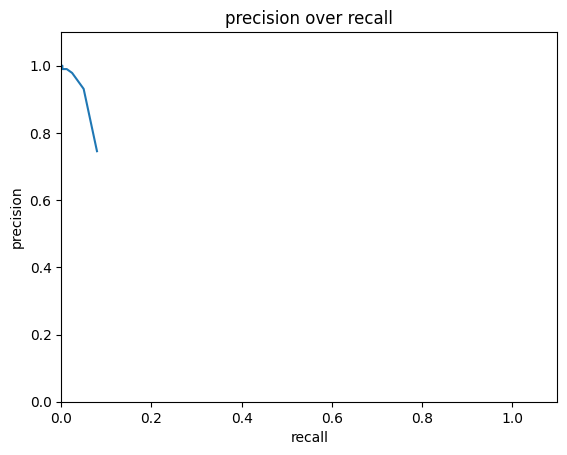

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.85s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 43.97it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

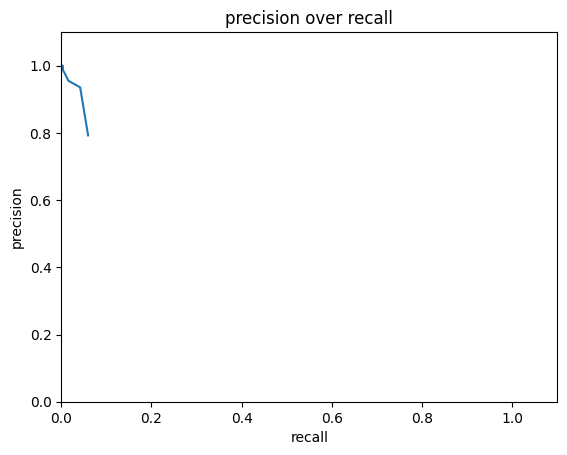

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 39.05it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

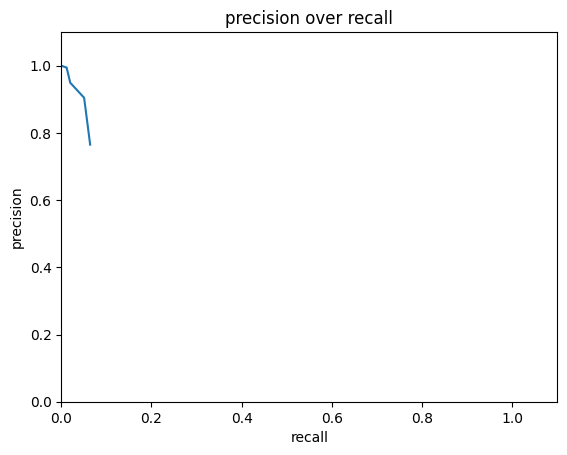

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 49.70it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

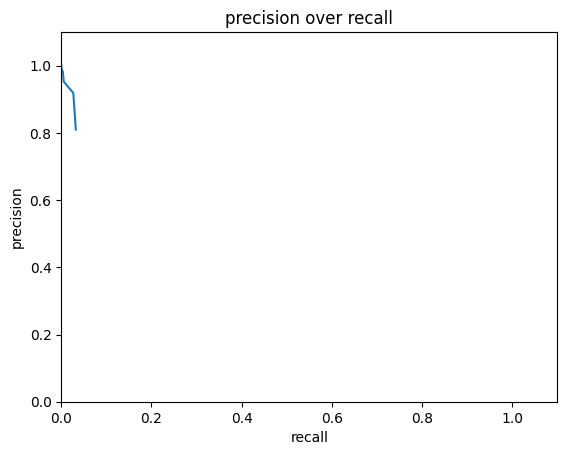

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 56.11it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

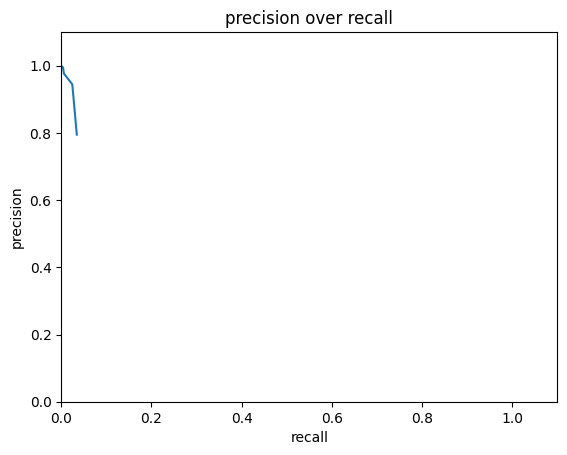

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 47.89it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

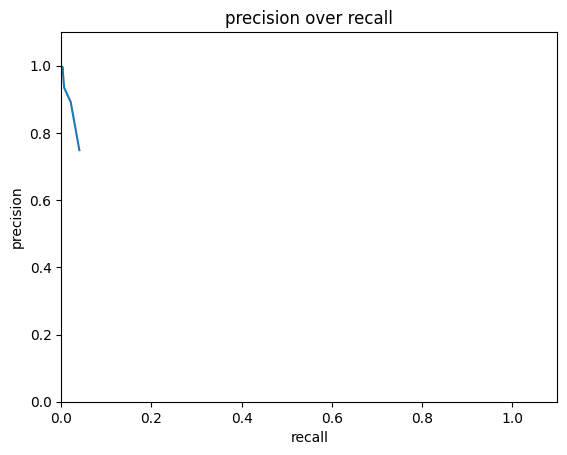

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 50.58it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

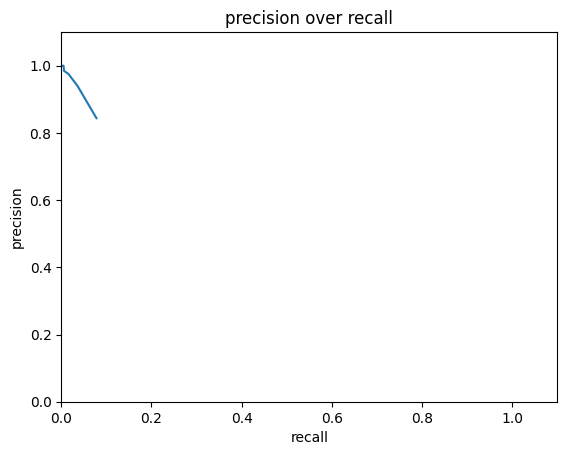

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.65it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

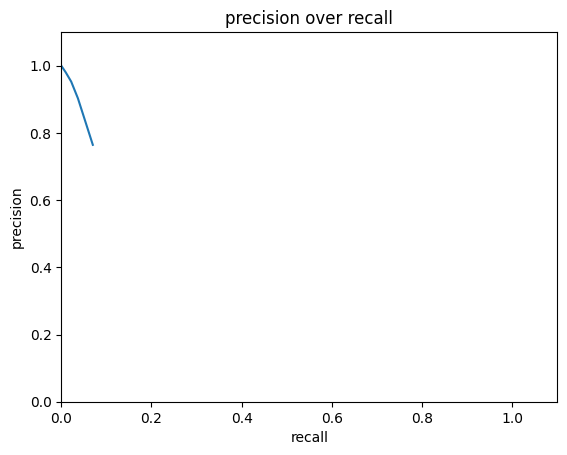

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.64it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

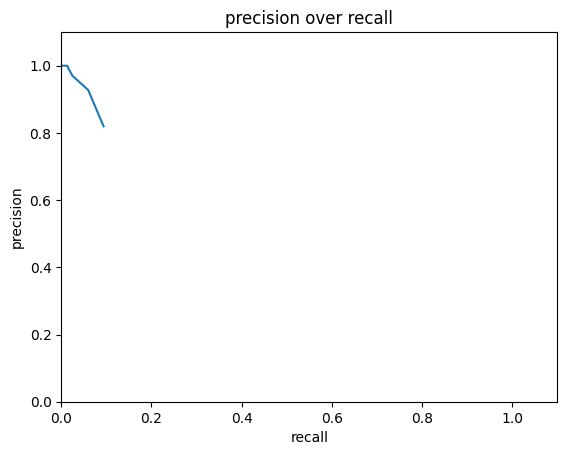

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.82s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 52.44it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

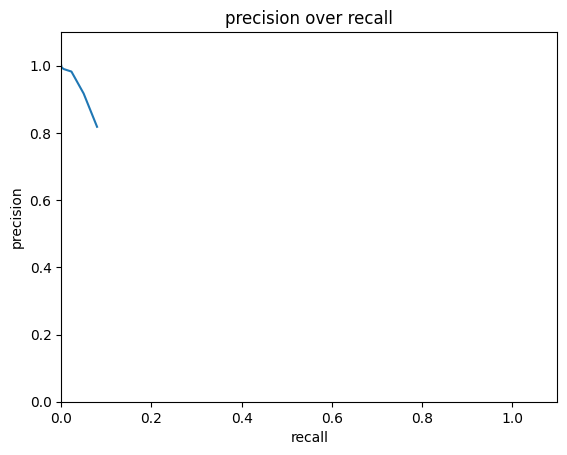

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 51.67it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

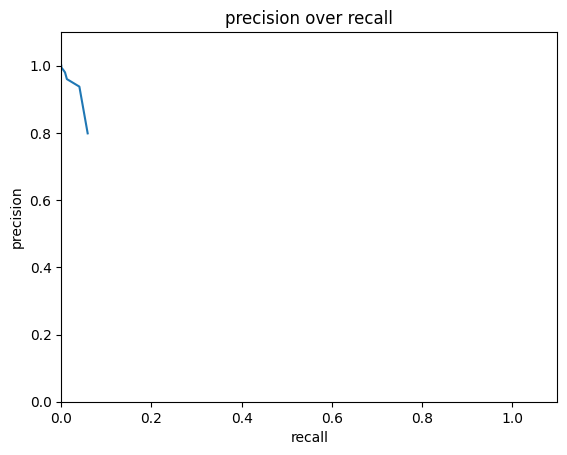

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 40.61it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

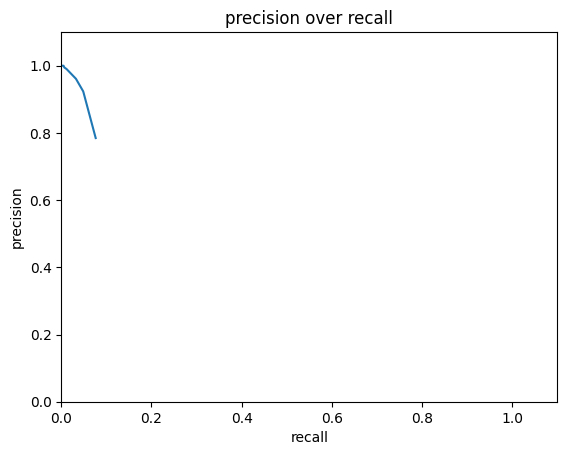

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.75s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.37it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

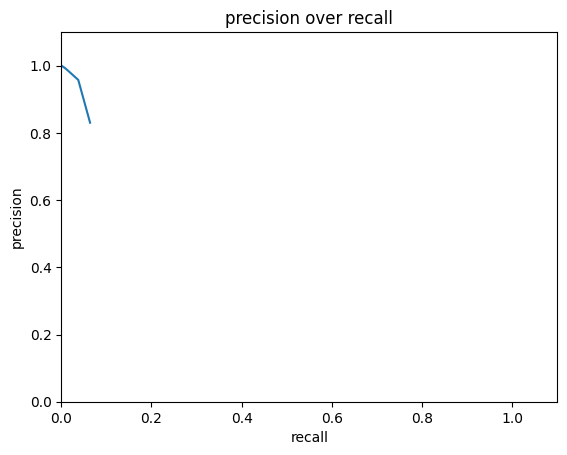

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:03<00:00, 53.20it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

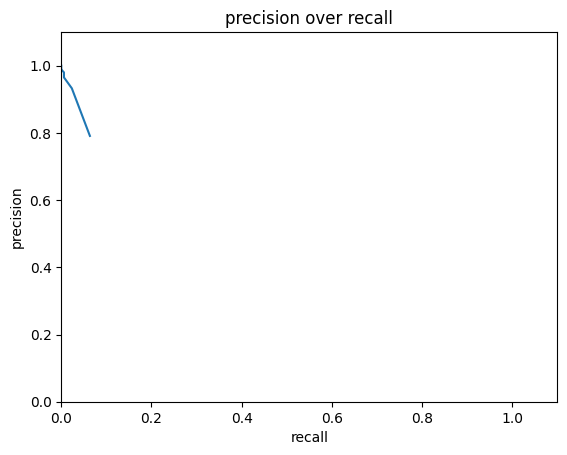

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


Validation started.


100%|██████████| 200/200 [00:04<00:00, 48.17it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

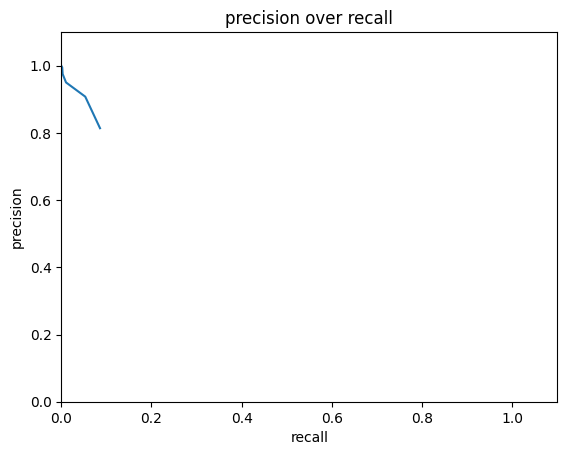

-----Pruning iteration 19/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.56it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

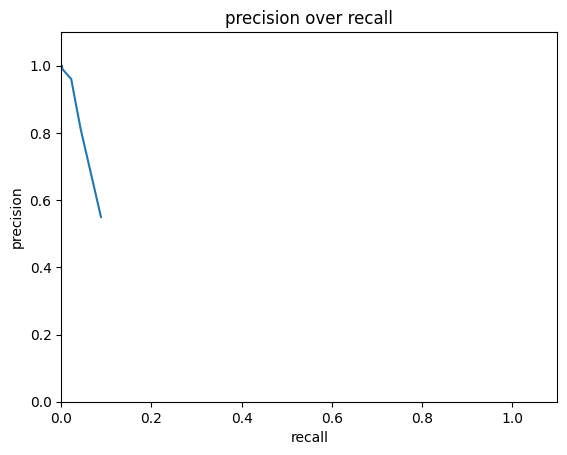

Training started.


100%|██████████| 17/17 [00:39<00:00,  2.32s/it]


Validation started.


100%|██████████| 200/200 [00:11<00:00, 17.06it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

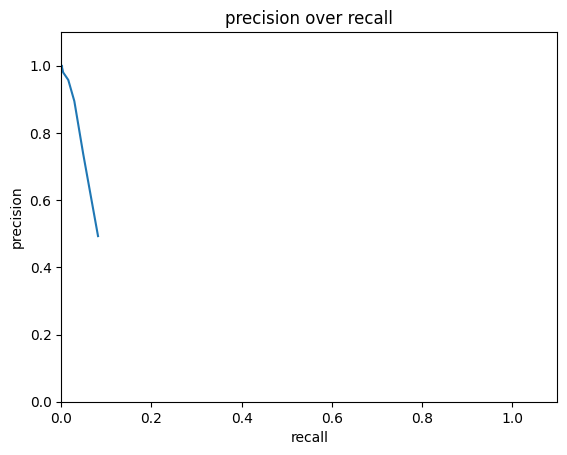

Training started.


100%|██████████| 17/17 [00:44<00:00,  2.61s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 21.99it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

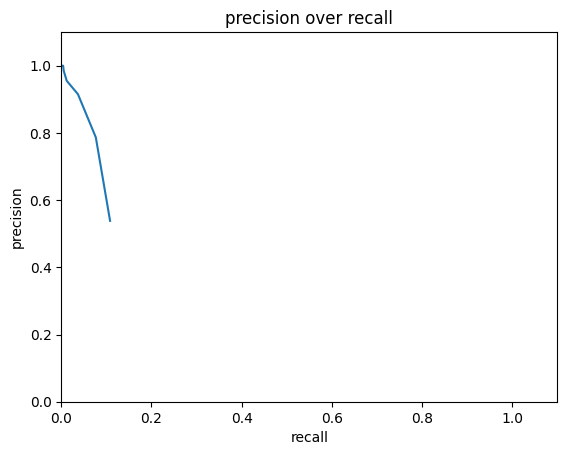

Training started.


100%|██████████| 17/17 [00:36<00:00,  2.15s/it]


Validation started.


100%|██████████| 200/200 [00:09<00:00, 22.08it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

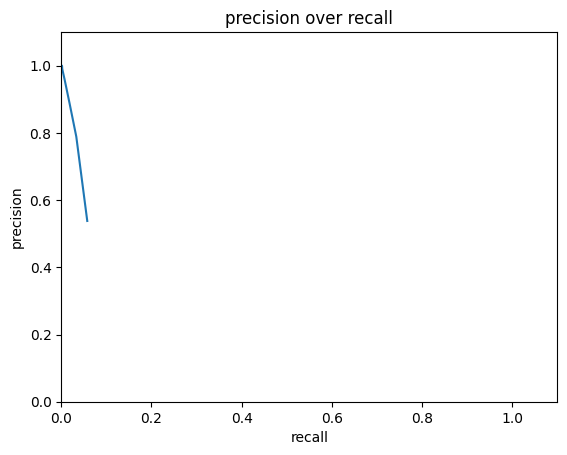

Training started.


100%|██████████| 17/17 [00:36<00:00,  2.16s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.41it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

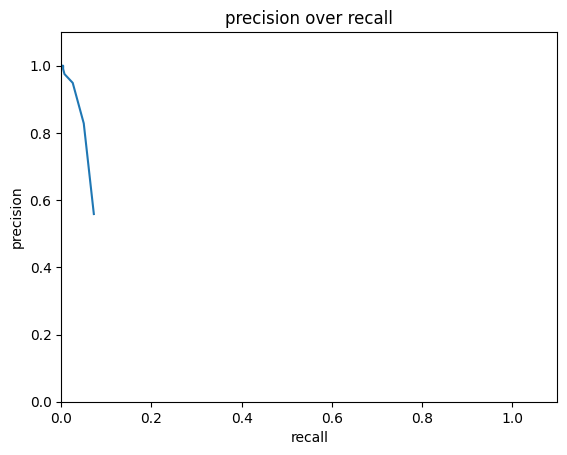

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.32it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

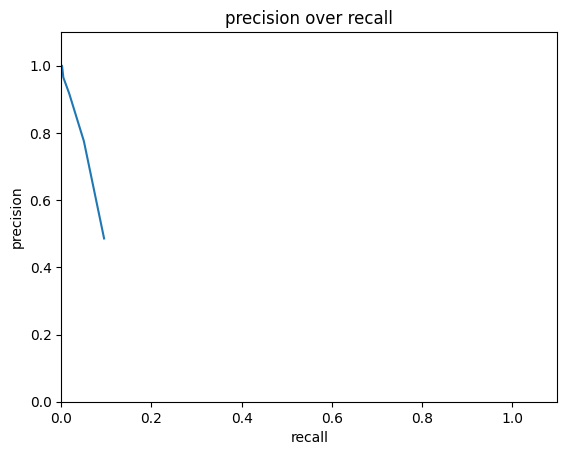

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.47it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

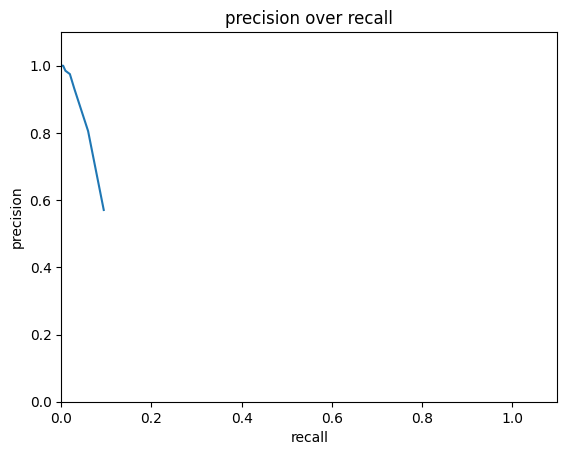

Training started.


100%|██████████| 17/17 [00:32<00:00,  1.90s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.57it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

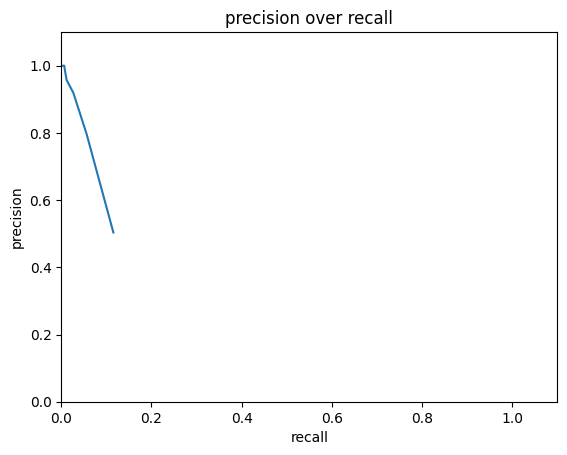

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.78it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

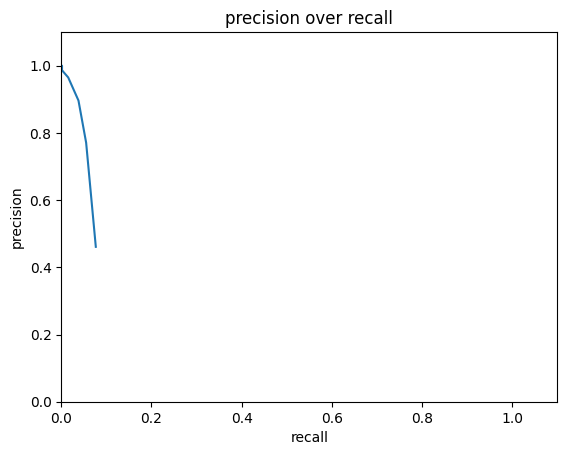

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 36.11it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

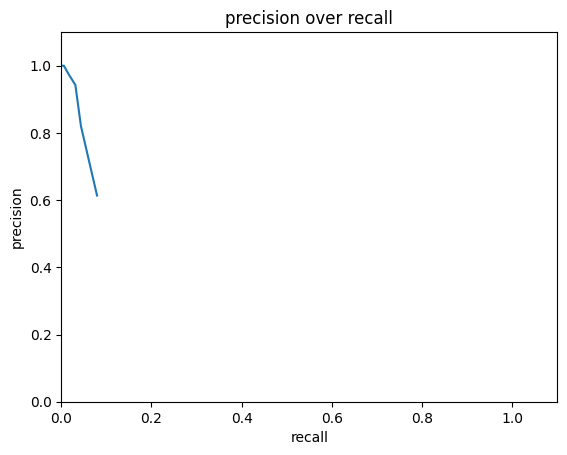

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.77it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

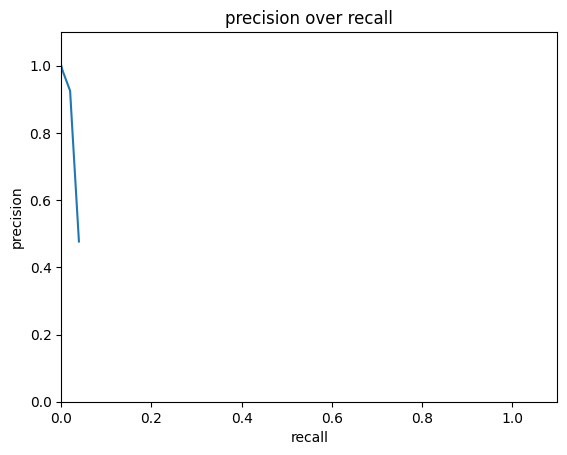

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.28it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

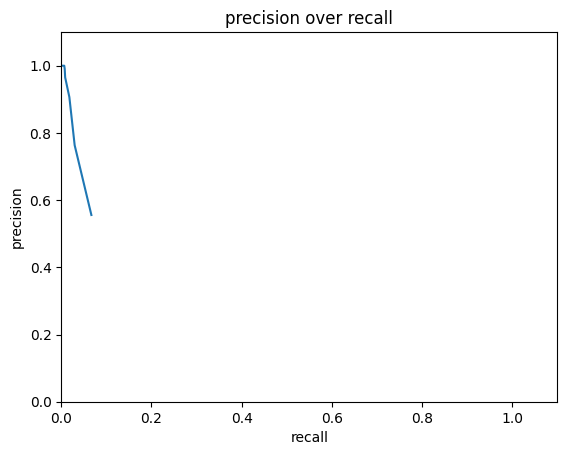

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 29.01it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

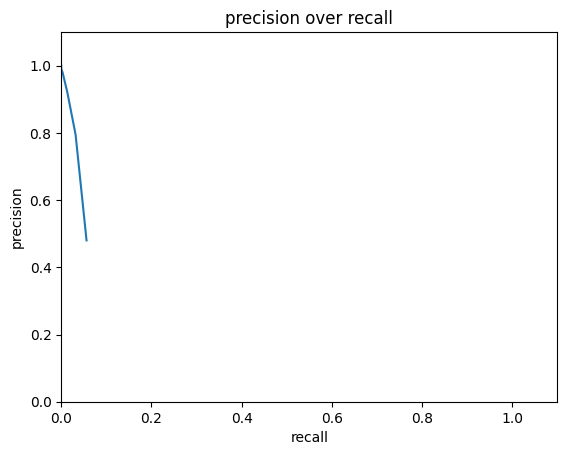

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.84s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.17it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

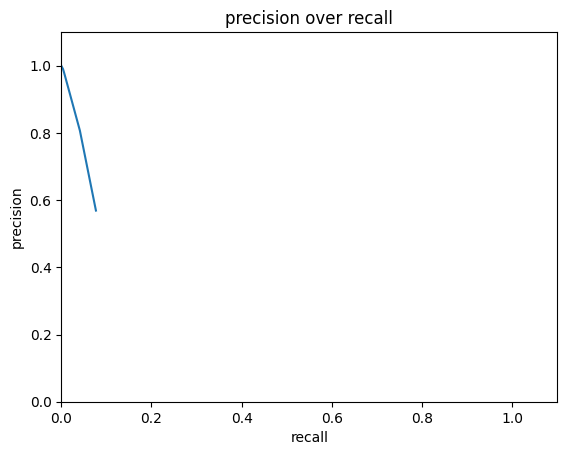

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.68s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 31.06it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

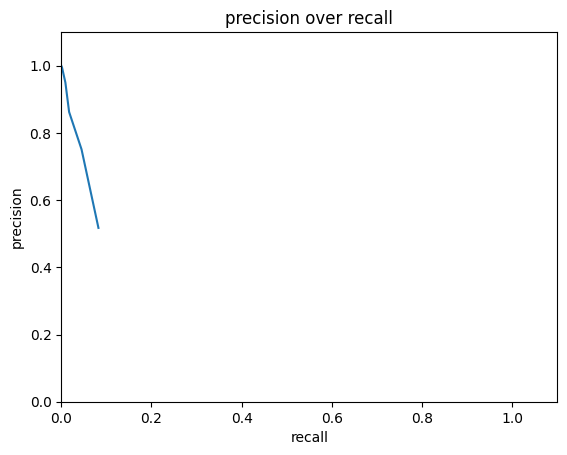

Training started.


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.04it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

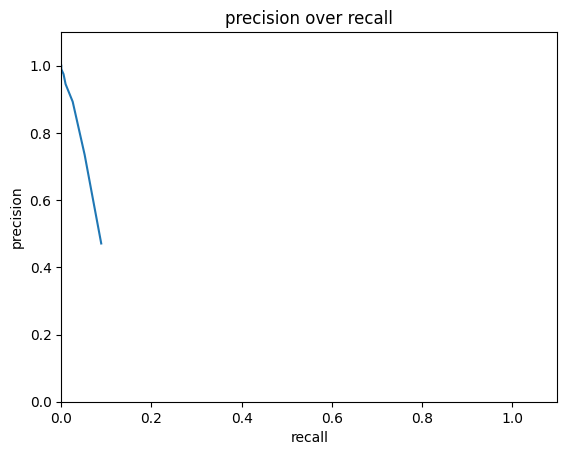

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.33it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

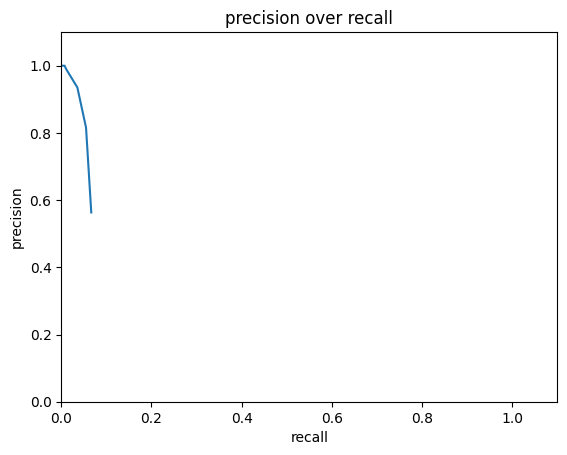

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.41it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

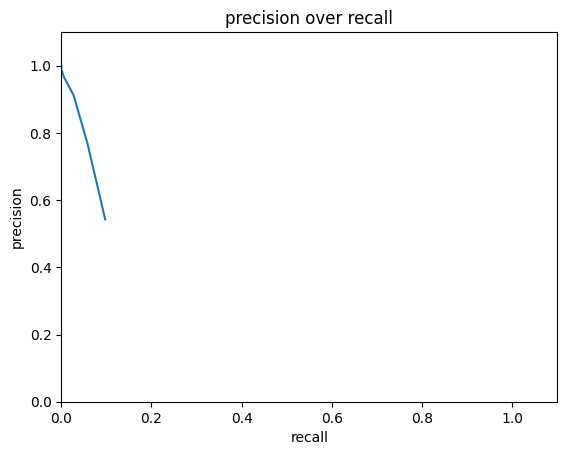

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.08it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

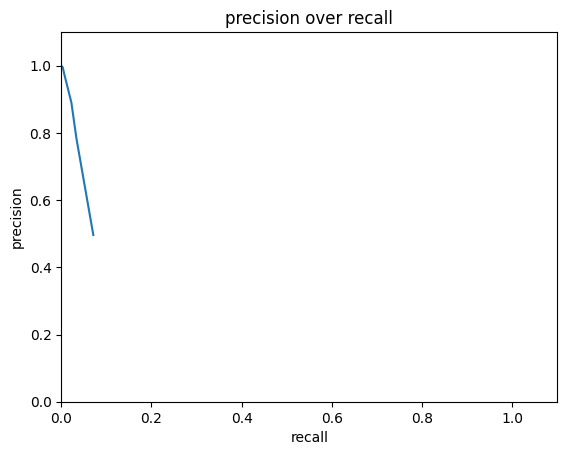

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.73it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

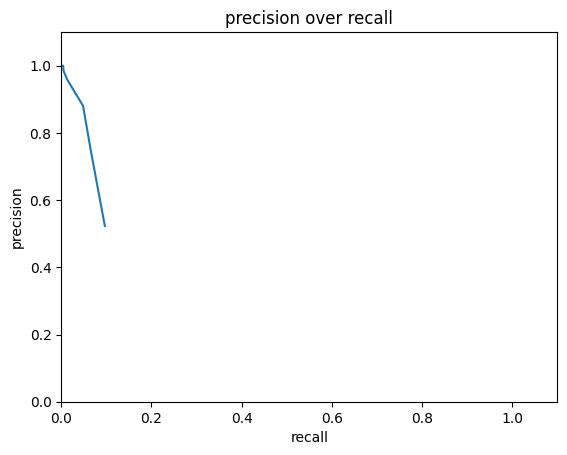

-----Pruning iteration 20/20-----
Pruning done.
Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.57it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

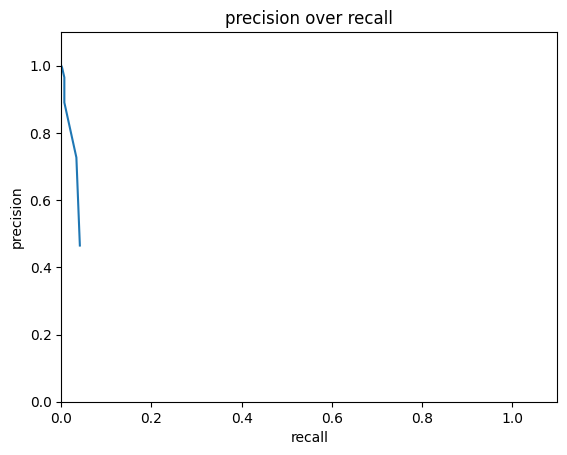

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.65it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

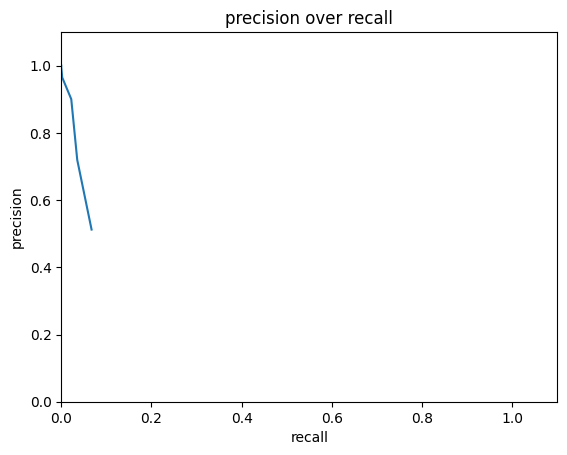

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.74s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.08it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

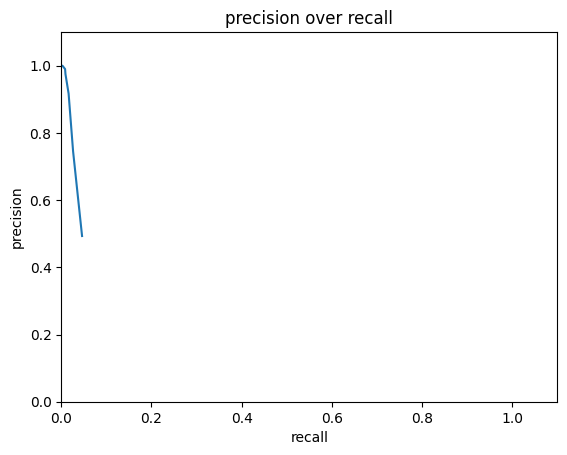

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.13it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

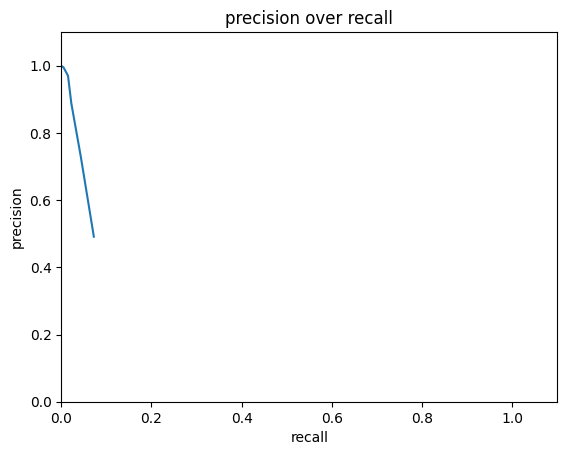

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.34it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

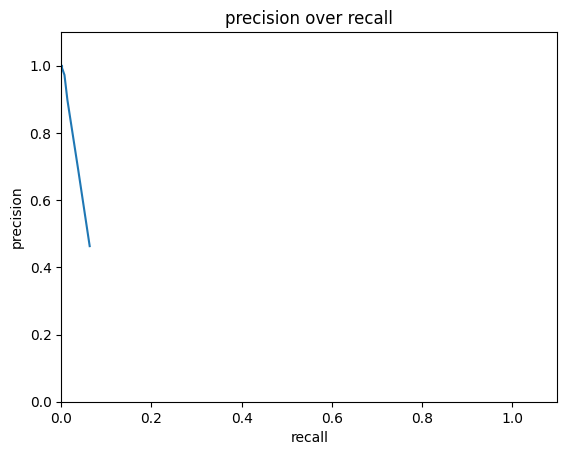

Training started.


100%|██████████| 17/17 [00:31<00:00,  1.86s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.12it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

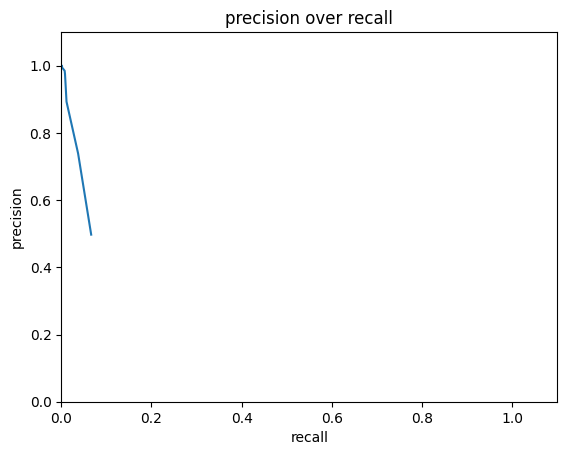

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.82s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 34.56it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

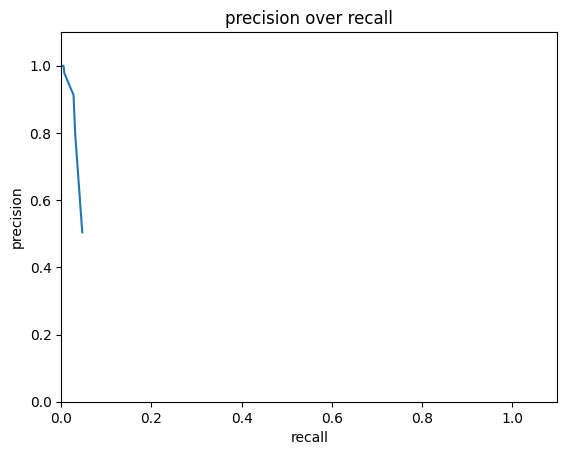

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.82s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.89it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

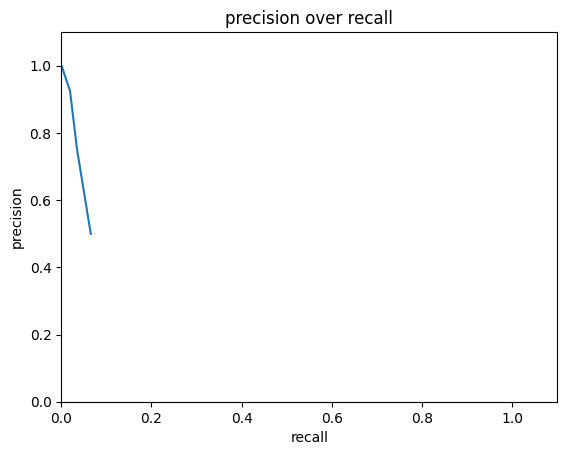

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 23.53it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

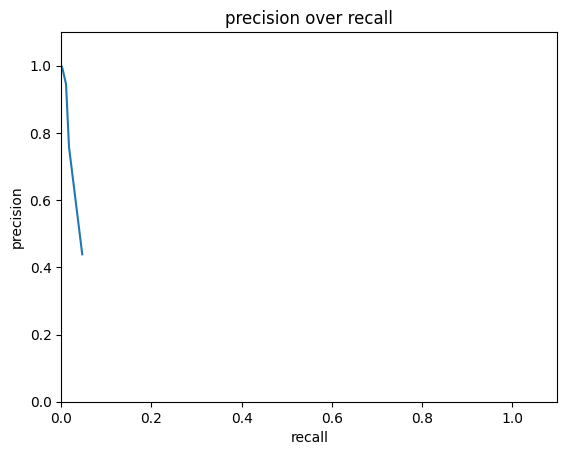

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.91it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

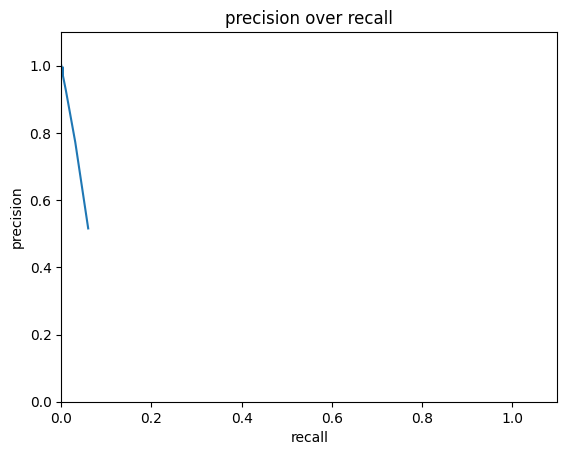

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 22.42it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

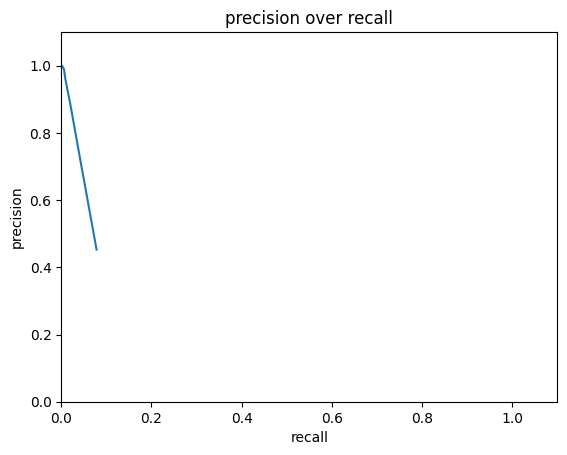

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.82s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.56it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

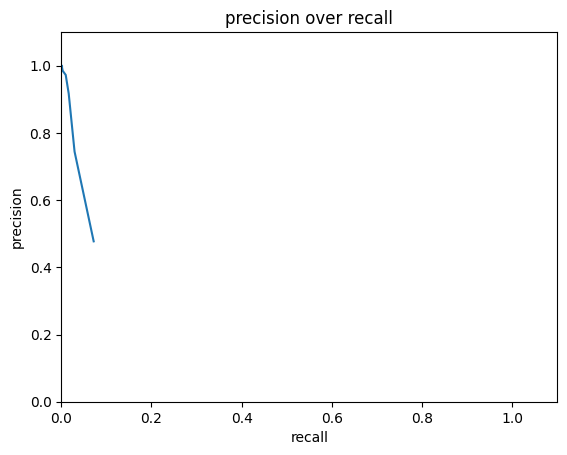

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 25.14it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

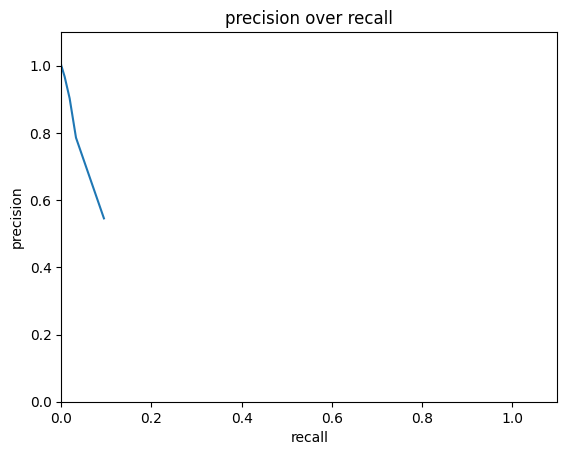

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 30.23it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

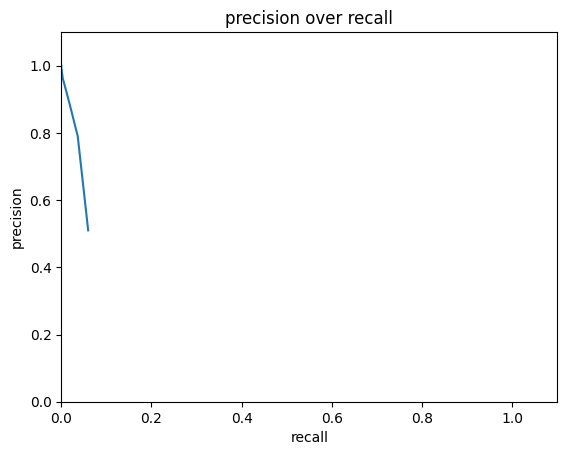

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:06<00:00, 32.24it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

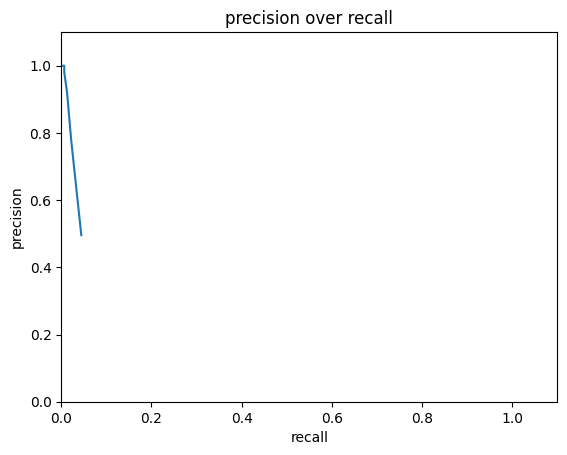

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 26.92it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

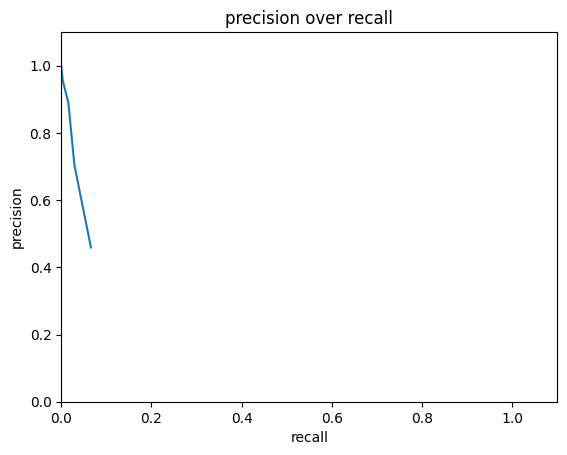

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 27.42it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

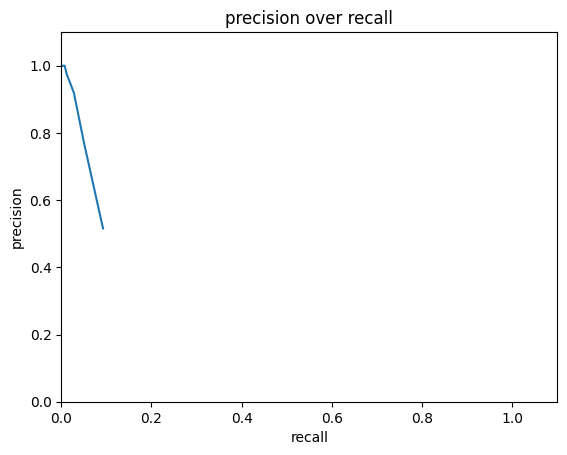

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.77s/it]


Validation started.


100%|██████████| 200/200 [00:08<00:00, 24.24it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

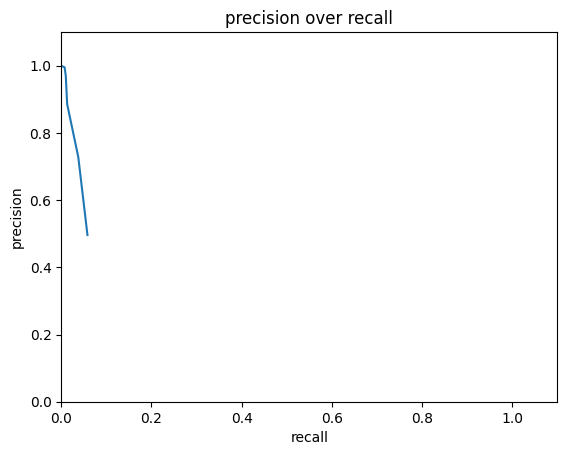

Training started.


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation started.


100%|██████████| 200/200 [00:07<00:00, 28.09it/s]

average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

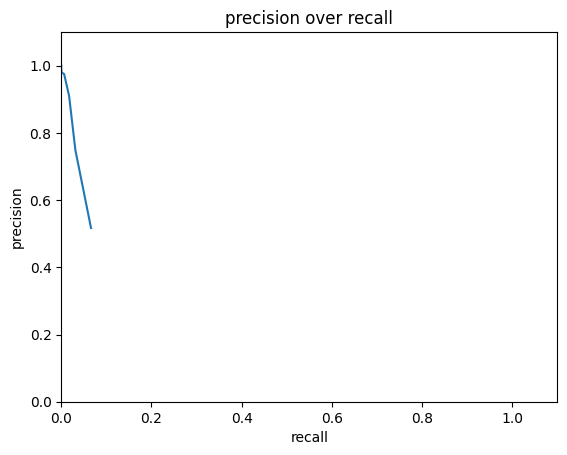

Training started.


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]


Validation started.


100%|██████████| 200/200 [00:05<00:00, 33.49it/s]


average precision [0.42104838224241214, 0.4220728966997624, 0.4276668605026815, 0.4271585793973854, 0.4037072932595321, 0.4294695354396847, 0.3447987336047038, 0.42155007789336146, 0.33583771121084555, 0.4207146087743103, 0.42778154681139763, 0.42306271671943313, 0.41935111599290703, 0.42005341259072604, 0.4212191208459865, 0.4198972669121923, 0.5086226515330993, 0.41348075639120424, 0.3366154763373217, 0.42593615616003677, 0.3440935653622221, 0.33894416804864563, 0.3414945474646967, 0.3454168551183477, 0.42028547737502964, 0.3441655359565807, 0.4172384829101246, 0.35128900949796477, 0.34158608113831995, 0.3471732247851651, 0.3391516443755249, 0.3441052314186642, 0.42133273028795415, 0.3436448708836769, 0.41719163920656455, 0.3444896728478818, 0.34243572900289315, 0.33606857487454506, 0.42478875463950094, 0.4255917382783054, 0.34765566108849694, 0.3480758185982067, 0.33336348560229156, 0.34386832073399237, 0.3417888910426224, 0.3381113910964657, 0.34047942107643603, 0.3438236307639293,

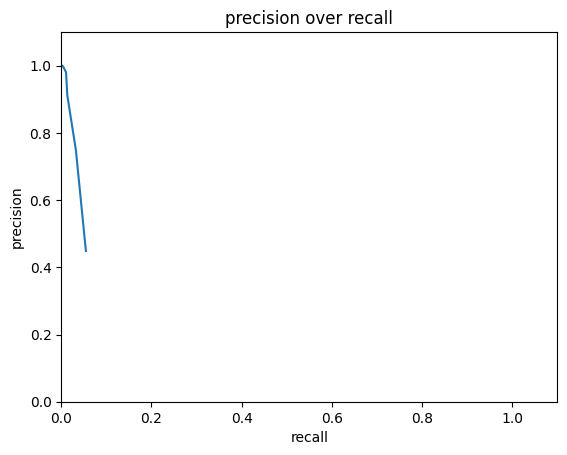

In [14]:
import matplotlib.pyplot as plt
import numpy as np

NUM_TEST_SAMPLES = 200
NUM_EPOCHS = 20
test_AP = []
num_iterations = 20
ratio = 0.02

for iteration in range(num_iterations):
    print(f"-----Pruning iteration {iteration+1}/{num_iterations}-----")
    state_dict = l1_structured_pruning(net.cpu().state_dict(), ratio)
    state_dict = densify_state_dict(state_dict)
    net.load_state_dict(state_dict)
    print(f"Pruning done.")
    
    for epoch in range(NUM_EPOCHS):
        if epoch != 0:
            net.train()
            net.to(device)
            print("Training started.")
            for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
                input, target = input.to(device), target.to(device)
                optimizer.zero_grad()
                #Yolo head is implemented in the loss for training, therefore yolo=False
                output = net(input, yolo=False)
                loss, _ = criterion(output, target)
                loss.backward()
                optimizer.step()
            
        test_precision = []
        test_recall = []
        net.eval()
        net.to(device)
        print("Validation started.")
        with torch.no_grad():
            for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=NUM_TEST_SAMPLES):
                input, target = input.to(device), target.to(device)
                output = net(input, yolo=True)
        
                #The right threshold values can be adjusted for the target application
                output = filter_boxes(output, 0.3)
                output = nms(output, 0.5)
        
                precision, recall = precision_recall_levels(target[0], output[0])
                test_precision.append(precision)
                test_recall.append(recall)
                if idx == NUM_TEST_SAMPLES:
                    break
                
        #Calculation of average precision with collected samples
        test_AP.append(ap(test_precision, test_recall))
        print('average precision', test_AP)

        #plot ROC
        # display_roc(test_precision, test_recall)
        recall = np.mean(np.array(test_recall), axis=0)
        precision = np.mean(np.array(test_precision), axis=0)
        plt.plot(recall, precision)
        plt.xlim((0,1.1))
        plt.ylim((0,1.1))
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.title('precision over recall')
        if (epoch + 1) % 5 == 0:
            plt.savefig(f"plot/voc_pruned_r002_{iteration}_times_{epoch}_epochs.png")
            torch.save(state_dict, f'models/voc_pruned_r002_{iteration}_times_{epoch}_epochs_lr0001_decay0005.pt')
        plt.show()

        
    

In [ ]:
torch.save(state_dict, 'pruned_tinyyolov2NoBN.pt')